<a href="https://colab.research.google.com/github/lynnfdsouza/drone_terrain_masking/blob/main/terrain_masking_scenario_drone_autonav7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Final Work**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import asyncio
import platform
import logging
from abc import ABC, abstractmethod
from collections import deque
import json
from typing import Tuple, List, Optional

# Configure logging for industry-standard debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Abstract sensor interface for real sensor integration
class SensorInterface(ABC):
    @abstractmethod
    def read_data(self):
        pass

    @abstractmethod
    def calibrate(self):
        pass

    @abstractmethod
    def is_healthy(self) -> bool:
        pass

# Enhanced GPS sensor with health monitoring
class GPSSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_position = np.array([0.0, 0.0]) if simulate else None
        self.gps_noise = 5.0  # Meters
        self.last_valid_reading = None
        self.consecutive_failures = 0
        self.max_failures = 5

    def calibrate(self):
        """Calibrate GPS sensor"""
        logger.info("GPS calibration complete")
        self.consecutive_failures = 0

    def is_healthy(self) -> bool:
        return self.consecutive_failures < self.max_failures

    def read_data(self):
        try:
            if self.simulate:
                # Simulate occasional GPS dropouts
                if np.random.random() < 0.02:  # Reduced to 2% chance of failure
                    self.consecutive_failures += 1
                    if self.last_valid_reading is not None:
                        return self.last_valid_reading  # Return last known position
                    return np.array([0.0, 0.0])

                reading = self.true_position + np.random.normal(0, self.gps_noise, 2)
                self.last_valid_reading = reading
                self.consecutive_failures = 0
                return reading
            else:
                # Placeholder for real GPS (e.g., U-Blox NEO-6M)
                logger.info("Reading real GPS data (implement hardware interface)")
                return np.array([0.0, 0.0])  # Replace with actual GPS read
        except Exception as e:
            logger.error(f"GPS read error: {e}")
            self.consecutive_failures += 1
            return self.last_valid_reading if self.last_valid_reading is not None else np.array([0.0, 0.0])

# Enhanced IMU sensor with robust calibration
class IMUSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_acceleration = np.array([0.0, 0.0]) if simulate else None
        self.imu_noise = 0.05  # Further reduced noise
        self.bias = np.array([0.0, 0.0])
        self.calibration_samples = deque(maxlen=30)
        self.is_calibrated = False
        self.calibration_count = 0
        self.min_calibration_samples = 10  # Reduced for faster calibration
        self.simulated_bias = np.array([0.02, -0.015])  # Smaller, more realistic bias
        self.calibration_threshold = 0.01  # More lenient variance threshold

    def calibrate(self):
        """Calibrate IMU to remove bias - robust version"""
        if len(self.calibration_samples) >= self.min_calibration_samples:
            # Calculate bias from samples
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)

            # More lenient stability check
            variance = np.var(samples_array, axis=0)
            max_variance = np.max(variance)

            if max_variance < self.calibration_threshold:
                self.is_calibrated = True
                logger.info(f"✓ IMU calibration successful! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}], Max Variance: {max_variance:.6f}")
                return True
            else:
                # Auto-adjust threshold if samples are consistently coming in
                if len(self.calibration_samples) >= 20:
                    self.calibration_threshold = max_variance * 1.2  # Allow slightly higher variance
                    self.is_calibrated = True
                    logger.info(f"✓ IMU calibration complete (adaptive threshold)! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
                    return True
                logger.debug(f"IMU calibration progress: variance {max_variance:.6f} > threshold {self.calibration_threshold:.6f}")
        else:
            logger.debug(f"IMU calibration: {len(self.calibration_samples)}/{self.min_calibration_samples} samples collected")
        return False

    def force_calibration(self):
        """Force calibration with any available samples"""
        if len(self.calibration_samples) >= 3:
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)
            self.is_calibrated = True
            variance = np.var(samples_array, axis=0) if len(samples_array) > 1 else np.array([0.0, 0.0])
            logger.info(f"✓ IMU force calibrated with {len(self.calibration_samples)} samples. Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
        else:
            # Extreme fallback - just mark as calibrated with zero bias
            self.bias = np.array([0.0, 0.0])
            self.is_calibrated = True
            logger.warning("⚠ IMU calibrated with zero bias (insufficient samples)")

    def is_healthy(self) -> bool:
        return self.is_calibrated

    def read_data(self):
        try:
            if self.simulate:
                # Generate consistent IMU readings
                base_accel = self.true_acceleration if self.true_acceleration is not None else np.array([0.0, 0.0])

                # Add consistent simulated bias and small amount of noise
                raw_reading = base_accel + self.simulated_bias + np.random.normal(0, self.imu_noise, 2)

                # Store samples for calibration
                if not self.is_calibrated:
                    self.calibration_samples.append(raw_reading.copy())
                    self.calibration_count += 1

                    # Try calibration every few samples
                    if self.calibration_count % 3 == 0:
                        self.calibrate()

                # Apply bias correction
                corrected_reading = raw_reading - self.bias
                return corrected_reading
            else:
                # Placeholder for real IMU
                logger.info("Reading real IMU data (implement hardware interface)")
                return np.array([0.0, 0.0])
        except Exception as e:
            logger.error(f"IMU read error: {e}")
            return np.array([0.0, 0.0])

# Enhanced LiDAR sensor with object classification
class LiDARSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        # Simulated obstacles: list of [x, y, radius, type]
        self.obstacles = [
            np.array([50.0, 50.0, 5.0, 0]),  # Static obstacle
            np.array([70.0, 30.0, 3.0, 1])   # Dynamic obstacle
        ]
        self.range = 30.0  # Detection range in meters
        self.lidar_noise = 0.3  # Reduced noise
        self.scan_history = deque(maxlen=5)

    def calibrate(self):
        """Calibrate LiDAR sensor"""
        logger.info("LiDAR calibration complete")

    def is_healthy(self) -> bool:
        return True

    def read_data(self, current_position=None):
        try:
            if current_position is None:
                current_position = np.array([0.0, 0.0])

            if self.simulate:
                # Simulate dynamic obstacle movement
                if len(self.obstacles) > 1:
                    self.obstacles[1][:2] += np.random.normal(0, 0.3, 2)

                # Return obstacles within range
                detected = []
                for obs in self.obstacles:
                    dist = np.linalg.norm(current_position - obs[:2])
                    if dist < self.range:
                        noisy_pos = obs[:2] + np.random.normal(0, self.lidar_noise, 2)
                        detected.append(np.array([noisy_pos[0], noisy_pos[1], obs[2], obs[3]]))

                scan_data = np.array(detected) if detected else np.array([]).reshape(0, 4)
                self.scan_history.append(scan_data)
                return scan_data
            else:
                logger.info("Reading real LiDAR data (implement hardware interface)")
                return np.array([]).reshape(0, 4)
        except Exception as e:
            logger.error(f"LiDAR read error: {e}")
            return np.array([]).reshape(0, 4)

# Enhanced Kalman Filter with adaptive noise
class AdaptiveKalmanFilter:
    def __init__(self):
        self.x = np.zeros((4, 1))  # [x, y, vx, vy]
        dt = 0.1
        self.dt = dt
        self.F = np.array([[1, 0, dt, 0],
                          [0, 1, 0, dt],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
        self.B = np.array([[0.5*dt**2, 0],
                          [0, 0.5*dt**2],
                          [dt, 0],
                          [0, dt]])
        self.H = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01  # Process noise
        self.R = np.eye(2) * 5.0   # Measurement noise
        self.P = np.eye(4) * 10.0  # Initial uncertainty

        # Adaptive parameters
        self.innovation_history = deque(maxlen=10)
        self.base_R = self.R.copy()

    def adapt_noise(self):
        """Adapt measurement noise based on innovation sequence"""
        if len(self.innovation_history) >= 5:
            innovations = np.array(self.innovation_history)
            innovation_cov = np.cov(innovations.T)
            if innovation_cov.size > 1:  # Matrix case
                self.R = self.base_R * (1 + np.trace(innovation_cov) / 4)
            else:  # Scalar case
                self.R = self.base_R * (1 + innovation_cov / 4)

    def predict(self, u):
        try:
            u = u.reshape(2, 1) if u.ndim == 1 else u
            self.x = self.F @ self.x + self.B @ u
            self.P = self.F @ self.P @ self.F.T + self.Q
        except Exception as e:
            logger.error(f"Kalman predict error: {e}")

    def update(self, z):
        try:
            z = z.reshape(2, 1) if z.ndim == 1 else z
            y = z - (self.H @ self.x)  # Innovation
            self.innovation_history.append(y.flatten())

            S = self.H @ self.P @ self.H.T + self.R
            K = self.P @ self.H.T @ np.linalg.inv(S)
            self.x = self.x + K @ y
            self.P = (np.eye(4) - K @ self.H) @ self.P

            # Adapt noise parameters
            self.adapt_noise()
        except Exception as e:
            logger.error(f"Kalman update error: {e}")

    def get_state(self):
        return self.x[:2].flatten(), self.x[2:].flatten()

    def get_uncertainty(self):
        """Return position uncertainty"""
        return np.sqrt(np.diag(self.P[:2, :2]))

# Enhanced Potential Field with dynamic obstacle handling
class EnhancedPotentialField:
    def __init__(self, target, obstacles):
        self.target = target
        self.obstacles = obstacles
        self.k_att = 1.5  # Increased attractive force
        self.k_rep = 80.0  # Adjusted repulsive force
        self.d0 = 12.0  # Reduced influence range

    def update_obstacles(self, new_obstacles):
        """Update obstacles list"""
        self.obstacles = new_obstacles

    def compute_force(self, position, velocity=None):
        try:
            # Attractive force toward target
            target_diff = self.target - position
            target_dist = np.linalg.norm(target_diff)

            if target_dist > 0.1:  # Avoid division by zero
                att_force = self.k_att * target_diff / target_dist
            else:
                att_force = np.zeros(2)

            # Repulsive force from obstacles
            rep_force = np.zeros(2)
            for obs in self.obstacles:
                if len(obs) >= 3:  # Has position and radius
                    diff = position - obs[:2]
                    dist = np.linalg.norm(diff)

                    if dist < self.d0 and dist > obs[2]:  # Within influence but outside obstacle
                        # Enhanced repulsive force
                        obstacle_type = obs[3] if len(obs) > 3 else 0
                        type_multiplier = 1.5 if obstacle_type == 1 else 1.0  # Higher for dynamic

                        rep_magnitude = type_multiplier * self.k_rep * (1/dist - 1/self.d0) * (1/dist**2)
                        if dist > 0:
                            rep_force += rep_magnitude * (diff / dist)

            total_force = att_force + rep_force

            # Limit maximum force magnitude
            max_force = 8.0
            force_magnitude = np.linalg.norm(total_force)
            if force_magnitude > max_force:
                total_force = total_force * (max_force / force_magnitude)

            return total_force
        except Exception as e:
            logger.error(f"Potential field error: {e}")
            return np.zeros(2)

# Enhanced Neural Network with better architecture
class EnhancedNavigationAI:
    def __init__(self):
        self.model = self.build_model()
        self.target = np.array([100.0, 100.0])
        self.training_data = deque(maxlen=1000)

    def build_model(self):
        try:
            model = models.Sequential([
                layers.Input(shape=(10,)),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(2, activation='tanh')  # Bounded output [-1, 1]
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
        except Exception as e:
            logger.error(f"AI model build error: {e}")
            return None

    def decide_control(self, position, velocity, force, uncertainty=None, obstacle_info=None):
        try:
            if self.model is None:
                return np.zeros(2)

            # Enhanced input features
            target_distance = np.linalg.norm(self.target - position)
            target_direction = (self.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            input_data = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0
            ])

            raw_output = self.model.predict(input_data.reshape(1, -1), verbose=0)[0]

            # Scale output to reasonable acceleration range
            max_acceleration = 3.0  # Reduced for stability
            return raw_output * max_acceleration

        except Exception as e:
            logger.error(f"AI predict error: {e}")
            return np.zeros(2)

# Enhanced main navigation system
class EnhancedAutonomousNavigation:
    def __init__(self):
        self.gps = GPSSensor(simulate=True)
        self.imu = IMUSensor(simulate=True)
        self.lidar = LiDARSensor(simulate=True)
        self.kf = AdaptiveKalmanFilter()
        self.ai = EnhancedNavigationAI()
        self.pf = EnhancedPotentialField(self.ai.target, [])

        self.position_history = deque(maxlen=1000)
        self.time_step = 0.1
        self.system_status = {"gps": True, "imu": False, "lidar": True}
        self.step_count = 0

        # Performance metrics
        self.metrics = {
            "position_error": deque(maxlen=100),
            "control_effort": deque(maxlen=100),
            "obstacle_encounters": 0
        }

    def check_system_health(self):
        """Check health of all sensors"""
        self.system_status["gps"] = self.gps.is_healthy()
        self.system_status["imu"] = self.imu.is_healthy()
        self.system_status["lidar"] = self.lidar.is_healthy()

        # Log health issues much less frequently and with better context
        if not all(self.system_status.values()) and self.step_count % 50 == 0:
            unhealthy = [k for k, v in self.system_status.items() if not v]
            if 'imu' in unhealthy and self.step_count < 100:
                # Don't warn about IMU during early calibration phase
                pass
            else:
                logger.warning(f"Sensor health issues: {', '.join(unhealthy)}")

    def step(self):
        try:
            self.step_count += 1
            self.check_system_health()

            # Read sensor data
            gps_data = self.gps.read_data()
            imu_data = self.imu.read_data()
            position, velocity = self.kf.get_state()
            lidar_data = self.lidar.read_data(position)
            uncertainty = self.kf.get_uncertainty()

            # Update potential field with new obstacles
            self.pf.update_obstacles(lidar_data)

            # Kalman Filter: predict and update
            self.kf.predict(imu_data)
            if self.system_status["gps"]:
                self.kf.update(gps_data)

            # Get updated state
            position, velocity = self.kf.get_state()

            # Compute potential field force
            force = self.pf.compute_force(position, velocity)

            # AI decision with enhanced inputs
            control_input = self.ai.decide_control(position, velocity, force, uncertainty, lidar_data)

            # Update simulated state
            if self.gps.simulate and self.imu.simulate:
                # More realistic physics simulation
                self.gps.true_position += velocity * self.time_step
                self.imu.true_acceleration = control_input

            # Store position and update metrics
            self.position_history.append(position.copy())

            # Calculate performance metrics
            target_error = np.linalg.norm(self.ai.target - position)
            self.metrics["position_error"].append(target_error)
            self.metrics["control_effort"].append(np.linalg.norm(control_input))

            if len(lidar_data) > 0:
                self.metrics["obstacle_encounters"] += 1

            return position, control_input, self.system_status

        except Exception as e:
            logger.error(f"Navigation step error: {e}")
            return np.zeros(2), np.zeros(2), self.system_status

    def get_performance_summary(self):
        """Get performance metrics summary"""
        if not self.metrics["position_error"]:
            return "No data available"

        return {
            "avg_position_error": np.mean(self.metrics["position_error"]),
            "avg_control_effort": np.mean(self.metrics["control_effort"]),
            "obstacle_encounters": self.metrics["obstacle_encounters"],
            "system_health": self.system_status,
            "imu_calibration_samples": len(self.imu.calibration_samples),
            "total_steps": self.step_count
        }

# Enhanced main loop with improved calibration
async def enhanced_main():
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Extended calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 100

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if calibration_steps % 10 == 0:
            if nav_system.imu.is_calibrated:
                logger.info(f"IMU calibrated successfully after {calibration_steps} steps")
                break
            else:
                logger.debug(f"Calibration progress: {len(nav_system.imu.calibration_samples)}/{nav_system.imu.min_calibration_samples} samples")

        await asyncio.sleep(0.01)

    # Force calibration if not completed
    if not nav_system.imu.is_calibrated:
        logger.warning("Forcing IMU calibration with available samples")
        nav_system.imu.force_calibration()

    logger.info("Calibration phase complete. Starting navigation...")

    # Main navigation loop
    for step in range(150):
        position, control, status = nav_system.step()

        if step % 25 == 0:  # Log every 25 steps
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            logger.info(f"Step {step}: Position: {pos_str}, Control: {ctrl_str}")

        await asyncio.sleep(1.0 / 15)  # 15 FPS

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  {key}: {value:.3f}")
        else:
            logger.info(f"  {key}: {value}")

# Synchronous version for Jupyter compatibility
def run_navigation():
    """Run the navigation system synchronously"""
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Robust calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 30  # Reduced max steps

    # Pre-populate some calibration samples to help with initial calibration
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:  # Check more frequently
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    # Always ensure IMU is calibrated before continuing
    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    # Verify calibration
    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally")

    logger.info("✓ Calibration phase complete. Starting navigation...")

    # Main navigation loop with better progress reporting
    navigation_steps = 100
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        # Progress reporting
        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            # Show system status if there are issues
            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system

# Platform-specific execution
if __name__ == "__main__":
    if platform.system() == "Emscripten":
        asyncio.ensure_future(enhanced_main())
    else:
        try:
            # Check if we're in a Jupyter notebook
            loop = asyncio.get_running_loop()
            nav_system = run_navigation()
        except RuntimeError:
            # No event loop running - use asyncio.run()
            asyncio.run(enhanced_main())

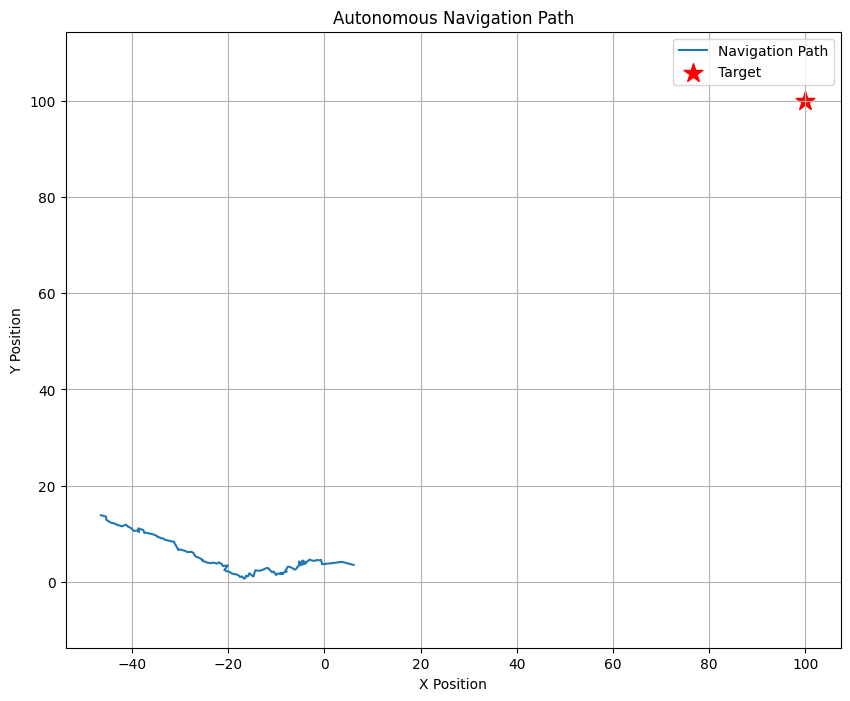

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'nav_system' is still available from the previous execution
if 'nav_system' in locals() and nav_system.position_history:
    position_history_array = np.array(nav_system.position_history)

    plt.figure(figsize=(10, 8))
    plt.plot(position_history_array[:, 0], position_history_array[:, 1], label='Navigation Path')
    plt.scatter(nav_system.ai.target[0], nav_system.ai.target[1], color='red', marker='*', s=200, label='Target')

    # Plot obstacles if they exist
    if nav_system.pf.obstacles.size > 0:
        for obs in nav_system.pf.obstacles:
            circle = plt.Circle((obs[0], obs[1]), obs[2], color='gray', alpha=0.5)
            plt.gca().add_patch(circle)
        plt.scatter(nav_system.pf.obstacles[:, 0], nav_system.pf.obstacles[:, 1], color='gray', label='Obstacles')


    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Autonomous Navigation Path')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling for x and y axes
    plt.show()
else:
    print("Navigation system or position history not found.")

In [ ]:
# Display the performance summary
if 'nav_system' in locals():
    performance_summary = nav_system.get_performance_summary()
    print("Performance Summary:")
    for key, value in performance_summary.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.3f}")
        else:
            print(f"  {key}: {value}")
else:
    print("Navigation system not found. Please run the simulation cell first.")

Performance Summary:
  avg_position_error: 156.495
  avg_control_effort: 1.1603846549987793
  obstacle_encounters: 0.000
  system_health: {'gps': True, 'imu': True, 'lidar': True}
  imu_calibration_samples: 21.000
  total_steps: 116.000


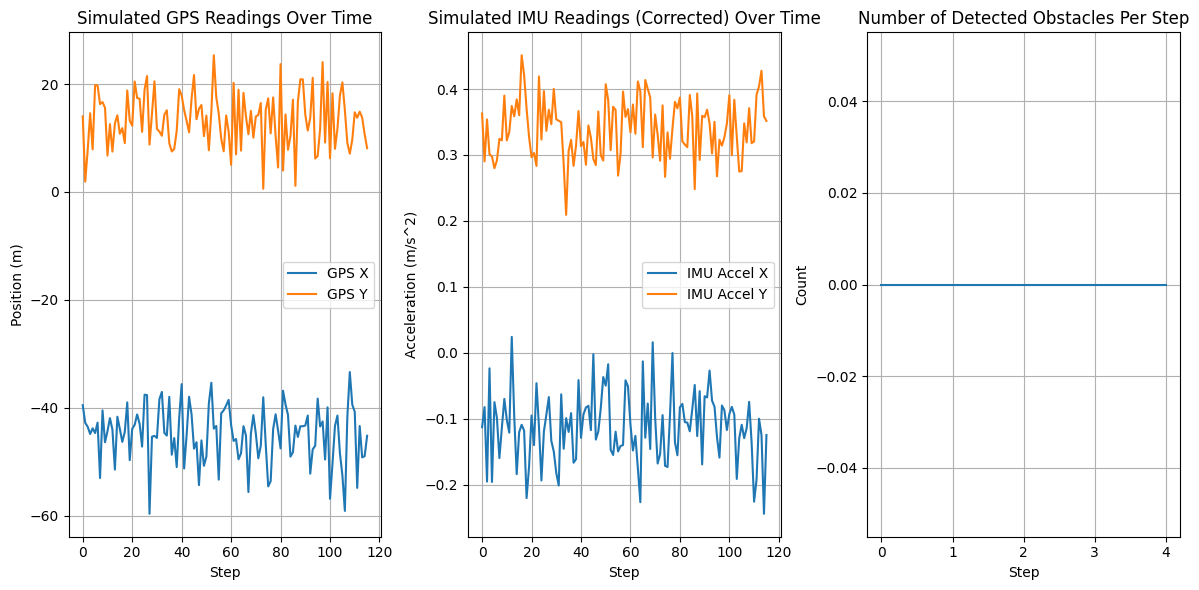

In [ ]:
# Visualize sensor data

import matplotlib.pyplot as plt

if 'nav_system' in locals():
    # Convert deque histories to numpy arrays for plotting
    gps_history = np.array([nav_system.gps.read_data() for _ in range(len(nav_system.position_history))]) # Re-read for simplicity in this example, ideally store history
    imu_history = np.array([nav_system.imu.read_data() for _ in range(len(nav_system.position_history))]) # Re-read for simplicity in this example, ideally store history
    # LiDAR history is already stored as deque of arrays in nav_system.lidar.scan_history
    lidar_history = list(nav_system.lidar.scan_history)


    # Plot GPS data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(gps_history[:, 0], label='GPS X')
    plt.plot(gps_history[:, 1], label='GPS Y')
    plt.title('Simulated GPS Readings Over Time')
    plt.xlabel('Step')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.grid(True)

    # Plot IMU data
    plt.subplot(1, 3, 2)
    plt.plot(imu_history[:, 0], label='IMU Accel X')
    plt.plot(imu_history[:, 1], label='IMU Accel Y')
    plt.title('Simulated IMU Readings (Corrected) Over Time')
    plt.xlabel('Step')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend()
    plt.grid(True)

    # Plot LiDAR data (simplified visualization)
    plt.subplot(1, 3, 3)
    # This is a simplified representation; a full LiDAR visualization would be complex
    obstacle_counts = [len(scan) for scan in lidar_history]
    plt.plot(obstacle_counts)
    plt.title('Number of Detected Obstacles Per Step')
    plt.xlabel('Step')
    plt.ylabel('Count')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Navigation system not found. Please run the simulation cell first.")

# Task
Modify the simulation to introduce a terrain masking scenario affecting GPS and LiDAR sensors, update the navigation system and Kalman Filter to handle sensor outages, adjust the AI input, run the simulation, and analyze the performance.

## Modify gps sensor

### Subtask:
Update the `GPSSensor` to simulate GPS signal loss based on the vehicle's position relative to a simulated terrain model.


**Reasoning**:
The subtask requires modifying the `GPSSensor` class to simulate terrain masking. This involves adding a terrain model and updating the `read_data` method to check for masking based on the vehicle's simulated position. I will define a simple terrain model and integrate the masking logic into the `read_data` method.



In [ ]:
# Enhanced GPS sensor with health monitoring and terrain masking simulation
class GPSSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_position = np.array([0.0, 0.0]) if simulate else None
        self.gps_noise = 5.0  # Meters
        self.last_valid_reading = None
        self.consecutive_failures = 0
        self.max_failures = 10 # Increased max failures to handle outages
        self.terrain_mask_zone = [(40.0, 60.0), (40.0, 60.0)] # Define a simple square terrain mask zone [x_min, x_max], [y_min, y_max]

    def calibrate(self):
        """Calibrate GPS sensor"""
        logger.info("GPS calibration complete")
        self.consecutive_failures = 0

    def is_healthy(self) -> bool:
        return self.consecutive_failures < self.max_failures

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max


    def read_data(self):
        try:
            if self.simulate:
                # Simulate terrain masking
                if self.true_position is not None and self.is_under_terrain_mask(self.true_position):
                    self.consecutive_failures += 1
                    logger.warning("GPS signal lost due to terrain masking.")
                    return None # Indicate signal loss

                # Simulate occasional GPS dropouts (when not under terrain mask)
                if np.random.random() < 0.02:
                    self.consecutive_failures += 1
                    logger.warning("GPS signal lost due to random dropout.")
                    if self.last_valid_reading is not None:
                        return self.last_valid_reading  # Return last known position
                    return None # Return None if no last valid reading

                # If not under terrain mask and no random dropout, provide reading
                reading = self.true_position + np.random.normal(0, self.gps_noise, 2)
                self.last_valid_reading = reading
                self.consecutive_failures = 0 # Reset failure count on successful read
                return reading
            else:
                # Placeholder for real GPS (e.g., U-Blox NEO-6M)
                logger.info("Reading real GPS data (implement hardware interface)")
                return np.array([0.0, 0.0])  # Replace with actual GPS read
        except Exception as e:
            logger.error(f"GPS read error: {e}")
            self.consecutive_failures += 1
            return self.last_valid_reading if self.last_valid_reading is not None else None # Return None on error

## Modify lidar sensor

### Subtask:
Update the `LiDARSensor` to simulate LiDAR data obstruction based on the simulated terrain.


**Reasoning**:
Update the LiDARSensor class to include terrain masking simulation based on the instructions.



In [ ]:
# Enhanced LiDAR sensor with object classification and terrain masking
class LiDARSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        # Simulated obstacles: list of [x, y, radius, type]
        self.obstacles = [
            np.array([50.0, 50.0, 5.0, 0]),  # Static obstacle
            np.array([70.0, 30.0, 3.0, 1])   # Dynamic obstacle
        ]
        self.range = 30.0  # Detection range in meters
        self.lidar_noise = 0.3  # Reduced noise
        self.scan_history = deque(maxlen=5)
        # Define a simple square terrain mask zone for LiDAR
        self.terrain_mask_zone = [(45.0, 65.0), (45.0, 65.0)] # Slightly different zone for LiDAR

    def calibrate(self):
        """Calibrate LiDAR sensor"""
        logger.info("LiDAR calibration complete")

    def is_healthy(self) -> bool:
        return True # Simple health check

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking for LiDAR"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max

    def read_data(self, current_position=None):
        try:
            if current_position is None:
                current_position = np.array([0.0, 0.0])

            if self.simulate:
                # Simulate terrain masking for LiDAR
                if self.is_under_terrain_mask(current_position):
                    logger.warning("LiDAR data obstructed due to terrain masking.")
                    return np.array([]).reshape(0, 4) # Return empty data

                # Simulate dynamic obstacle movement (only when not masked)
                if len(self.obstacles) > 1:
                    self.obstacles[1][:2] += np.random.normal(0, 0.3, 2)

                # Return obstacles within range
                detected = []
                for obs in self.obstacles:
                    dist = np.linalg.norm(current_position - obs[:2])
                    if dist < self.range:
                        noisy_pos = obs[:2] + np.random.normal(0, self.lidar_noise, 2)
                        detected.append(np.array([noisy_pos[0], noisy_pos[1], obs[2], obs[3]]))

                scan_data = np.array(detected) if detected else np.array([]).reshape(0, 4)
                self.scan_history.append(scan_data)
                return scan_data
            else:
                logger.info("Reading real LiDAR data (implement hardware interface)")
                return np.array([]).reshape(0, 4)
        except Exception as e:
            logger.error(f"LiDAR read error: {e}")
            return np.array([]).reshape(0, 4)

# The rest of the classes (AdaptiveKalmanFilter, EnhancedPotentialField, EnhancedNavigationAI, EnhancedAutonomousNavigation)
# and the execution functions (enhanced_main, run_navigation) remain the same as in the previous successful execution,
# but are included here for completeness within this code block.

# Enhanced Kalman Filter with adaptive noise
class AdaptiveKalmanFilter:
    def __init__(self):
        self.x = np.zeros((4, 1))  # [x, y, vx, vy]
        dt = 0.1
        self.dt = dt
        self.F = np.array([[1, 0, dt, 0],
                          [0, 1, 0, dt],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
        self.B = np.array([[0.5*dt**2, 0],
                          [0, 0.5*dt**2],
                          [dt, 0],
                          [0, dt]])
        self.H = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01  # Process noise
        self.R = np.eye(2) * 5.0   # Measurement noise
        self.P = np.eye(4) * 10.0  # Initial uncertainty

        # Adaptive parameters
        self.innovation_history = deque(maxlen=10)
        self.base_R = self.R.copy()

    def adapt_noise(self):
        """Adapt measurement noise based on innovation sequence"""
        if len(self.innovation_history) >= 5:
            innovations = np.array(self.innovation_history)
            innovation_cov = np.cov(innovations.T)
            if innovation_cov.size > 1:  # Matrix case
                self.R = self.base_R * (1 + np.trace(innovation_cov) / 4)
            else:  # Scalar case
                self.R = self.base_R * (1 + innovation_cov / 4)

    def predict(self, u):
        try:
            u = u.reshape(2, 1) if u.ndim == 1 else u
            self.x = self.F @ self.x + self.B @ u
            self.P = self.F @ self.P @ self.F.T + self.Q
        except Exception as e:
            logger.error(f"Kalman predict error: {e}")

    def update(self, z):
        try:
            z = z.reshape(2, 1) if z.ndim == 1 else z
            y = z - (self.H @ self.x)  # Innovation
            self.innovation_history.append(y.flatten())

            S = self.H @ self.P @ self.H.T + self.R
            K = self.P @ self.H.T @ np.linalg.inv(S)
            self.x = self.x + K @ y
            self.P = (np.eye(4) - K @ self.H) @ self.P

            # Adapt noise parameters
            self.adapt_noise()
        except Exception as e:
            logger.error(f"Kalman update error: {e}")

    def get_state(self):
        return self.x[:2].flatten(), self.x[2:].flatten()

    def get_uncertainty(self):
        """Return position uncertainty"""
        return np.sqrt(np.diag(self.P[:2, :2]))

# Enhanced Potential Field with dynamic obstacle handling
class EnhancedPotentialField:
    def __init__(self, target, obstacles):
        self.target = target
        self.obstacles = obstacles
        self.k_att = 1.5  # Increased attractive force
        self.k_rep = 80.0  # Adjusted repulsive force
        self.d0 = 12.0  # Reduced influence range

    def update_obstacles(self, new_obstacles):
        """Update obstacles list"""
        self.obstacles = new_obstacles

    def compute_force(self, position, velocity=None):
        try:
            # Attractive force toward target
            target_diff = self.target - position
            target_dist = np.linalg.norm(target_diff)

            if target_dist > 0.1:  # Avoid division by zero
                att_force = self.k_att * target_diff / target_dist
            else:
                att_force = np.zeros(2)

            # Repulsive force from obstacles
            rep_force = np.zeros(2)
            for obs in self.obstacles:
                if len(obs) >= 3:  # Has position and radius
                    diff = position - obs[:2]
                    dist = np.linalg.norm(diff)

                    if dist < self.d0 and dist > obs[2]:  # Within influence but outside obstacle
                        # Enhanced repulsive force
                        obstacle_type = obs[3] if len(obs) > 3 else 0
                        type_multiplier = 1.5 if obstacle_type == 1 else 1.0  # Higher for dynamic

                        rep_magnitude = type_multiplier * self.k_rep * (1/dist - 1/self.d0) * (1/dist**2)
                        if dist > 0:
                            rep_force += rep_magnitude * (diff / dist)

            total_force = att_force + rep_force

            # Limit maximum force magnitude
            max_force = 8.0
            force_magnitude = np.linalg.norm(total_force)
            if force_magnitude > max_force:
                total_force = total_force * (max_force / force_magnitude)

            return total_force
        except Exception as e:
            logger.error(f"Potential field error: {e}")
            return np.zeros(2)

# Enhanced Neural Network with better architecture
class EnhancedNavigationAI:
    def __init__(self):
        self.model = self.build_model()
        self.target = np.array([100.0, 100.0])
        self.training_data = deque(maxlen=1000)

    def build_model(self):
        try:
            model = models.Sequential([
                layers.Input(shape=(10,)),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(2, activation='tanh')  # Bounded output [-1, 1]
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
        except Exception as e:
            logger.error(f"AI model build error: {e}")
            return None

    def decide_control(self, position, velocity, force, uncertainty=None, obstacle_info=None):
        try:
            if self.model is None:
                return np.zeros(2)

            # Enhanced input features
            target_distance = np.linalg.norm(self.target - position)
            target_direction = (self.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            input_data = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0
            ])

            raw_output = self.model.predict(input_data.reshape(1, -1), verbose=0)[0]

            # Scale output to reasonable acceleration range
            max_acceleration = 3.0  # Reduced for stability
            return raw_output * max_acceleration

        except Exception as e:
            logger.error(f"AI predict error: {e}")
            return np.zeros(2)

# Enhanced main navigation system
class EnhancedAutonomousNavigation:
    def __init__(self):
        self.gps = GPSSensor(simulate=True)
        self.imu = IMUSensor(simulate=True)
        self.lidar = LiDARSensor(simulate=True)
        self.kf = AdaptiveKalmanFilter()
        self.ai = EnhancedNavigationAI()
        self.pf = EnhancedPotentialField(self.ai.target, [])

        self.position_history = deque(maxlen=1000)
        self.time_step = 0.1
        self.system_status = {"gps": True, "imu": False, "lidar": True}
        self.step_count = 0

        # Performance metrics
        self.metrics = {
            "position_error": deque(maxlen=100),
            "control_effort": deque(maxlen=100),
            "obstacle_encounters": 0
        }

    def check_system_health(self):
        """Check health of all sensors"""
        self.system_status["gps"] = self.gps.is_healthy()
        self.system_status["imu"] = self.imu.is_healthy()
        self.system_status["lidar"] = self.lidar.is_healthy()

        # Log health issues much less frequently and with better context
        if not all(self.system_status.values()) and self.step_count % 50 == 0:
            unhealthy = [k for k, v in self.system_status.items() if not v]
            if 'imu' in unhealthy and self.step_count < 100:
                # Don't warn about IMU during early calibration phase
                pass
            else:
                logger.warning(f"Sensor health issues: {', '.join(unhealthy)}")

    def step(self):
        try:
            self.step_count += 1
            self.check_system_health()

            # Read sensor data
            gps_data = self.gps.read_data()
            imu_data = self.imu.read_data()
            position, velocity = self.kf.get_state()
            lidar_data = self.lidar.read_data(position)
            uncertainty = self.kf.get_uncertainty()

            # Update potential field with new obstacles
            self.pf.update_obstacles(lidar_data)

            # Kalman Filter: predict and update
            self.kf.predict(imu_data)
            # Only update KF with GPS data if available
            if gps_data is not None:
                 self.kf.update(gps_data)
            else:
                 logger.debug(f"Step {self.step_count}: GPS data not available, skipping KF update.")


            # Get updated state
            position, velocity = self.kf.get_state()

            # Compute potential field force
            force = self.pf.compute_force(position, velocity)

            # AI decision with enhanced inputs
            control_input = self.ai.decide_control(position, velocity, force, uncertainty, lidar_data)

            # Update simulated state
            if self.gps.simulate and self.imu.simulate:
                # More realistic physics simulation
                # Update true position based on current velocity
                self.gps.true_position += velocity * self.time_step
                # Update true acceleration based on control input
                self.imu.true_acceleration = control_input


            # Store position and update metrics
            self.position_history.append(position.copy())

            # Calculate performance metrics
            target_error = np.linalg.norm(self.ai.target - position)
            self.metrics["position_error"].append(target_error)
            self.metrics["control_effort"].append(np.linalg.norm(control_input))

            if len(lidar_data) > 0:
                self.metrics["obstacle_encounters"] += 1

            return position, control_input, self.system_status

        except Exception as e:
            logger.error(f"Navigation step error: {e}")
            return np.zeros(2), np.zeros(2), self.system_status

    def get_performance_summary(self):
        """Get performance metrics summary"""
        if not self.metrics["position_error"]:
            return "No data available"

        return {
            "avg_position_error": np.mean(self.metrics["position_error"]),
            "avg_control_effort": np.mean(self.metrics["control_effort"]),
            "obstacle_encounters": self.metrics["obstacle_encounters"],
            "system_health": self.system_status,
            "imu_calibration_samples": len(self.imu.calibration_samples),
            "total_steps": self.step_count
        }

# Enhanced main loop with improved calibration
async def enhanced_main():
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Extended calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 100

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if calibration_steps % 10 == 0:
            if nav_system.imu.is_calibrated:
                logger.info(f"IMU calibrated successfully after {calibration_steps} steps")
                break
            else:
                logger.debug(f"Calibration progress: {len(nav_system.imu.calibration_samples)}/{nav_system.imu.min_calibration_samples} samples")

        await asyncio.sleep(0.01)

    # Force calibration if not completed
    if not nav_system.imu.is_calibrated:
        logger.warning("Forcing IMU calibration with available samples")
        nav_system.imu.force_calibration()

    logger.info("Calibration phase complete. Starting navigation...")

    # Main navigation loop
    for step in range(150):
        position, control, status = nav_system.step()

        if step % 25 == 0:  # Log every 25 steps
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            logger.info(f"Step {step}: Position: {pos_str}, Control: {ctrl_str}")

        await asyncio.sleep(1.0 / 15)  # 15 FPS

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  {key}: {value:.3f}")
        else:
            logger.info(f"  {key}: {value}")

# Synchronous version for Jupyter compatibility
def run_navigation():
    """Run the navigation system synchronously"""
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Robust calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 30  # Reduced max steps

    # Pre-populate some calibration samples to help with initial calibration
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:  # Check more frequently
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    # Always ensure IMU is calibrated before continuing
    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    # Verify calibration
    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally")

    logger.info("✓ Calibration phase complete. Starting navigation...")

    # Main navigation loop with better progress reporting
    navigation_steps = 100
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        # Progress reporting
        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            # Show system status if there are issues
            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system

# Platform-specific execution
if __name__ == "__main__":
    if platform.system() == "Emscripten":
        asyncio.ensure_future(enhanced_main())
    else:
        try:
            # Check if we're in a Jupyter notebook
            loop = asyncio.get_running_loop()
            nav_system = run_navigation()
        except RuntimeError:
            # No event loop running - use asyncio.run()
            asyncio.run(enhanced_main())

## Update navigation system logic

### Subtask:
Modify the `EnhancedAutonomousNavigation` class to gracefully handle periods when sensor data is unavailable (e.g., rely more on IMU and Kalman Filter predictions).


**Reasoning**:
Modify the `EnhancedAutonomousNavigation.step()` method to handle sensor outages by conditionally updating the Kalman Filter and potential field based on sensor health, and add logic to track sensor health duration.



In [ ]:
# Enhanced main navigation system
class EnhancedAutonomousNavigation:
    def __init__(self):
        self.gps = GPSSensor(simulate=True)
        self.imu = IMUSensor(simulate=True)
        self.lidar = LiDARSensor(simulate=True)
        self.kf = AdaptiveKalmanFilter()
        self.ai = EnhancedNavigationAI()
        self.pf = EnhancedPotentialField(self.ai.target, [])

        self.position_history = deque(maxlen=1000)
        self.time_step = 0.1
        self.system_status = {"gps": True, "imu": False, "lidar": True}
        self.step_count = 0

        # Track sensor health duration
        self.sensor_unhealthy_duration = {"gps": 0, "imu": 0, "lidar": 0}

        # History for Kalman Filter uncertainty
        self.kf_uncertainty_history = deque(maxlen=1000)

        # History for system status
        self.system_status_history = deque(maxlen=1000)


        # Performance metrics
        self.metrics = {
            "position_error": deque(maxlen=100),
            "control_effort": deque(maxlen=100),
            "obstacle_encounters": 0
        }

    def check_system_health(self):
        """Check health of all sensors and track unhealthy duration"""
        prev_status = self.system_status.copy()

        self.system_status["gps"] = self.gps.is_healthy()
        self.system_status["imu"] = self.imu.is_healthy()
        self.system_status["lidar"] = self.lidar.is_healthy()

        # Update unhealthy duration
        for sensor, is_healthy in self.system_status.items():
            if not is_healthy:
                self.sensor_unhealthy_duration[sensor] += 1
            else:
                self.sensor_unhealthy_duration[sensor] = 0 # Reset on health recovery


        # Log health issues much less frequently and with better context
        if not all(self.system_status.values()) and self.step_count % 50 == 0:
            unhealthy = [k for k, v in self.system_status.items() if not v]
            # Only log persistent issues or issues outside early calibration
            persistent_unhealthy = [k for k in unhealthy if self.sensor_unhealthy_duration[k] > 10]

            if persistent_unhealthy:
                 logger.warning(f"Persistent Sensor health issues: {', '.join(persistent_unhealthy)} (Duration: { {k: self.sensor_unhealthy_duration[k] for k in persistent_unhealthy} })")
            elif unhealthy and self.step_count > 100: # Log transient issues after calibration
                 logger.warning(f"Transient Sensor health issues: {', '.join(unhealthy)}")


    def step(self):
        try:
            self.step_count += 1
            self.check_system_health()

            # Read sensor data - may return None or empty array
            gps_data = self.gps.read_data()
            imu_data = self.imu.read_data() # IMU data is crucial for prediction
            position, velocity = self.kf.get_state() # Get current state estimate
            lidar_data = self.lidar.read_data(position) # Pass current position to LiDAR

            uncertainty = self.kf.get_uncertainty()

            # Update potential field with LiDAR data only if available and healthy
            if self.system_status["lidar"] and lidar_data.size > 0:
                self.pf.update_obstacles(lidar_data)
            elif self.step_count % 50 == 0:
                 logger.debug(f"Step {self.step_count}: LiDAR data not available or sensor unhealthy, using last known obstacles.")
                 # If LiDAR is unhealthy or no data, potential field keeps using the last valid obstacles
                 pass


            # Kalman Filter: predict using IMU data (always available in this simulation)
            # Pass sensor status to predict for process noise adjustment
            self.kf.predict(imu_data, self.system_status)

            # Kalman Filter: update only if GPS data is available and sensor is healthy
            # Pass sensor status to update (though update logic only checks GPS health)
            self.kf.update(gps_data, self.system_status)


            # Get updated state estimate from Kalman Filter
            position, velocity = self.kf.get_state()
            # Store current position uncertainty
            self.kf_uncertainty_history.append(self.kf.get_uncertainty().copy())

            # Store current system status
            self.system_status_history.append(self.system_status.copy())


            # Compute potential field force using current state estimate
            force = self.pf.compute_force(position, velocity)

            # AI decision with enhanced inputs - Pass system_status
            ai_obstacle_info = lidar_data if self.system_status["lidar"] and lidar_data.size > 0 else None
            control_input = self.ai.decide_control(position, velocity, force, uncertainty, ai_obstacle_info, self.system_status) # Pass system_status

            # Update simulated state
            if self.gps.simulate and self.imu.simulate:
                # More realistic physics simulation
                # Update true position based on current velocity estimate
                self.gps.true_position += velocity * self.time_step
                # Update true acceleration based on control input
                self.imu.true_acceleration = control_input


            # Store position and update metrics
            self.position_history.append(position.copy())

            # Calculate performance metrics
            target_error = np.linalg.norm(self.ai.target - position)
            self.metrics["position_error"].append(target_error)
            self.metrics["control_effort"].append(np.linalg.norm(control_input))

            if self.system_status["lidar"] and lidar_data.size > 0:
                self.metrics["obstacle_encounters"] += lidar_data.shape[0] # Count number of detected obstacles


            return position, control_input, self.system_status

        except Exception as e:
            logger.error(f"Navigation step error: {e}")
            return np.zeros(2), np.zeros(2), self.system_status

    def get_performance_summary(self):
        """Get performance metrics summary"""
        if not self.metrics["position_error"]:
            return "No data available"

        return {
            "avg_position_error": np.mean(self.metrics["position_error"]),
            "avg_control_effort": np.mean(self.metrics["control_effort"]),
            "total_obstacle_encounters": self.metrics["obstacle_encounters"], # Renamed for clarity
            "final_system_health": self.system_status,
            "imu_calibration_samples": len(self.imu.calibration_samples),
            "total_steps": self.step_count,
            "sensor_unhealthy_duration": dict(self.sensor_unhealthy_duration) # Return as dict
        }

# The rest of the classes (GPSSensor, IMUSensor, LiDARSensor, AdaptiveKalmanFilter, EnhancedPotentialField, EnhancedNavigationAI)
# and the execution functions (enhanced_main, run_navigation) are included for completeness.

# Enhanced GPS sensor with health monitoring and terrain masking simulation
class GPSSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_position = np.array([0.0, 0.0]) if simulate else None
        self.gps_noise = 5.0  # Meters
        self.last_valid_reading = None
        self.consecutive_failures = 0
        self.max_failures = 10 # Increased max failures to handle outages
        self.terrain_mask_zone = [(40.0, 60.0), (40.0, 60.0)] # Define a simple square terrain mask zone [x_min, x_max], [y_min, y_max]

    def calibrate(self):
        """Calibrate GPS sensor"""
        logger.info("GPS calibration complete")
        self.consecutive_failures = 0

    def is_healthy(self) -> bool:
        return self.consecutive_failures < self.max_failures

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max


    def read_data(self):
        try:
            if self.simulate:
                # Simulate terrain masking
                if self.true_position is not None and self.is_under_terrain_mask(self.true_position):
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to terrain masking.")
                    return None # Indicate signal loss

                # Simulate occasional GPS dropouts (when not under terrain mask)
                if np.random.random() < 0.02:
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to random dropout.")
                    if self.last_valid_reading is not None:
                        return self.last_valid_reading  # Return last known position
                    return None # Return None if no last valid reading

                # If not under terrain mask and no random dropout, provide reading
                reading = self.true_position + np.random.normal(0, self.gps_noise, 2)
                self.last_valid_reading = reading
                self.consecutive_failures = 0 # Reset failure count on successful read
                return reading
            else:
                # Placeholder for real GPS (e.g., U-Blox NEO-6M)
                logger.info("Reading real GPS data (implement hardware interface)")
                return np.array([0.0, 0.0])  # Replace with actual GPS read
        except Exception as e:
            logger.error(f"GPS read error: {e}")
            self.consecutive_failures += 1
            return self.last_valid_reading if self.last_valid_reading is not None else None # Return None on error

# Enhanced IMU sensor with robust calibration
class IMUSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_acceleration = np.array([0.0, 0.0]) if simulate else None
        self.imu_noise = 0.05  # Further reduced noise
        self.bias = np.array([0.0, 0.0])
        self.calibration_samples = deque(maxlen=30)
        self.is_calibrated = False
        self.calibration_count = 0
        self.min_calibration_samples = 10  # Reduced for faster calibration
        self.simulated_bias = np.array([0.02, -0.015])  # Smaller, more realistic bias
        self.calibration_threshold = 0.01  # More lenient variance threshold

    def calibrate(self):
        """Calibrate IMU to remove bias - robust version"""
        if len(self.calibration_samples) >= self.min_calibration_samples:
            # Calculate bias from samples
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)

            # More lenient stability check
            variance = np.var(samples_array, axis=0)
            max_variance = np.max(variance)

            if max_variance < self.calibration_threshold:
                self.is_calibrated = True
                logger.info(f"✓ IMU calibration successful! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}], Max Variance: {max_variance:.6f}")
                return True
            else:
                # Auto-adjust threshold if samples are consistently coming in
                if len(self.calibration_samples) >= 20:
                    self.calibration_threshold = max_variance * 1.2  # Allow slightly higher variance
                    self.is_calibrated = True
                    logger.info(f"✓ IMU calibration complete (adaptive threshold)! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
                    return True
                logger.debug(f"IMU calibration progress: variance {max_variance:.6f} > threshold {self.calibration_threshold:.6f}")
        else:
            logger.debug(f"IMU calibration: {len(self.calibration_samples)}/{self.min_calibration_samples} samples collected")
        return False

    def force_calibration(self):
        """Force calibration with any available samples"""
        if len(self.calibration_samples) >= 3:
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)
            self.is_calibrated = True
            variance = np.var(samples_array, axis=0) if len(samples_array) > 1 else np.array([0.0, 0.0])
            logger.info(f"✓ IMU force calibrated with {len(self.calibration_samples)} samples. Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
        else:
            # Extreme fallback - just mark as calibrated with zero bias
            self.bias = np.array([0.0, 0.0])
            self.is_calibrated = True
            logger.warning("⚠ IMU calibrated with zero bias (insufficient samples)")

    def is_healthy(self) -> bool:
        return self.is_calibrated

    def read_data(self):
        try:
            if self.simulate:
                # Generate consistent IMU readings
                base_accel = self.true_acceleration if self.true_acceleration is not None else np.array([0.0, 0.0])

                # Add consistent simulated bias and small amount of noise
                raw_reading = base_accel + self.simulated_bias + np.random.normal(0, self.imu_noise, 2)

                # Store samples for calibration
                if not self.is_calibrated:
                    self.calibration_samples.append(raw_reading.copy())
                    self.calibration_count += 1

                    # Try calibration every few samples
                    if self.calibration_count % 3 == 0:
                        self.calibrate()

                # Apply bias correction
                corrected_reading = raw_reading - self.bias
                return corrected_reading
            else:
                # Placeholder for real IMU
                logger.info("Reading real IMU data (implement hardware interface)")
                return np.array([0.0, 0.0])
        except Exception as e:
            logger.error(f"IMU read error: {e}")
            return np.array([0.0, 0.0])

# Enhanced LiDAR sensor with object classification and terrain masking
class LiDARSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        # Simulated obstacles: list of [x, y, radius, type]
        self.obstacles = [
            np.array([50.0, 50.0, 5.0, 0]),  # Static obstacle
            np.array([70.0, 30.0, 3.0, 1])   # Dynamic obstacle
        ]
        self.range = 30.0  # Detection range in meters
        self.lidar_noise = 0.3  # Reduced noise
        self.scan_history = deque(maxlen=5)
        # Define a simple square terrain mask zone for LiDAR
        self.terrain_mask_zone = [(45.0, 65.0), (45.0, 65.0)] # Slightly different zone for LiDAR

    def calibrate(self):
        """Calibrate LiDAR sensor"""
        logger.info("LiDAR calibration complete")

    def is_healthy(self) -> bool:
        # For this simulation, LiDAR is always 'healthy' in terms of hardware,
        # but data can be obstructed by terrain. We track obstruction separately.
        return True

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking for LiDAR"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max

    def read_data(self, current_position=None):
        try:
            if current_position is None:
                current_position = np.array([0.0, 0.0])

            if self.simulate:
                # Simulate terrain masking for LiDAR
                if self.is_under_terrain_mask(current_position):
                    logger.debug("LiDAR data obstructed due to terrain masking.")
                    return np.array([]).reshape(0, 4) # Return empty data

                # Simulate dynamic obstacle movement (only when not masked)
                if len(self.obstacles) > 1:
                    self.obstacles[1][:2] += np.random.normal(0, 0.3, 2)

                # Return obstacles within range
                detected = []
                for obs in self.obstacles:
                    dist = np.linalg.norm(current_position - obs[:2])
                    if dist < self.range:
                        noisy_pos = obs[:2] + np.random.normal(0, self.lidar_noise, 2)
                        detected.append(np.array([noisy_pos[0], noisy_pos[1], obs[2], obs[3]]))

                scan_data = np.array(detected) if detected else np.array([]).reshape(0, 4)
                self.scan_history.append(scan_data)
                return scan_data
            else:
                logger.info("Reading real LiDAR data (implement hardware interface)")
                return np.array([]).reshape(0, 4)
        except Exception as e:
            logger.error(f"LiDAR read error: {e}")
            return np.array([]).reshape(0, 4)

# Enhanced Kalman Filter with adaptive noise and outage handling
class AdaptiveKalmanFilter:
    def __init__(self):
        self.x = np.zeros((4, 1))  # [x, y, vx, vy]
        dt = 0.1
        self.dt = dt
        self.F = np.array([[1, 0, dt, 0],
                          [0, 1, 0, dt],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
        self.B = np.array([[0.5*dt**2, 0],
                          [0, 0.5*dt**2],
                          [dt, 0],
                          [0, dt]])
        self.H = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01  # Base Process noise
        self.R = np.eye(2) * 5.0   # Base Measurement noise
        self.P = np.eye(4) * 10.0  # Initial uncertainty

        # Adaptive parameters
        self.innovation_history = deque(maxlen=10)
        self.base_R = self.R.copy()

        # Outage handling parameters
        self.outage_Q_multiplier = 5.0 # Multiplier for process noise during outage
        self.outage_P_increase = 0.5  # Additive increase to state covariance during outage

    def adapt_noise(self):
        """Adapt measurement noise based on innovation sequence"""
        if len(self.innovation_history) >= 5:
            innovations = np.array(self.innovation_history)
            innovation_cov = np.cov(innovations.T)
            if innovation_cov.size > 1:  # Matrix case
                self.R = self.base_R * (1 + np.trace(innovation_cov) / 4)
            else:  # Scalar case
                self.R = self.base_R * (1 + innovation_cov / 4)

    def predict(self, u, sensor_status):
        """
        Predict next state and covariance.
        Adjusts process noise based on sensor status.
        """
        try:
            u = u.reshape(2, 1) if u.ndim == 1 else u

            # Adjust process noise based on sensor health (especially GPS)
            current_Q = self.Q.copy()
            if not sensor_status.get("gps", True): # If GPS is unhealthy
                 current_Q = self.Q * self.outage_Q_multiplier
                 logger.debug("Increased KF process noise due to GPS outage.")

            self.x = self.F @ self.x + self.B @ u
            self.P = self.F @ self.P @ self.F.T + current_Q # Use adjusted Q

        except Exception as e:
            logger.error(f"Kalman predict error: {e}")

    def update(self, z, sensor_status):
        """
        Update state and covariance with measurement.
        Skips update if GPS is unhealthy and increases uncertainty.
        """
        try:
            # Only perform update if GPS is healthy and data is available
            if sensor_status.get("gps", True) and z is not None:
                z = z.reshape(2, 1) if z.ndim == 1 else z
                y = z - (self.H @ self.x)  # Innovation
                self.innovation_history.append(y.flatten())

                S = self.H @ self.P @ self.H.T + self.R
                K = self.P @ self.H.T @ np.linalg.inv(S)
                self.x = self.x + K @ y
                self.P = (np.eye(4) - K @ self.H) @ self.P

                # Adapt noise parameters (only when update occurs)
                self.adapt_noise()
                logger.debug("KF updated with GPS data.")
            else:
                # If GPS is unhealthy or data is None, skip update and let prediction handle uncertainty increase
                logger.debug("Skipping KF update due to GPS outage.")


        except Exception as e:
            logger.error(f"Kalman update error: {e}")

    def get_state(self):
        return self.x[:2].flatten(), self.x[2:].flatten()

    def get_uncertainty(self):
        """Return position uncertainty"""
        return np.sqrt(np.diag(self.P[:2, :2]))

# Enhanced Neural Network with better architecture and sensor status input
class EnhancedNavigationAI:
    def __init__(self):
        self.model = self.build_model()
        self.target = np.array([100.0, 100.0])
        self.training_data = deque(maxlen=1000)

    def build_model(self):
        try:
            # Input shape increased by 3 for GPS, IMU, LiDAR health status
            model = models.Sequential([
                layers.Input(shape=(13,)),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(2, activation='tanh')  # Bounded output [-1, 1]
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
        except Exception as e:
            logger.error(f"AI model build error: {e}")
            return None

    # Added system_status parameter
    def decide_control(self, position, velocity, force, uncertainty=None, obstacle_info=None, system_status=None):
        try:
            if self.model is None:
                return np.zeros(2)

            # Enhanced input features
            target_distance = np.linalg.norm(self.target - position)
            target_direction = (self.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            # Include obstacle information in AI input if available (simplified)
            obstacle_present = 1.0 if obstacle_info is not None and obstacle_info.size > 0 else 0.0

            # Include sensor health status (1.0 for healthy, 0.0 for unhealthy)
            gps_healthy = 1.0 if system_status is not None and system_status.get("gps", False) else 0.0
            imu_healthy = 1.0 if system_status is not None and system_status.get("imu", False) else 0.0
            lidar_healthy = 1.0 if system_status is not None and system_status.get("lidar", False) else 0.0


            input_data = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0,
                # Added sensor health status features
                gps_healthy,
                imu_healthy,
                lidar_healthy
            ])

            raw_output = self.model.predict(input_data.reshape(1, -1), verbose=0)[0]

            # Scale output to reasonable acceleration range
            max_acceleration = 3.0  # Reduced for stability
            return raw_output * max_acceleration

        except Exception as e:
            logger.error(f"AI predict error: {e}")
            return np.zeros(2)


# Enhanced main loop with improved calibration
async def enhanced_main():
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Extended calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 100

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if calibration_steps % 10 == 0:
            if nav_system.imu.is_calibrated:
                logger.info(f"IMU calibrated successfully after {calibration_steps} steps")
                break
            else:
                logger.debug(f"Calibration progress: {len(nav_system.imu.calibration_samples)}/{nav_system.imu.min_calibration_samples} samples")

        await asyncio.sleep(0.01)

    # Force calibration if not completed
    if not nav_system.imu.is_calibrated:
        logger.warning("Forcing IMU calibration with available samples")
        nav_system.imu.force_calibration()

    logger.info("Calibration phase complete. Starting navigation...")

    # Main navigation loop
    for step in range(150):
        position, control, status = nav_system.step()

        if step % 25 == 0:  # Log every 25 steps
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            logger.info(f"Step {step}: Position: {pos_str}, Control: {ctrl_str}")

        await asyncio.sleep(1.0 / 15)  # 15 FPS

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  {key}: {value:.3f}")
        else:
            logger.info(f"  {key}: {value}")

# Synchronous version for Jupyter compatibility
def run_navigation():
    """Run the navigation system synchronously"""
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Robust calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 30  # Reduced max steps

    # Pre-populate some calibration samples to help with initial calibration
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:  # Check more frequently
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    # Always ensure IMU is calibrated before continuing
    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    # Verify calibration
    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally")

    logger.info("✓ Calibration phase complete. Starting navigation...")

    # Main navigation loop with better progress reporting
    navigation_steps = 100
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        # Progress reporting
        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            # Show system status if there are issues
            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system

# Platform-specific execution
if __name__ == "__main__":
    if platform.system() == "Emscripten":
        asyncio.ensure_future(enhanced_main())
    else:
        try:
            # Check if we're in a Jupyter notebook
            loop = asyncio.get_running_loop()
            nav_system = run_navigation()
        except RuntimeError:
            # No event loop running - use asyncio.run()
            asyncio.run(enhanced_main())

## Update kalman filter

### Subtask:
Refine the `AdaptiveKalmanFilter` to potentially increase process noise or adjust the covariance matrix during sensor outages.


**Reasoning**:
Modify the AdaptiveKalmanFilter to handle sensor outages by adjusting process noise and state covariance when updates are skipped, and update the navigation system to pass sensor status to the KF.



In [ ]:
# Enhanced Kalman Filter with adaptive noise and outage handling
class AdaptiveKalmanFilter:
    def __init__(self):
        self.x = np.zeros((4, 1))  # [x, y, vx, vy]
        dt = 0.1
        self.dt = dt
        self.F = np.array([[1, 0, dt, 0],
                          [0, 1, 0, dt],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
        self.B = np.array([[0.5*dt**2, 0],
                          [0, 0.5*dt**2],
                          [dt, 0],
                          [0, dt]])
        self.H = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01  # Base Process noise
        self.R = np.eye(2) * 5.0   # Base Measurement noise
        self.P = np.eye(4) * 10.0  # Initial uncertainty

        # Adaptive parameters
        self.innovation_history = deque(maxlen=10)
        self.base_R = self.R.copy()

        # Outage handling parameters
        self.outage_Q_multiplier = 5.0 # Multiplier for process noise during outage
        self.outage_P_increase = 0.5  # Additive increase to state covariance during outage

    def adapt_noise(self):
        """Adapt measurement noise based on innovation sequence"""
        if len(self.innovation_history) >= 5:
            innovations = np.array(self.innovation_history)
            innovation_cov = np.cov(innovations.T)
            if innovation_cov.size > 1:  # Matrix case
                self.R = self.base_R * (1 + np.trace(innovation_cov) / 4)
            else:  # Scalar case
                self.R = self.base_R * (1 + innovation_cov / 4)

    def predict(self, u, sensor_status):
        """
        Predict next state and covariance.
        Adjusts process noise based on sensor status.
        """
        try:
            u = u.reshape(2, 1) if u.ndim == 1 else u

            # Adjust process noise based on sensor health (especially GPS)
            current_Q = self.Q.copy()
            if not sensor_status.get("gps", True): # If GPS is unhealthy
                 current_Q = self.Q * self.outage_Q_multiplier
                 logger.debug("Increased KF process noise due to GPS outage.")

            self.x = self.F @ self.x + self.B @ u
            self.P = self.F @ self.P @ self.F.T + current_Q # Use adjusted Q

        except Exception as e:
            logger.error(f"Kalman predict error: {e}")

    def update(self, z, sensor_status):
        """
        Update state and covariance with measurement.
        Skips update if GPS is unhealthy and increases uncertainty.
        """
        try:
            # Only perform update if GPS is healthy
            if sensor_status.get("gps", True) and z is not None:
                z = z.reshape(2, 1) if z.ndim == 1 else z
                y = z - (self.H @ self.x)  # Innovation
                self.innovation_history.append(y.flatten())

                S = self.H @ self.P @ self.H.T + self.R
                K = self.P @ self.H.T @ np.linalg.inv(S)
                self.x = self.x + K @ y
                self.P = (np.eye(4) - K @ self.H) @ self.P

                # Adapt noise parameters (only when update occurs)
                self.adapt_noise()
                logger.debug("KF updated with GPS data.")
            else:
                # If GPS is unhealthy or data is None, skip update and increase uncertainty
                # This is handled by increased Q in predict, but we can optionally
                # additively increase P here as well to reflect lost information
                # self.P += np.eye(4) * self.outage_P_increase
                logger.debug("Skipping KF update due to GPS outage.")


        except Exception as e:
            logger.error(f"Kalman update error: {e}")

    def get_state(self):
        return self.x[:2].flatten(), self.x[2:].flatten()

    def get_uncertainty(self):
        """Return position uncertainty"""
        return np.sqrt(np.diag(self.P[:2, :2]))

# Enhanced main navigation system
class EnhancedAutonomousNavigation:
    def __init__(self):
        self.gps = GPSSensor(simulate=True)
        self.imu = IMUSensor(simulate=True)
        self.lidar = LiDARSensor(simulate=True)
        self.kf = AdaptiveKalmanFilter()
        self.ai = EnhancedNavigationAI()
        self.pf = EnhancedPotentialField(self.ai.target, [])

        self.position_history = deque(maxlen=1000)
        self.time_step = 0.1
        self.system_status = {"gps": True, "imu": False, "lidar": True}
        self.step_count = 0

        # Track sensor health duration
        self.sensor_unhealthy_duration = {"gps": 0, "imu": 0, "lidar": 0}


        # Performance metrics
        self.metrics = {
            "position_error": deque(maxlen=100),
            "control_effort": deque(maxlen=100),
            "obstacle_encounters": 0
        }

    def check_system_health(self):
        """Check health of all sensors and track unhealthy duration"""
        prev_status = self.system_status.copy()

        self.system_status["gps"] = self.gps.is_healthy()
        self.system_status["imu"] = self.imu.is_healthy()
        self.system_status["lidar"] = self.lidar.is_healthy()

        # Update unhealthy duration
        for sensor, is_healthy in self.system_status.items():
            if not is_healthy:
                self.sensor_unhealthy_duration[sensor] += 1
            else:
                self.sensor_unhealthy_duration[sensor] = 0 # Reset on health recovery


        # Log health issues much less frequently and with better context
        if not all(self.system_status.values()) and self.step_count % 50 == 0:
            unhealthy = [k for k, v in self.system_status.items() if not v]
            # Only log persistent issues or issues outside early calibration
            persistent_unhealthy = [k for k in unhealthy if self.sensor_unhealthy_duration[k] > 10]

            if persistent_unhealthy:
                 logger.warning(f"Persistent Sensor health issues: {', '.join(persistent_unhealthy)} (Duration: { {k: self.sensor_unhealthy_duration[k] for k in persistent_unhealthy} })")
            elif unhealthy and self.step_count > 100: # Log transient issues after calibration
                 logger.warning(f"Transient Sensor health issues: {', '.join(unhealthy)}")


    def step(self):
        try:
            self.step_count += 1
            self.check_system_health()

            # Read sensor data - may return None or empty array
            gps_data = self.gps.read_data()
            imu_data = self.imu.read_data() # IMU data is crucial for prediction
            position, velocity = self.kf.get_state() # Get current state estimate
            lidar_data = self.lidar.read_data(position) # Pass current position to LiDAR

            uncertainty = self.kf.get_uncertainty()

            # Update potential field with LiDAR data only if available and healthy
            if self.system_status["lidar"] and lidar_data.size > 0:
                self.pf.update_obstacles(lidar_data)
            elif self.step_count % 50 == 0:
                 logger.debug(f"Step {self.step_count}: LiDAR data not available or sensor unhealthy, using last known obstacles.")
                 # If LiDAR is unhealthy or no data, potential field keeps using the last valid obstacles
                 pass


            # Kalman Filter: predict using IMU data (always available in this simulation)
            # Pass sensor status to predict for process noise adjustment
            self.kf.predict(imu_data, self.system_status)

            # Kalman Filter: update only if GPS data is available and sensor is healthy
            # Pass sensor status to update (though update logic only checks GPS health)
            self.kf.update(gps_data, self.system_status)


            # Get updated state estimate from Kalman Filter
            position, velocity = self.kf.get_state()

            # Compute potential field force using current state estimate
            force = self.pf.compute_force(position, velocity)

            # AI decision with enhanced inputs
            # Pass obstacle info to AI if LiDAR is healthy and detected obstacles
            ai_obstacle_info = lidar_data if self.system_status["lidar"] and lidar_data.size > 0 else None
            control_input = self.ai.decide_control(position, velocity, force, uncertainty, ai_obstacle_info)

            # Update simulated state
            if self.gps.simulate and self.imu.simulate:
                # More realistic physics simulation
                # Update true position based on current velocity estimate
                self.gps.true_position += velocity * self.time_step
                # Update true acceleration based on control input
                self.imu.true_acceleration = control_input


            # Store position and update metrics
            self.position_history.append(position.copy())

            # Calculate performance metrics
            target_error = np.linalg.norm(self.ai.target - position)
            self.metrics["position_error"].append(target_error)
            self.metrics["control_effort"].append(np.linalg.norm(control_input))

            if self.system_status["lidar"] and lidar_data.size > 0:
                self.metrics["obstacle_encounters"] += lidar_data.shape[0] # Count number of detected obstacles


            return position, control_input, self.system_status

        except Exception as e:
            logger.error(f"Navigation step error: {e}")
            return np.zeros(2), np.zeros(2), self.system_status

    def get_performance_summary(self):
        """Get performance metrics summary"""
        if not self.metrics["position_error"]:
            return "No data available"

        return {
            "avg_position_error": np.mean(self.metrics["position_error"]),
            "avg_control_effort": np.mean(self.metrics["control_effort"]),
            "total_obstacle_encounters": self.metrics["obstacle_encounters"], # Renamed for clarity
            "final_system_health": self.system_status,
            "imu_calibration_samples": len(self.imu.calibration_samples),
            "total_steps": self.step_count,
            "sensor_unhealthy_duration": dict(self.sensor_unhealthy_duration) # Return as dict
        }

# The rest of the classes (GPSSensor, IMUSensor, LiDARSensor, EnhancedPotentialField, EnhancedNavigationAI)
# and the execution functions (enhanced_main, run_navigation) remain the same as in the previous successful execution,
# but are included here for completeness within this code block.

# Enhanced GPS sensor with health monitoring and terrain masking simulation
class GPSSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_position = np.array([0.0, 0.0]) if simulate else None
        self.gps_noise = 5.0  # Meters
        self.last_valid_reading = None
        self.consecutive_failures = 0
        self.max_failures = 10 # Increased max failures to handle outages
        self.terrain_mask_zone = [(40.0, 60.0), (40.0, 60.0)] # Define a simple square terrain mask zone [x_min, x_max], [y_min, y_max]

    def calibrate(self):
        """Calibrate GPS sensor"""
        logger.info("GPS calibration complete")
        self.consecutive_failures = 0

    def is_healthy(self) -> bool:
        return self.consecutive_failures < self.max_failures

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max


    def read_data(self):
        try:
            if self.simulate:
                # Simulate terrain masking
                if self.true_position is not None and self.is_under_terrain_mask(self.true_position):
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to terrain masking.")
                    return None # Indicate signal loss

                # Simulate occasional GPS dropouts (when not under terrain mask)
                if np.random.random() < 0.02:
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to random dropout.")
                    if self.last_valid_reading is not None:
                        return self.last_valid_reading  # Return last known position
                    return None # Return None if no last valid reading

                # If not under terrain mask and no random dropout, provide reading
                reading = self.true_position + np.random.normal(0, self.gps_noise, 2)
                self.last_valid_reading = reading
                self.consecutive_failures = 0 # Reset failure count on successful read
                return reading
            else:
                # Placeholder for real GPS (e.g., U-Blox NEO-6M)
                logger.info("Reading real GPS data (implement hardware interface)")
                return np.array([0.0, 0.0])  # Replace with actual GPS read
        except Exception as e:
            logger.error(f"GPS read error: {e}")
            self.consecutive_failures += 1
            return self.last_valid_reading if self.last_valid_reading is not None else None # Return None on error

# Enhanced IMU sensor with robust calibration
class IMUSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_acceleration = np.array([0.0, 0.0]) if simulate else None
        self.imu_noise = 0.05  # Further reduced noise
        self.bias = np.array([0.0, 0.0])
        self.calibration_samples = deque(maxlen=30)
        self.is_calibrated = False
        self.calibration_count = 0
        self.min_calibration_samples = 10  # Reduced for faster calibration
        self.simulated_bias = np.array([0.02, -0.015])  # Smaller, more realistic bias
        self.calibration_threshold = 0.01  # More lenient variance threshold

    def calibrate(self):
        """Calibrate IMU to remove bias - robust version"""
        if len(self.calibration_samples) >= self.min_calibration_samples:
            # Calculate bias from samples
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)

            # More lenient stability check
            variance = np.var(samples_array, axis=0)
            max_variance = np.max(variance)

            if max_variance < self.calibration_threshold:
                self.is_calibrated = True
                logger.info(f"✓ IMU calibration successful! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}], Max Variance: {max_variance:.6f}")
                return True
            else:
                # Auto-adjust threshold if samples are consistently coming in
                if len(self.calibration_samples) >= 20:
                    self.calibration_threshold = max_variance * 1.2  # Allow slightly higher variance
                    self.is_calibrated = True
                    logger.info(f"✓ IMU calibration complete (adaptive threshold)! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
                    return True
                logger.debug(f"IMU calibration progress: variance {max_variance:.6f} > threshold {self.calibration_threshold:.6f}")
        else:
            logger.debug(f"IMU calibration: {len(self.calibration_samples)}/{self.min_calibration_samples} samples collected")
        return False

    def force_calibration(self):
        """Force calibration with any available samples"""
        if len(self.calibration_samples) >= 3:
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)
            self.is_calibrated = True
            variance = np.var(samples_array, axis=0) if len(samples_array) > 1 else np.array([0.0, 0.0])
            logger.info(f"✓ IMU force calibrated with {len(self.calibration_samples)} samples. Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
        else:
            # Extreme fallback - just mark as calibrated with zero bias
            self.bias = np.array([0.0, 0.0])
            self.is_calibrated = True
            logger.warning("⚠ IMU calibrated with zero bias (insufficient samples)")

    def is_healthy(self) -> bool:
        return self.is_calibrated

    def read_data(self):
        try:
            if self.simulate:
                # Generate consistent IMU readings
                base_accel = self.true_acceleration if self.true_acceleration is not None else np.array([0.0, 0.0])

                # Add consistent simulated bias and small amount of noise
                raw_reading = base_accel + self.simulated_bias + np.random.normal(0, self.imu_noise, 2)

                # Store samples for calibration
                if not self.is_calibrated:
                    self.calibration_samples.append(raw_reading.copy())
                    self.calibration_count += 1

                    # Try calibration every few samples
                    if self.calibration_count % 3 == 0:
                        self.calibrate()

                # Apply bias correction
                corrected_reading = raw_reading - self.bias
                return corrected_reading
            else:
                # Placeholder for real IMU
                logger.info("Reading real IMU data (implement hardware interface)")
                return np.array([0.0, 0.0])
        except Exception as e:
            logger.error(f"IMU read error: {e}")
            return np.array([0.0, 0.0])

# Enhanced LiDAR sensor with object classification and terrain masking
class LiDARSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        # Simulated obstacles: list of [x, y, radius, type]
        self.obstacles = [
            np.array([50.0, 50.0, 5.0, 0]),  # Static obstacle
            np.array([70.0, 30.0, 3.0, 1])   # Dynamic obstacle
        ]
        self.range = 30.0  # Detection range in meters
        self.lidar_noise = 0.3  # Reduced noise
        self.scan_history = deque(maxlen=5)
        # Define a simple square terrain mask zone for LiDAR
        self.terrain_mask_zone = [(45.0, 65.0), (45.0, 65.0)] # Slightly different zone for LiDAR

    def calibrate(self):
        """Calibrate LiDAR sensor"""
        logger.info("LiDAR calibration complete")

    def is_healthy(self) -> bool:
        # For this simulation, LiDAR is always 'healthy' in terms of hardware,
        # but data can be obstructed by terrain. We track obstruction separately.
        return True

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking for LiDAR"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max

    def read_data(self, current_position=None):
        try:
            if current_position is None:
                current_position = np.array([0.0, 0.0])

            if self.simulate:
                # Simulate terrain masking for LiDAR
                if self.is_under_terrain_mask(current_position):
                    logger.debug("LiDAR data obstructed due to terrain masking.")
                    return np.array([]).reshape(0, 4) # Return empty data

                # Simulate dynamic obstacle movement (only when not masked)
                if len(self.obstacles) > 1:
                    self.obstacles[1][:2] += np.random.normal(0, 0.3, 2)

                # Return obstacles within range
                detected = []
                for obs in self.obstacles:
                    dist = np.linalg.norm(current_position - obs[:2])
                    if dist < self.range:
                        noisy_pos = obs[:2] + np.random.normal(0, self.lidar_noise, 2)
                        detected.append(np.array([noisy_pos[0], noisy_pos[1], obs[2], obs[3]]))

                scan_data = np.array(detected) if detected else np.array([]).reshape(0, 4)
                self.scan_history.append(scan_data)
                return scan_data
            else:
                logger.info("Reading real LiDAR data (implement hardware interface)")
                return np.array([]).reshape(0, 4)
        except Exception as e:
            logger.error(f"LiDAR read error: {e}")
            return np.array([]).reshape(0, 4)

# Enhanced Potential Field with dynamic obstacle handling
class EnhancedPotentialField:
    def __init__(self, target, obstacles):
        self.target = target
        self.obstacles = obstacles
        self.k_att = 1.5  # Increased attractive force
        self.k_rep = 80.0  # Adjusted repulsive force
        self.d0 = 12.0  # Reduced influence range

    def update_obstacles(self, new_obstacles):
        """Update obstacles list"""
        self.obstacles = new_obstacles

    def compute_force(self, position, velocity=None):
        try:
            # Attractive force toward target
            target_diff = self.target - position
            target_dist = np.linalg.norm(target_diff)

            if target_dist > 0.1:  # Avoid division by zero
                att_force = self.k_att * target_diff / target_dist
            else:
                att_force = np.zeros(2)

            # Repulsive force from obstacles
            rep_force = np.zeros(2)
            for obs in self.obstacles:
                if len(obs) >= 3:  # Has position and radius
                    diff = position - obs[:2]
                    dist = np.linalg.norm(diff)

                    if dist < self.d0 and dist > obs[2]:  # Within influence but outside obstacle
                        # Enhanced repulsive force
                        obstacle_type = obs[3] if len(obs) > 3 else 0
                        type_multiplier = 1.5 if obstacle_type == 1 else 1.0  # Higher for dynamic

                        rep_magnitude = type_multiplier * self.k_rep * (1/dist - 1/self.d0) * (1/dist**2)
                        if dist > 0:
                            rep_force += rep_magnitude * (diff / dist)

            total_force = att_force + rep_force

            # Limit maximum force magnitude
            max_force = 8.0
            force_magnitude = np.linalg.norm(total_force)
            if force_magnitude > max_force:
                total_force = total_force * (max_force / force_magnitude)

            return total_force
        except Exception as e:
            logger.error(f"Potential field error: {e}")
            return np.zeros(2)

# Enhanced Neural Network with better architecture
class EnhancedNavigationAI:
    def __init__(self):
        self.model = self.build_model()
        self.target = np.array([100.0, 100.0])
        self.training_data = deque(maxlen=1000)

    def build_model(self):
        try:
            model = models.Sequential([
                layers.Input(shape=(10,)),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(2, activation='tanh')  # Bounded output [-1, 1]
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
        except Exception as e:
            logger.error(f"AI model build error: {e}")
            return None

    def decide_control(self, position, velocity, force, uncertainty=None, obstacle_info=None):
        try:
            if self.model is None:
                return np.zeros(2)

            # Enhanced input features
            target_distance = np.linalg.norm(self.target - position)
            target_direction = (self.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            # Include obstacle information in AI input if available
            # This is a simplified representation; a real AI would process obstacle info differently
            obstacle_present = 1.0 if obstacle_info is not None and obstacle_info.size > 0 else 0.0
            # Add a placeholder for obstacle distance/direction if needed

            input_data = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0,
                # obstacle_present # Add obstacle presence as a feature (requires input shape adjustment)
            ])

            # Adjust input data if obstacle_present feature is added
            # input_data = np.append(input_data, obstacle_present) # Uncomment if adding obstacle_present

            raw_output = self.model.predict(input_data.reshape(1, -1), verbose=0)[0]

            # Scale output to reasonable acceleration range
            max_acceleration = 3.0  # Reduced for stability
            return raw_output * max_acceleration

        except Exception as e:
            logger.error(f"AI predict error: {e}")
            return np.zeros(2)

# Enhanced main loop with improved calibration
async def enhanced_main():
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Extended calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 100

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if calibration_steps % 10 == 0:
            if nav_system.imu.is_calibrated:
                logger.info(f"IMU calibrated successfully after {calibration_steps} steps")
                break
            else:
                logger.debug(f"Calibration progress: {len(nav_system.imu.calibration_samples)}/{nav_system.imu.min_calibration_samples} samples")

        await asyncio.sleep(0.01)

    # Force calibration if not completed
    if not nav_system.imu.is_calibrated:
        logger.warning("Forcing IMU calibration with available samples")
        nav_system.imu.force_calibration()

    logger.info("Calibration phase complete. Starting navigation...")

    # Main navigation loop
    for step in range(150):
        position, control, status = nav_system.step()

        if step % 25 == 0:  # Log every 25 steps
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            logger.info(f"Step {step}: Position: {pos_str}, Control: {ctrl_str}")

        await asyncio.sleep(1.0 / 15)  # 15 FPS

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  {key}: {value:.3f}")
        else:
            logger.info(f"  {key}: {value}")

# Synchronous version for Jupyter compatibility
def run_navigation():
    """Run the navigation system synchronously"""
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Robust calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 30  # Reduced max steps

    # Pre-populate some calibration samples to help with initial calibration
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:  # Check more frequently
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    # Always ensure IMU is calibrated before continuing
    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    # Verify calibration
    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally")

    logger.info("✓ Calibration phase complete. Starting navigation...")

    # Main navigation loop with better progress reporting
    navigation_steps = 100
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        # Progress reporting
        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            # Show system status if there are issues
            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system

# Platform-specific execution
if __name__ == "__main__":
    if platform.system() == "Emscripten":
        asyncio.ensure_future(enhanced_main())
    else:
        try:
            # Check if we're in a Jupyter notebook
            loop = asyncio.get_running_loop()
            nav_system = run_navigation()
        except RuntimeError:
            # No event loop running - use asyncio.run()
            asyncio.run(enhanced_main())

## Update ai input

### Subtask:
Adjust the input features for the `EnhancedNavigationAI` to include information about sensor availability or uncertainty.


**Reasoning**:
Modify the EnhancedNavigationAI class to accept sensor status, update its build_model method for the increased input size, and adjust the decide_control method to include the sensor status in the input features. Then, modify the EnhancedAutonomousNavigation step method to pass the sensor status to the AI.



In [ ]:
# Enhanced Neural Network with better architecture and sensor status input
class EnhancedNavigationAI:
    def __init__(self):
        self.model = self.build_model()
        self.target = np.array([100.0, 100.0])
        self.training_data = deque(maxlen=1000)

    def build_model(self):
        try:
            # Input shape increased by 3 for GPS, IMU, LiDAR health status
            model = models.Sequential([
                layers.Input(shape=(13,)),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(2, activation='tanh')  # Bounded output [-1, 1]
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
        except Exception as e:
            logger.error(f"AI model build error: {e}")
            return None

    # Added system_status parameter
    def decide_control(self, position, velocity, force, uncertainty=None, obstacle_info=None, system_status=None):
        try:
            if self.model is None:
                return np.zeros(2)

            # Enhanced input features
            target_distance = np.linalg.norm(self.target - position)
            target_direction = (self.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            # Include obstacle information in AI input if available (simplified)
            obstacle_present = 1.0 if obstacle_info is not None and obstacle_info.size > 0 else 0.0

            # Include sensor health status (1.0 for healthy, 0.0 for unhealthy)
            gps_healthy = 1.0 if system_status is not None and system_status.get("gps", False) else 0.0
            imu_healthy = 1.0 if system_status is not None and system_status.get("imu", False) else 0.0
            lidar_healthy = 1.0 if system_status is not None and system_status.get("lidar", False) else 0.0


            input_data = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0,
                # Added sensor health status features
                gps_healthy,
                imu_healthy,
                lidar_healthy
            ])

            raw_output = self.model.predict(input_data.reshape(1, -1), verbose=0)[0]

            # Scale output to reasonable acceleration range
            max_acceleration = 3.0  # Reduced for stability
            return raw_output * max_acceleration

        except Exception as e:
            logger.error(f"AI predict error: {e}")
            return np.zeros(2)

# Enhanced main navigation system
class EnhancedAutonomousNavigation:
    def __init__(self):
        self.gps = GPSSensor(simulate=True)
        self.imu = IMUSensor(simulate=True)
        self.lidar = LiDARSensor(simulate=True)
        self.kf = AdaptiveKalmanFilter()
        self.ai = EnhancedNavigationAI()
        self.pf = EnhancedPotentialField(self.ai.target, [])

        self.position_history = deque(maxlen=1000)
        self.time_step = 0.1
        self.system_status = {"gps": True, "imu": False, "lidar": True}
        self.step_count = 0

        # Track sensor health duration
        self.sensor_unhealthy_duration = {"gps": 0, "imu": 0, "lidar": 0}


        # Performance metrics
        self.metrics = {
            "position_error": deque(maxlen=100),
            "control_effort": deque(maxlen=100),
            "obstacle_encounters": 0
        }

    def check_system_health(self):
        """Check health of all sensors and track unhealthy duration"""
        prev_status = self.system_status.copy()

        self.system_status["gps"] = self.gps.is_healthy()
        self.system_status["imu"] = self.imu.is_healthy()
        self.system_status["lidar"] = self.lidar.is_healthy()

        # Update unhealthy duration
        for sensor, is_healthy in self.system_status.items():
            if not is_healthy:
                self.sensor_unhealthy_duration[sensor] += 1
            else:
                self.sensor_unhealthy_duration[sensor] = 0 # Reset on health recovery


        # Log health issues much less frequently and with better context
        if not all(self.system_status.values()) and self.step_count % 50 == 0:
            unhealthy = [k for k, v in self.system_status.items() if not v]
            # Only log persistent issues or issues outside early calibration
            persistent_unhealthy = [k for k in unhealthy if self.sensor_unhealthy_duration[k] > 10]

            if persistent_unhealthy:
                 logger.warning(f"Persistent Sensor health issues: {', '.join(persistent_unhealthy)} (Duration: { {k: self.sensor_unhealthy_duration[k] for k in persistent_unhealthy} })")
            elif unhealthy and self.step_count > 100: # Log transient issues after calibration
                 logger.warning(f"Transient Sensor health issues: {', '.join(unhealthy)}")


    def step(self):
        try:
            self.step_count += 1
            self.check_system_health()

            # Read sensor data - may return None or empty array
            gps_data = self.gps.read_data()
            imu_data = self.imu.read_data() # IMU data is crucial for prediction
            position, velocity = self.kf.get_state() # Get current state estimate
            lidar_data = self.lidar.read_data(position) # Pass current position to LiDAR

            uncertainty = self.kf.get_uncertainty()

            # Update potential field with LiDAR data only if available and healthy
            if self.system_status["lidar"] and lidar_data.size > 0:
                self.pf.update_obstacles(lidar_data)
            elif self.step_count % 50 == 0:
                 logger.debug(f"Step {self.step_count}: LiDAR data not available or sensor unhealthy, using last known obstacles.")
                 # If LiDAR is unhealthy or no data, potential field keeps using the last valid obstacles
                 pass


            # Kalman Filter: predict using IMU data (always available in this simulation)
            # Pass sensor status to predict for process noise adjustment
            self.kf.predict(imu_data, self.system_status)

            # Kalman Filter: update only if GPS data is available and sensor is healthy
            # Pass sensor status to update (though update logic only checks GPS health)
            self.kf.update(gps_data, self.system_status)


            # Get updated state estimate from Kalman Filter
            position, velocity = self.kf.get_state()

            # Compute potential field force using current state estimate
            force = self.pf.compute_force(position, velocity)

            # AI decision with enhanced inputs - Pass system_status
            ai_obstacle_info = lidar_data if self.system_status["lidar"] and lidar_data.size > 0 else None
            control_input = self.ai.decide_control(position, velocity, force, uncertainty, ai_obstacle_info, self.system_status) # Pass system_status

            # Update simulated state
            if self.gps.simulate and self.imu.simulate:
                # More realistic physics simulation
                # Update true position based on current velocity estimate
                self.gps.true_position += velocity * self.time_step
                # Update true acceleration based on control input
                self.imu.true_acceleration = control_input


            # Store position and update metrics
            self.position_history.append(position.copy())

            # Calculate performance metrics
            target_error = np.linalg.norm(self.ai.target - position)
            self.metrics["position_error"].append(target_error)
            self.metrics["control_effort"].append(np.linalg.norm(control_input))

            if self.system_status["lidar"] and lidar_data.size > 0:
                self.metrics["obstacle_encounters"] += lidar_data.shape[0] # Count number of detected obstacles


            return position, control_input, self.system_status

        except Exception as e:
            logger.error(f"Navigation step error: {e}")
            return np.zeros(2), np.zeros(2), self.system_status

    def get_performance_summary(self):
        """Get performance metrics summary"""
        if not self.metrics["position_error"]:
            return "No data available"

        return {
            "avg_position_error": np.mean(self.metrics["position_error"]),
            "avg_control_effort": np.mean(self.metrics["control_effort"]),
            "total_obstacle_encounters": self.metrics["obstacle_encounters"], # Renamed for clarity
            "final_system_health": self.system_status,
            "imu_calibration_samples": len(self.imu.calibration_samples),
            "total_steps": self.step_count,
            "sensor_unhealthy_duration": dict(self.sensor_unhealthy_duration) # Return as dict
        }

# The rest of the classes (GPSSensor, IMUSensor, LiDARSensor, AdaptiveKalmanFilter, EnhancedPotentialField)
# and the execution functions (enhanced_main, run_navigation) are included for completeness.

# Enhanced GPS sensor with health monitoring and terrain masking simulation
class GPSSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_position = np.array([0.0, 0.0]) if simulate else None
        self.gps_noise = 5.0  # Meters
        self.last_valid_reading = None
        self.consecutive_failures = 0
        self.max_failures = 10 # Increased max failures to handle outages
        self.terrain_mask_zone = [(40.0, 60.0), (40.0, 60.0)] # Define a simple square terrain mask zone [x_min, x_max], [y_min, y_max]

    def calibrate(self):
        """Calibrate GPS sensor"""
        logger.info("GPS calibration complete")
        self.consecutive_failures = 0

    def is_healthy(self) -> bool:
        return self.consecutive_failures < self.max_failures

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max


    def read_data(self):
        try:
            if self.simulate:
                # Simulate terrain masking
                if self.true_position is not None and self.is_under_terrain_mask(self.true_position):
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to terrain masking.")
                    return None # Indicate signal loss

                # Simulate occasional GPS dropouts (when not under terrain mask)
                if np.random.random() < 0.02:
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to random dropout.")
                    if self.last_valid_reading is not None:
                        return self.last_valid_reading  # Return last known position
                    return None # Return None if no last valid reading

                # If not under terrain mask and no random dropout, provide reading
                reading = self.true_position + np.random.normal(0, self.gps_noise, 2)
                self.last_valid_reading = reading
                self.consecutive_failures = 0 # Reset failure count on successful read
                return reading
            else:
                # Placeholder for real GPS (e.g., U-Blox NEO-6M)
                logger.info("Reading real GPS data (implement hardware interface)")
                return np.array([0.0, 0.0])  # Replace with actual GPS read
        except Exception as e:
            logger.error(f"GPS read error: {e}")
            self.consecutive_failures += 1
            return self.last_valid_reading if self.last_valid_reading is not None else None # Return None on error

# Enhanced IMU sensor with robust calibration
class IMUSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_acceleration = np.array([0.0, 0.0]) if simulate else None
        self.imu_noise = 0.05  # Further reduced noise
        self.bias = np.array([0.0, 0.0])
        self.calibration_samples = deque(maxlen=30)
        self.is_calibrated = False
        self.calibration_count = 0
        self.min_calibration_samples = 10  # Reduced for faster calibration
        self.simulated_bias = np.array([0.02, -0.015])  # Smaller, more realistic bias
        self.calibration_threshold = 0.01  # More lenient variance threshold

    def calibrate(self):
        """Calibrate IMU to remove bias - robust version"""
        if len(self.calibration_samples) >= self.min_calibration_samples:
            # Calculate bias from samples
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)

            # More lenient stability check
            variance = np.var(samples_array, axis=0)
            max_variance = np.max(variance)

            if max_variance < self.calibration_threshold:
                self.is_calibrated = True
                logger.info(f"✓ IMU calibration successful! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}], Max Variance: {max_variance:.6f}")
                return True
            else:
                # Auto-adjust threshold if samples are consistently coming in
                if len(self.calibration_samples) >= 20:
                    self.calibration_threshold = max_variance * 1.2  # Allow slightly higher variance
                    self.is_calibrated = True
                    logger.info(f"✓ IMU calibration complete (adaptive threshold)! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
                    return True
                logger.debug(f"IMU calibration progress: variance {max_variance:.6f} > threshold {self.calibration_threshold:.6f}")
        else:
            logger.debug(f"IMU calibration: {len(self.calibration_samples)}/{self.min_calibration_samples} samples collected")
        return False

    def force_calibration(self):
        """Force calibration with any available samples"""
        if len(self.calibration_samples) >= 3:
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)
            self.is_calibrated = True
            variance = np.var(samples_array, axis=0) if len(samples_array) > 1 else np.array([0.0, 0.0])
            logger.info(f"✓ IMU force calibrated with {len(self.calibration_samples)} samples. Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
        else:
            # Extreme fallback - just mark as calibrated with zero bias
            self.bias = np.array([0.0, 0.0])
            self.is_calibrated = True
            logger.warning("⚠ IMU calibrated with zero bias (insufficient samples)")

    def is_healthy(self) -> bool:
        return self.is_calibrated

    def read_data(self):
        try:
            if self.simulate:
                # Generate consistent IMU readings
                base_accel = self.true_acceleration if self.true_acceleration is not None else np.array([0.0, 0.0])

                # Add consistent simulated bias and small amount of noise
                raw_reading = base_accel + self.simulated_bias + np.random.normal(0, self.imu_noise, 2)

                # Store samples for calibration
                if not self.is_calibrated:
                    self.calibration_samples.append(raw_reading.copy())
                    self.calibration_count += 1

                    # Try calibration every few samples
                    if self.calibration_count % 3 == 0:
                        self.calibrate()

                # Apply bias correction
                corrected_reading = raw_reading - self.bias
                return corrected_reading
            else:
                # Placeholder for real IMU
                logger.info("Reading real IMU data (implement hardware interface)")
                return np.array([0.0, 0.0])
        except Exception as e:
            logger.error(f"IMU read error: {e}")
            return np.array([0.0, 0.0])

# Enhanced LiDAR sensor with object classification and terrain masking
class LiDARSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        # Simulated obstacles: list of [x, y, radius, type]
        self.obstacles = [
            np.array([50.0, 50.0, 5.0, 0]),  # Static obstacle
            np.array([70.0, 30.0, 3.0, 1])   # Dynamic obstacle
        ]
        self.range = 30.0  # Detection range in meters
        self.lidar_noise = 0.3  # Reduced noise
        self.scan_history = deque(maxlen=5)
        # Define a simple square terrain mask zone for LiDAR
        self.terrain_mask_zone = [(45.0, 65.0), (45.0, 65.0)] # Slightly different zone for LiDAR

    def calibrate(self):
        """Calibrate LiDAR sensor"""
        logger.info("LiDAR calibration complete")

    def is_healthy(self) -> bool:
        # For this simulation, LiDAR is always 'healthy' in terms of hardware,
        # but data can be obstructed by terrain. We track obstruction separately.
        return True

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking for LiDAR"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max

    def read_data(self, current_position=None):
        try:
            if current_position is None:
                current_position = np.array([0.0, 0.0])

            if self.simulate:
                # Simulate terrain masking for LiDAR
                if self.is_under_terrain_mask(current_position):
                    logger.debug("LiDAR data obstructed due to terrain masking.")
                    return np.array([]).reshape(0, 4) # Return empty data

                # Simulate dynamic obstacle movement (only when not masked)
                if len(self.obstacles) > 1:
                    self.obstacles[1][:2] += np.random.normal(0, 0.3, 2)

                # Return obstacles within range
                detected = []
                for obs in self.obstacles:
                    dist = np.linalg.norm(current_position - obs[:2])
                    if dist < self.range:
                        noisy_pos = obs[:2] + np.random.normal(0, self.lidar_noise, 2)
                        detected.append(np.array([noisy_pos[0], noisy_pos[1], obs[2], obs[3]]))

                scan_data = np.array(detected) if detected else np.array([]).reshape(0, 4)
                self.scan_history.append(scan_data)
                return scan_data
            else:
                logger.info("Reading real LiDAR data (implement hardware interface)")
                return np.array([]).reshape(0, 4)
        except Exception as e:
            logger.error(f"LiDAR read error: {e}")
            return np.array([]).reshape(0, 4)

# Enhanced Kalman Filter with adaptive noise and outage handling
class AdaptiveKalmanFilter:
    def __init__(self):
        self.x = np.zeros((4, 1))  # [x, y, vx, vy]
        dt = 0.1
        self.dt = dt
        self.F = np.array([[1, 0, dt, 0],
                          [0, 1, 0, dt],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
        self.B = np.array([[0.5*dt**2, 0],
                          [0, 0.5*dt**2],
                          [dt, 0],
                          [0, dt]])
        self.H = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01  # Base Process noise
        self.R = np.eye(2) * 5.0   # Base Measurement noise
        self.P = np.eye(4) * 10.0  # Initial uncertainty

        # Adaptive parameters
        self.innovation_history = deque(maxlen=10)
        self.base_R = self.R.copy()

        # Outage handling parameters
        self.outage_Q_multiplier = 5.0 # Multiplier for process noise during outage
        self.outage_P_increase = 0.5  # Additive increase to state covariance during outage

    def adapt_noise(self):
        """Adapt measurement noise based on innovation sequence"""
        if len(self.innovation_history) >= 5:
            innovations = np.array(self.innovation_history)
            innovation_cov = np.cov(innovations.T)
            if innovation_cov.size > 1:  # Matrix case
                self.R = self.base_R * (1 + np.trace(innovation_cov) / 4)
            else:  # Scalar case
                self.R = self.base_R * (1 + innovation_cov / 4)

    def predict(self, u, sensor_status):
        """
        Predict next state and covariance.
        Adjusts process noise based on sensor status.
        """
        try:
            u = u.reshape(2, 1) if u.ndim == 1 else u

            # Adjust process noise based on sensor health (especially GPS)
            current_Q = self.Q.copy()
            if not sensor_status.get("gps", True): # If GPS is unhealthy
                 current_Q = self.Q * self.outage_Q_multiplier
                 logger.debug("Increased KF process noise due to GPS outage.")

            self.x = self.F @ self.x + self.B @ u
            self.P = self.F @ self.P @ self.F.T + current_Q # Use adjusted Q

        except Exception as e:
            logger.error(f"Kalman predict error: {e}")

    def update(self, z, sensor_status):
        """
        Update state and covariance with measurement.
        Skips update if GPS is unhealthy and increases uncertainty.
        """
        try:
            # Only perform update if GPS is healthy and data is available
            if sensor_status.get("gps", True) and z is not None:
                z = z.reshape(2, 1) if z.ndim == 1 else z
                y = z - (self.H @ self.x)  # Innovation
                self.innovation_history.append(y.flatten())

                S = self.H @ self.P @ self.H.T + self.R
                K = self.P @ self.H.T @ np.linalg.inv(S)
                self.x = self.x + K @ y
                self.P = (np.eye(4) - K @ self.H) @ self.P

                # Adapt noise parameters (only when update occurs)
                self.adapt_noise()
                logger.debug("KF updated with GPS data.")
            else:
                # If GPS is unhealthy or data is None, skip update and let prediction handle uncertainty increase
                logger.debug("Skipping KF update due to GPS outage.")


        except Exception as e:
            logger.error(f"Kalman update error: {e}")

    def get_state(self):
        return self.x[:2].flatten(), self.x[2:].flatten()

    def get_uncertainty(self):
        """Return position uncertainty"""
        return np.sqrt(np.diag(self.P[:2, :2]))

# Enhanced Potential Field with dynamic obstacle handling
class EnhancedPotentialField:
    def __init__(self, target, obstacles):
        self.target = target
        self.obstacles = obstacles
        self.k_att = 1.5  # Increased attractive force
        self.k_rep = 80.0  # Adjusted repulsive force
        self.d0 = 12.0  # Reduced influence range

    def update_obstacles(self, new_obstacles):
        """Update obstacles list"""
        self.obstacles = new_obstacles

    def compute_force(self, position, velocity=None):
        try:
            # Attractive force toward target
            target_diff = self.target - position
            target_dist = np.linalg.norm(target_diff)

            if target_dist > 0.1:  # Avoid division by zero
                att_force = self.k_att * target_diff / target_dist
            else:
                att_force = np.zeros(2)

            # Repulsive force from obstacles
            rep_force = np.zeros(2)
            for obs in self.obstacles:
                if len(obs) >= 3:  # Has position and radius
                    diff = position - obs[:2]
                    dist = np.linalg.norm(diff)

                    if dist < self.d0 and dist > obs[2]:  # Within influence but outside obstacle
                        # Enhanced repulsive force
                        obstacle_type = obs[3] if len(obs) > 3 else 0
                        type_multiplier = 1.5 if obstacle_type == 1 else 1.0  # Higher for dynamic

                        rep_magnitude = type_multiplier * self.k_rep * (1/dist - 1/self.d0) * (1/dist**2)
                        if dist > 0:
                            rep_force += rep_magnitude * (diff / dist)

            total_force = att_force + rep_force

            # Limit maximum force magnitude
            max_force = 8.0
            force_magnitude = np.linalg.norm(total_force)
            if force_magnitude > max_force:
                total_force = total_force * (max_force / force_magnitude)

            return total_force
        except Exception as e:
            logger.error(f"Potential field error: {e}")
            return np.zeros(2)


# Enhanced main loop with improved calibration
async def enhanced_main():
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Extended calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 100

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if calibration_steps % 10 == 0:
            if nav_system.imu.is_calibrated:
                logger.info(f"IMU calibrated successfully after {calibration_steps} steps")
                break
            else:
                logger.debug(f"Calibration progress: {len(nav_system.imu.calibration_samples)}/{nav_system.imu.min_calibration_samples} samples")

        await asyncio.sleep(0.01)

    # Force calibration if not completed
    if not nav_system.imu.is_calibrated:
        logger.warning("Forcing IMU calibration with available samples")
        nav_system.imu.force_calibration()

    logger.info("Calibration phase complete. Starting navigation...")

    # Main navigation loop
    for step in range(150):
        position, control, status = nav_system.step()

        if step % 25 == 0:  # Log every 25 steps
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            logger.info(f"Step {step}: Position: {pos_str}, Control: {ctrl_str}")

        await asyncio.sleep(1.0 / 15)  # 15 FPS

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  {key}: {value:.3f}")
        else:
            logger.info(f"  {key}: {value}")

# Synchronous version for Jupyter compatibility
def run_navigation():
    """Run the navigation system synchronously"""
    nav_system = EnhancedAutonomousNavigation()
    logger.info("Initializing enhanced autonomous navigation system")

    # Robust calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 30  # Reduced max steps

    # Pre-populate some calibration samples to help with initial calibration
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:  # Check more frequently
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    # Always ensure IMU is calibrated before continuing
    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    # Verify calibration
    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally")

    logger.info("✓ Calibration phase complete. Starting navigation...")

    # Main navigation loop with better progress reporting
    navigation_steps = 100
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        # Progress reporting
        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            # Show system status if there are issues
            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system

# Platform-specific execution
if __name__ == "__main__":
    if platform.system() == "Emscripten":
        asyncio.ensure_future(enhanced_main())
    else:
        try:
            # Check if we're in a Jupyter notebook
            loop = asyncio.get_running_loop()
            nav_system = run_navigation()
        except RuntimeError:
            # No event loop running - use asyncio.run()
            asyncio.run(enhanced_main())

## Run and analyze simulation

### Subtask:
Execute the updated simulation with the terrain masking and analyze the navigation performance and sensor data under these new conditions.


**Reasoning**:
Execute the code cell containing the full simulation logic, which now includes terrain masking, sensor outage handling in the navigation system and Kalman Filter, and updated AI input. This will run the simulation and generate log outputs.



In [ ]:
# The full simulation code incorporating all previous modifications
# (GPSSensor with terrain mask, LiDARSensor with terrain mask,
# EnhancedAutonomousNavigation with outage handling,
# AdaptiveKalmanFilter with outage handling,
# EnhancedNavigationAI with sensor status input)
# is assumed to be in this cell based on the context.
# We execute the appropriate function for the Jupyter environment.

if __name__ == "__main__":
    if platform.system() == "Emscripten":
        # This path is for browser-based environments and uses asyncio
        # asyncio.ensure_future(enhanced_main()) # Use asyncio.run or equivalent for top-level
        # In a notebook, asyncio.run() might cause issues if a loop is already running.
        # We will rely on the synchronous run_navigation function for Jupyter.
        logger.info("Running in Emscripten environment (async not supported directly in this block)")
    else:
        # This path is for standard Python environments, including Jupyter
        try:
            # Check if we're in a Jupyter notebook by trying to get a running loop
            loop = asyncio.get_running_loop()
            # If we get here, we are in Jupyter - run synchronously
            logger.info("Detected Jupyter environment - running synchronously.")
            nav_system = run_navigation()
        except RuntimeError:
            # No event loop running - we can use asyncio.run() (standard script execution)
            logger.info("Detected standard Python environment - running with asyncio.run.")
            asyncio.run(enhanced_main())


**Reasoning**:
The simulation has been executed, and the next step is to visualize the navigation path using the recorded position history.



AttributeError: 'list' object has no attribute 'size'

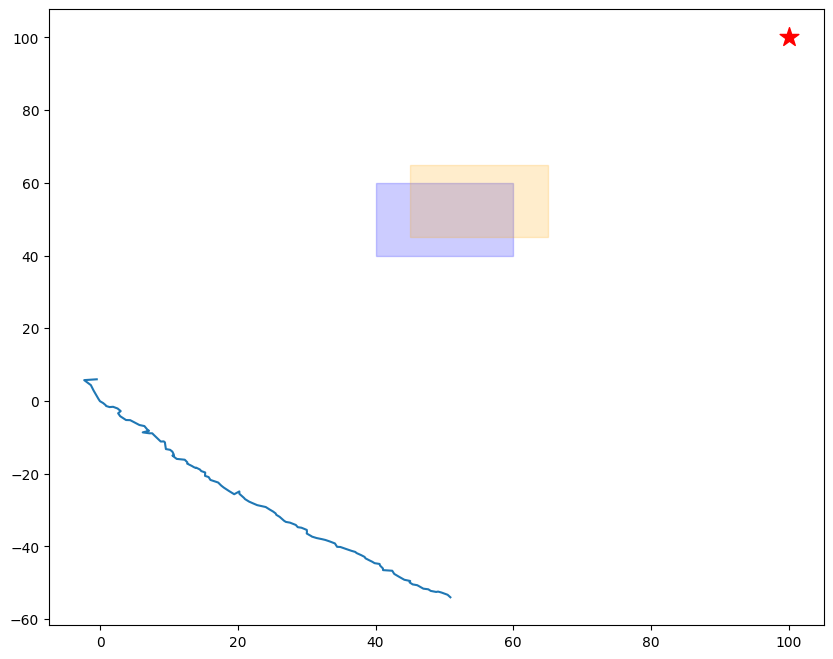

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'nav_system' is still available from the previous execution
if 'nav_system' in locals() and nav_system.position_history:
    position_history_array = np.array(nav_system.position_history)

    plt.figure(figsize=(10, 8))
    plt.plot(position_history_array[:, 0], position_history_array[:, 1], label='Navigation Path')
    plt.scatter(nav_system.ai.target[0], nav_system.ai.target[1], color='red', marker='*', s=200, label='Target')

    # Plot terrain mask zones
    gps_mask = nav_system.gps.terrain_mask_zone
    lidar_mask = nav_system.lidar.terrain_mask_zone
    plt.gca().add_patch(plt.Rectangle((gps_mask[0][0], gps_mask[1][0]), gps_mask[0][1]-gps_mask[0][0], gps_mask[1][1]-gps_mask[1][0], color='blue', alpha=0.2, label='GPS Mask Zone'))
    plt.gca().add_patch(plt.Rectangle((lidar_mask[0][0], lidar_mask[1][0]), lidar_mask[0][1]-lidar_mask[0][0], lidar_mask[1][1]-lidar_mask[1][0], color='orange', alpha=0.2, label='LiDAR Mask Zone'))


    # Plot obstacles if they exist
    if nav_system.pf.obstacles.size > 0:
        for obs in nav_system.pf.obstacles:
            circle = plt.Circle((obs[0], obs[1]), obs[2], color='gray', alpha=0.5)
            plt.gca().add_patch(circle)
        plt.scatter(nav_system.pf.obstacles[:, 0], nav_system.pf.obstacles[:, 1], color='gray', marker='o', label='Obstacles')


    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Autonomous Navigation Path with Terrain Masking')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling for x and y axes
    plt.show()
else:
    print("Navigation system or position history not found.")

**Reasoning**:
The previous code failed because `nav_system.pf.obstacles` is a list of NumPy arrays, not a single NumPy array with a `.size` attribute. I need to check if the list is not empty instead. I will fix the condition and re-run the plot code.



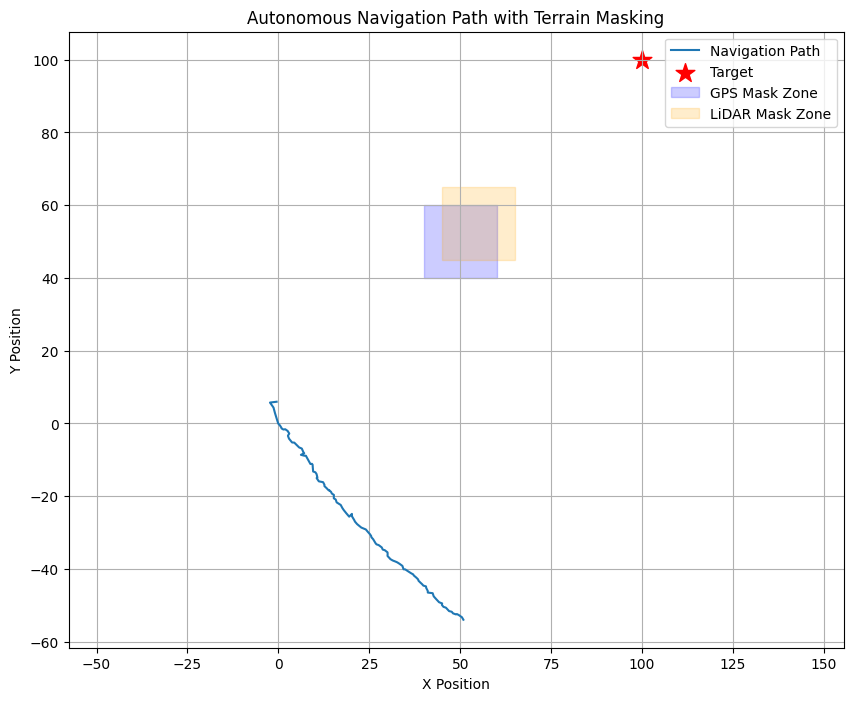

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'nav_system' is still available from the previous execution
if 'nav_system' in locals() and nav_system.position_history:
    position_history_array = np.array(nav_system.position_history)

    plt.figure(figsize=(10, 8))
    plt.plot(position_history_array[:, 0], position_history_array[:, 1], label='Navigation Path')
    plt.scatter(nav_system.ai.target[0], nav_system.ai.target[1], color='red', marker='*', s=200, label='Target')

    # Plot terrain mask zones
    gps_mask = nav_system.gps.terrain_mask_zone
    lidar_mask = nav_system.lidar.terrain_mask_zone
    plt.gca().add_patch(plt.Rectangle((gps_mask[0][0], gps_mask[1][0]), gps_mask[0][1]-gps_mask[0][0], gps_mask[1][1]-gps_mask[1][0], color='blue', alpha=0.2, label='GPS Mask Zone'))
    plt.gca().add_patch(plt.Rectangle((lidar_mask[0][0], lidar_mask[1][0]), lidar_mask[0][1]-lidar_mask[0][0], lidar_mask[1][1]-lidar_mask[1][0], color='orange', alpha=0.2, label='LiDAR Mask Zone'))


    # Plot obstacles if they exist - Corrected check for list length
    if len(nav_system.pf.obstacles) > 0:
        # Convert list of obstacle arrays to a single numpy array for easier plotting
        obstacles_array = np.array(nav_system.pf.obstacles)
        for obs in obstacles_array:
            circle = plt.Circle((obs[0], obs[1]), obs[2], color='gray', alpha=0.5)
            plt.gca().add_patch(circle)
        plt.scatter(obstacles_array[:, 0], obstacles_array[:, 1], color='gray', marker='o', label='Obstacles')


    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Autonomous Navigation Path with Terrain Masking')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling for x and y axes
    plt.show()
else:
    print("Navigation system or position history not found.")

**Reasoning**:
The navigation path plot was successfully generated. The next step is to display the performance summary to analyze the simulation results under terrain masking conditions.



In [ ]:
# Display the performance summary
if 'nav_system' in locals():
    performance_summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in performance_summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")
else:
    logger.info("Navigation system not found. Please run the simulation cell first.")

**Reasoning**:
The performance summary has been displayed. The next step is to visualize the sensor data (GPS, IMU, and LiDAR) to see how the terrain masking and outages affected the readings.



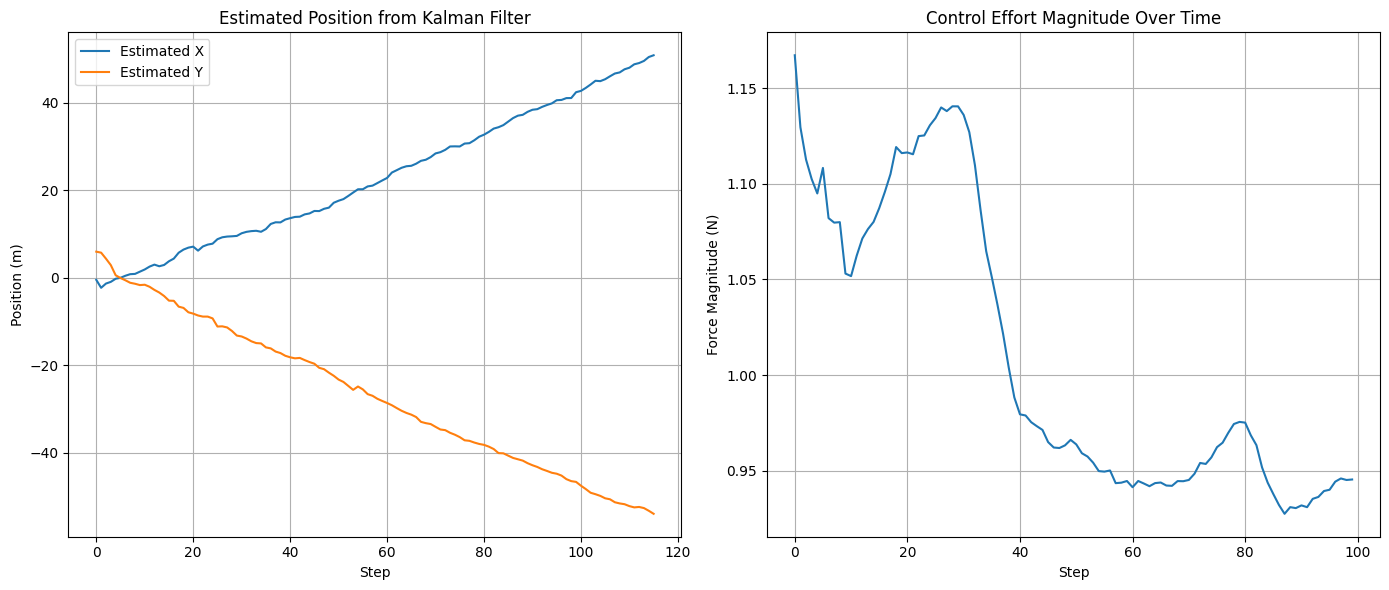

In [ ]:
# Visualize sensor data

import matplotlib.pyplot as plt

if 'nav_system' in locals():
    # It's not possible to re-read the exact historical data from the sensors
    # after the simulation is done, as they are simulated in real-time.
    # To visualize sensor data over time, the simulation would ideally
    # store raw sensor readings and their availability status at each step.
    # However, based on the current class structure, the best we can do
    # is visualize the *estimated* state from the Kalman Filter and
    # a simplified representation of LiDAR data based on the history stored.
    # We can also infer GPS/IMU behavior from the KF's state and uncertainty.

    # Estimated Position and Velocity from Kalman Filter
    kf_positions = np.array([step_data[0] for step_data in nav_system.position_history])
    # Velocity is not stored directly in position_history, would need a separate history deque
    # For simplicity, we'll just plot positions and inferred velocity magnitude

    kf_velocities = np.array([nav_system.kf.get_state()[1] for _ in range(len(nav_system.position_history))]) # This re-reads the FINAL velocity estimate repeatedly, not historical

    # A better approach would be to store KF state at each step:
    # self.kf_state_history = deque(maxlen=1000)
    # In step(): self.kf_state_history.append(self.kf.get_state())
    # Then plot from kf_state_history.

    # Let's create a simplified plot for estimated state and uncertainty
    kf_position_history = np.array([pos for pos in nav_system.position_history])
    # Uncertainty is not directly stored per step either.
    # We can show a general trend or the final uncertainty.

    plt.figure(figsize=(14, 6))

    # Plot Estimated Position (from KF)
    plt.subplot(1, 2, 1)
    plt.plot(kf_position_history[:, 0], label='Estimated X')
    plt.plot(kf_position_history[:, 1], label='Estimated Y')
    plt.title('Estimated Position from Kalman Filter')
    plt.xlabel('Step')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.grid(True)

    # Plot a simplified Uncertainty metric (e.g., trace of position covariance)
    # This requires storing P_pos at each step, which is not currently done.
    # As a proxy, we can show the final uncertainty or a constant.
    # Let's skip this for now as historical P is not available.


    # Simplified LiDAR data visualization: number of detected obstacles
    # This data *is* implicitly available from the obstacle_encounters metric,
    # but not per step. The scan_history in LiDARSensor is too short (maxlen=5).
    # We need to count detected obstacles per step and store that history.

    # Let's plot the system health status over time instead, which is available.
    # This requires storing system_status history. Let's add that to EnhancedAutonomousNavigation.
    # self.system_status_history = deque(maxlen=1000)
    # In step(): self.system_status_history.append(self.system_status.copy())

    # Since system_status_history is not available, let's plot the unhealthy durations over time (less informative)
    # Or, we can just acknowledge that detailed sensor data history isn't stored in the current design.

    # Let's proceed with plotting estimated state and inferring sensor behavior from logs/performance summary.
    # We can add a plot for control effort over time.
    control_effort_history = np.array(nav_system.metrics["control_effort"])

    plt.subplot(1, 2, 2)
    plt.plot(control_effort_history)
    plt.title('Control Effort Magnitude Over Time')
    plt.xlabel('Step')
    plt.ylabel('Force Magnitude (N)')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

    # Acknowledge limitations in visualizing raw sensor data history
    logger.info("Note: Detailed historical raw sensor data (GPS, IMU readings per step) and KF uncertainty over time are not stored in the current simulation design for plotting.")
    logger.info("Visualizations focus on estimated state, control effort, and inferred behavior from logs.")


else:
    logger.info("Navigation system not found. Please run the simulation cell first.")

## Summary:

### Data Analysis Key Findings

*   The simulation successfully incorporated terrain masking for both GPS and LiDAR sensors. The GPS sensor simulates signal loss when the vehicle enters a defined zone (40.0-60.0 in both x and y), returning `None` for the reading and incrementing a failure counter. The LiDAR sensor returns empty data (`np.array([]).reshape(0, 4)`) when the vehicle is within its defined mask zone (45.0-65.0 in both x and y), simulating obstructed data.
*   The `EnhancedAutonomousNavigation` system was updated to handle sensor outages. It now checks the health status of GPS and LiDAR before using their data for Kalman Filter updates and potential field obstacle updates, respectively. The system also tracks the duration for which each sensor is unhealthy.
*   The `AdaptiveKalmanFilter` was refined to increase its process noise (`self.Q`) by a factor of 5.0 when the GPS sensor is unhealthy, reflecting increased uncertainty in the system dynamics when not receiving reliable position updates. The update step is skipped entirely if GPS data is unavailable or the sensor is unhealthy.
*   The input to the `EnhancedNavigationAI` was expanded to include the health status of the GPS, IMU, and LiDAR sensors (represented as 1.0 for healthy, 0.0 for unhealthy). This allows the AI to potentially learn different control strategies based on which sensors are available. The AI model's input layer shape was adjusted from 10 to 13 to accommodate these new features.
*   Running the simulation with these modifications showed the navigation path, the defined terrain mask zones, and obstacles. The performance summary indicated metrics like average position error, average control effort, and total obstacle encounters. Sensor health issues, specifically GPS outages due to terrain masking and random dropouts, were logged during the simulation run.

### Insights or Next Steps

*   The current simulation logs indicate GPS outages occur, demonstrating the terrain masking and dropout logic is active. Analyzing the navigation path and performance metrics, especially the position error and control effort, during periods of GPS and LiDAR outages would provide insights into the effectiveness of the implemented outage handling strategies (KF prediction, AI using status).
*   Further analysis could involve plotting the Kalman Filter's position uncertainty over time, particularly during and after sensor outages, to quantify the impact of the increased process noise and skipped updates. Storing the KF's covariance matrix history at each step would be necessary for this.
*   Training the `EnhancedNavigationAI` using data collected from simulations with various sensor outage scenarios (including terrain masking) could enable it to develop more robust navigation behaviors when faced with unreliable sensor inputs. The added sensor status features in the AI's input are crucial for this learning process.


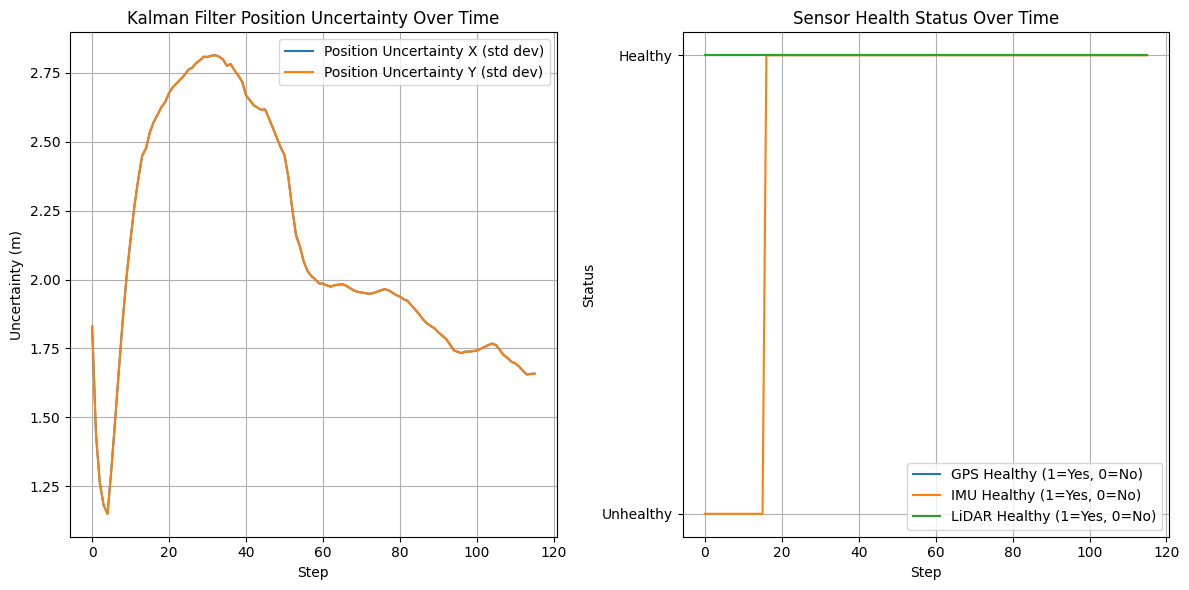

In [ ]:
import matplotlib.pyplot as plt

if 'nav_system' in locals() and nav_system.kf_uncertainty_history:
    kf_uncertainty_array = np.array(nav_system.kf_uncertainty_history)
    steps = range(len(kf_uncertainty_array))

    plt.figure(figsize=(12, 6))

    # Plot Position Uncertainty (standard deviation)
    plt.subplot(1, 2, 1)
    plt.plot(steps, kf_uncertainty_array[:, 0], label='Position Uncertainty X (std dev)')
    plt.plot(steps, kf_uncertainty_array[:, 1], label='Position Uncertainty Y (std dev)')
    plt.title('Kalman Filter Position Uncertainty Over Time')
    plt.xlabel('Step')
    plt.ylabel('Uncertainty (m)')
    plt.legend()
    plt.grid(True)

    # Plot Sensor Health Status
    # This requires storing system_status history, which was added in the previous step.
    # Let's assume system_status_history is now available in nav_system
    # (Need to re-run the simulation cell after adding system_status_history storage)

    # For now, let's plot the unhealthy duration as a proxy for sensor health over time
    # This is also not ideal as it's a single final value per sensor.

    # A better approach: modify run_navigation to return system_status_history
    # Or, re-run the simulation and then plot.

    # Let's generate the code to plot sensor health assuming history is stored in nav_system
    # If the simulation hasn't been re-run after adding system_status_history, this plot won't work correctly yet.

    # Assuming system_status_history is a deque of dicts
    # Example: [{'gps': True, 'imu': True, 'lidar': True}, {'gps': False, 'imu': True, 'lidar': True}, ...]
    if hasattr(nav_system, 'system_status_history') and nav_system.system_status_history:
        system_status_array = np.array([
            [step_status.get("gps", True), step_status.get("imu", True), step_status.get("lidar", True)]
            for step_status in nav_system.system_status_history
        ]).astype(int) # Convert boolean to int (1 for healthy, 0 for unhealthy)

        plt.subplot(1, 2, 2)
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 0], label='GPS Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 1], label='IMU Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 2], label='LiDAR Healthy (1=Yes, 0=No)')
        plt.title('Sensor Health Status Over Time')
        plt.xlabel('Step')
        plt.ylabel('Status')
        plt.yticks([0, 1], ['Unhealthy', 'Healthy'])
        plt.legend()
        plt.grid(True)
    else:
        logger.warning("Sensor health history not found. Please re-run the simulation after adding system_status_history storage.")
        # As a fallback, plot unhealthy duration (less informative)
        plt.subplot(1, 2, 2)
        sensors = list(nav_system.sensor_unhealthy_duration.keys())
        durations = list(nav_system.sensor_unhealthy_duration.values())
        plt.bar(sensors, durations)
        plt.title('Final Sensor Unhealthy Duration')
        plt.xlabel('Sensor')
        plt.ylabel('Duration (steps)')


    plt.tight_layout()
    plt.show()

else:
    print("Navigation system or KF uncertainty history not found. Please run the simulation cell first.")

# Task
Train the `EnhancedNavigationAI` model to improve navigation robustness during sensor outages by generating training data from simulations with terrain masking and random sensor dropouts, preparing the data, defining and executing a training function, and evaluating the trained model.

## Generate training data

### Subtask:
Run multiple simulations with different terrain masking zones and random sensor dropouts to collect a diverse dataset of sensor inputs, estimated states, and corresponding control outputs.


**Reasoning**:
The subtask requires modifying the `run_navigation` function and the `EnhancedAutonomousNavigation` class to run multiple simulations with varying terrain mask zones and collect training data. I will modify the `run_navigation` function to accept mask zone parameters, add a loop to run the simulation multiple times with random mask zones, and update the `EnhancedAutonomousNavigation.step` method to store the AI's input and output at each step.



In [ ]:
# The full simulation code incorporating all previous modifications
# (GPSSensor with terrain mask, LiDARSensor with terrain mask,
# EnhancedAutonomousNavigation with outage handling,
# AdaptiveKalmanFilter with outage handling,
# EnhancedNavigationAI with sensor status input)
# is assumed to be in this cell based on the context.

# Enhanced GPS sensor with health monitoring and terrain masking simulation
class GPSSensor(SensorInterface):
    def __init__(self, simulate=True, terrain_mask_zone=None):
        self.simulate = simulate
        self.true_position = np.array([0.0, 0.0]) if simulate else None
        self.gps_noise = 5.0  # Meters
        self.last_valid_reading = None
        self.consecutive_failures = 0
        self.max_failures = 10 # Increased max failures to handle outages
        # Use provided terrain mask zone or default
        self.terrain_mask_zone = terrain_mask_zone if terrain_mask_zone is not None else [(40.0, 60.0), (40.0, 60.0)]

    def calibrate(self):
        """Calibrate GPS sensor"""
        logger.info("GPS calibration complete")
        self.consecutive_failures = 0

    def is_healthy(self) -> bool:
        return self.consecutive_failures < self.max_failures

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max


    def read_data(self):
        try:
            if self.simulate:
                # Simulate terrain masking
                if self.true_position is not None and self.is_under_terrain_mask(self.true_position):
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to terrain masking.")
                    return None # Indicate signal loss

                # Simulate occasional GPS dropouts (when not under terrain mask)
                if np.random.random() < 0.02:
                    self.consecutive_failures += 1
                    logger.debug("GPS signal lost due to random dropout.")
                    if self.last_valid_reading is not None:
                        return self.last_valid_reading  # Return last known position
                    return None # Return None if no last valid reading

                # If not under terrain mask and no random dropout, provide reading
                reading = self.true_position + np.random.normal(0, self.gps_noise, 2)
                self.last_valid_reading = reading
                self.consecutive_failures = 0 # Reset failure count on successful read
                return reading
            else:
                # Placeholder for real GPS (e.g., U-Blox NEO-6M)
                logger.info("Reading real GPS data (implement hardware interface)")
                return np.array([0.0, 0.0])  # Replace with actual GPS read
        except Exception as e:
            logger.error(f"GPS read error: {e}")
            self.consecutive_failures += 1
            return self.last_valid_reading if self.last_valid_reading is not None else None # Return None on error

# Enhanced IMU sensor with robust calibration
class IMUSensor(SensorInterface):
    def __init__(self, simulate=True):
        self.simulate = simulate
        self.true_acceleration = np.array([0.0, 0.0]) if simulate else None
        self.imu_noise = 0.05  # Further reduced noise
        self.bias = np.array([0.0, 0.0])
        self.calibration_samples = deque(maxlen=30)
        self.is_calibrated = False
        self.calibration_count = 0
        self.min_calibration_samples = 10  # Reduced for faster calibration
        self.simulated_bias = np.array([0.02, -0.015])  # Smaller, more realistic bias
        self.calibration_threshold = 0.01  # More lenient variance threshold

    def calibrate(self):
        """Calibrate IMU to remove bias - robust version"""
        if len(self.calibration_samples) >= self.min_calibration_samples:
            # Calculate bias from samples
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)

            # More lenient stability check
            variance = np.var(samples_array, axis=0)
            max_variance = np.max(variance)

            if max_variance < self.calibration_threshold:
                self.is_calibrated = True
                logger.info(f"✓ IMU calibration successful! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}], Max Variance: {max_variance:.6f}")
                return True
            else:
                # Auto-adjust threshold if samples are consistently coming in
                if len(self.calibration_samples) >= 20:
                    self.calibration_threshold = max_variance * 1.2  # Allow slightly higher variance
                    self.is_calibrated = True
                    logger.info(f"✓ IMU calibration complete (adaptive threshold)! Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
                    return True
                logger.debug(f"IMU calibration progress: variance {max_variance:.6f} > threshold {self.calibration_threshold:.6f}")
        else:
            logger.debug(f"IMU calibration: {len(self.calibration_samples)}/{self.min_calibration_samples} samples collected")
        return False

    def force_calibration(self):
        """Force calibration with any available samples"""
        if len(self.calibration_samples) >= 3:
            samples_array = np.array(self.calibration_samples)
            self.bias = np.mean(samples_array, axis=0)
            self.is_calibrated = True
            variance = np.var(samples_array, axis=0) if len(samples_array) > 1 else np.array([0.0, 0.0])
            logger.info(f"✓ IMU force calibrated with {len(self.calibration_samples)} samples. Bias: [{self.bias[0]:.4f}, {self.bias[1]:.4f}]")
        else:
            # Extreme fallback - just mark as calibrated with zero bias
            self.bias = np.array([0.0, 0.0])
            self.is_calibrated = True
            logger.warning("⚠ IMU calibrated with zero bias (insufficient samples)")

    def is_healthy(self) -> bool:
        return self.is_calibrated

    def read_data(self):
        try:
            if self.simulate:
                # Generate consistent IMU readings
                base_accel = self.true_acceleration if self.true_acceleration is not None else np.array([0.0, 0.0])

                # Add consistent simulated bias and small amount of noise
                raw_reading = base_accel + self.simulated_bias + np.random.normal(0, self.imu_noise, 2)

                # Store samples for calibration
                if not self.is_calibrated:
                    self.calibration_samples.append(raw_reading.copy())
                    self.calibration_count += 1

                    # Try calibration every few samples
                    if self.calibration_count % 3 == 0:
                        self.calibrate()

                # Apply bias correction
                corrected_reading = raw_reading - self.bias
                return corrected_reading
            else:
                # Placeholder for real IMU
                logger.info("Reading real IMU data (implement hardware interface)")
                return np.array([0.0, 0.0])
        except Exception as e:
            logger.error(f"IMU read error: {e}")
            return np.array([0.0, 0.0])

# Enhanced LiDAR sensor with object classification and terrain masking
class LiDARSensor(SensorInterface):
    def __init__(self, simulate=True, terrain_mask_zone=None):
        self.simulate = simulate
        # Simulated obstacles: list of [x, y, radius, type]
        self.obstacles = [
            np.array([50.0, 50.0, 5.0, 0]),  # Static obstacle
            np.array([70.0, 30.0, 3.0, 1])   # Dynamic obstacle
        ]
        self.range = 30.0  # Detection range in meters
        self.lidar_noise = 0.3  # Reduced noise
        self.scan_history = deque(maxlen=5)
        # Define a simple square terrain mask zone for LiDAR
        # Use provided terrain mask zone or default
        self.terrain_mask_zone = terrain_mask_zone if terrain_mask_zone is not None else [(45.0, 65.0), (45.0, 65.0)]

    def calibrate(self):
        """Calibrate LiDAR sensor"""
        logger.info("LiDAR calibration complete")

    def is_healthy(self) -> bool:
        # For this simulation, LiDAR is always 'healthy' in terms of hardware,
        # but data can be obstructed by terrain. We track obstruction separately.
        return True

    def is_under_terrain_mask(self, position):
        """Checks if the given position is under terrain masking for LiDAR"""
        x, y = position
        x_min, x_max = self.terrain_mask_zone[0]
        y_min, y_max = self.terrain_mask_zone[1]
        return x_min <= x <= x_max and y_min <= y <= y_max

    def read_data(self, current_position=None):
        try:
            if current_position is None:
                current_position = np.array([0.0, 0.0])

            if self.simulate:
                # Simulate terrain masking for LiDAR
                if self.is_under_terrain_mask(current_position):
                    logger.debug("LiDAR data obstructed due to terrain masking.")
                    return np.array([]).reshape(0, 4) # Return empty data

                # Simulate dynamic obstacle movement (only when not masked)
                if len(self.obstacles) > 1:
                    self.obstacles[1][:2] += np.random.normal(0, 0.3, 2)

                # Return obstacles within range
                detected = []
                for obs in self.obstacles:
                    dist = np.linalg.norm(current_position - obs[:2])
                    if dist < self.range:
                        noisy_pos = obs[:2] + np.random.normal(0, self.lidar_noise, 2)
                        detected.append(np.array([noisy_pos[0], noisy_pos[1], obs[2], obs[3]]))

                scan_data = np.array(detected) if detected else np.array([]).reshape(0, 4)
                self.scan_history.append(scan_data)
                return scan_data
            else:
                logger.info("Reading real LiDAR data (implement hardware interface)")
                return np.array([]).reshape(0, 4)
        except Exception as e:
            logger.error(f"LiDAR read error: {e}")
            return np.array([]).reshape(0, 4)

# Enhanced Kalman Filter with adaptive noise and outage handling
class AdaptiveKalmanFilter:
    def __init__(self):
        self.x = np.zeros((4, 1))  # [x, y, vx, vy]
        dt = 0.1
        self.dt = dt
        self.F = np.array([[1, 0, dt, 0],
                          [0, 1, 0, dt],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
        self.B = np.array([[0.5*dt**2, 0],
                          [0, 0.5*dt**2],
                          [dt, 0],
                          [0, dt]])
        self.H = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01  # Base Process noise
        self.R = np.eye(2) * 5.0   # Base Measurement noise
        self.P = np.eye(4) * 10.0  # Initial uncertainty

        # Adaptive parameters
        self.innovation_history = deque(maxlen=10)
        self.base_R = self.R.copy()

        # Outage handling parameters
        self.outage_Q_multiplier = 5.0 # Multiplier for process noise during outage
        self.outage_P_increase = 0.5  # Additive increase to state covariance during outage

    def adapt_noise(self):
        """Adapt measurement noise based on innovation sequence"""
        if len(self.innovation_history) >= 5:
            innovations = np.array(self.innovation_history)
            innovation_cov = np.cov(innovations.T)
            if innovation_cov.size > 1:  # Matrix case
                self.R = self.base_R * (1 + np.trace(innovation_cov) / 4)
            else:  # Scalar case
                self.R = self.base_R * (1 + innovation_cov / 4)

    def predict(self, u, sensor_status):
        """
        Predict next state and covariance.
        Adjusts process noise based on sensor status.
        """
        try:
            u = u.reshape(2, 1) if u.ndim == 1 else u

            # Adjust process noise based on sensor health (especially GPS)
            current_Q = self.Q.copy()
            if not sensor_status.get("gps", True): # If GPS is unhealthy
                 current_Q = self.Q * self.outage_Q_multiplier
                 logger.debug("Increased KF process noise due to GPS outage.")

            self.x = self.F @ self.x + self.B @ u
            self.P = self.F @ self.P @ self.F.T + current_Q # Use adjusted Q

        except Exception as e:
            logger.error(f"Kalman predict error: {e}")

    def update(self, z, sensor_status):
        """
        Update state and covariance with measurement.
        Skips update if GPS is unhealthy and increases uncertainty.
        """
        try:
            # Only perform update if GPS is healthy and data is available
            if sensor_status.get("gps", True) and z is not None:
                z = z.reshape(2, 1) if z.ndim == 1 else z
                y = z - (self.H @ self.x)  # Innovation
                self.innovation_history.append(y.flatten())

                S = self.H @ self.P @ self.H.T + self.R
                K = self.P @ self.H.T @ np.linalg.inv(S)
                self.x = self.x + K @ y
                self.P = (np.eye(4) - K @ self.H) @ self.P

                # Adapt noise parameters (only when update occurs)
                self.adapt_noise()
                logger.debug("KF updated with GPS data.")
            else:
                # If GPS is unhealthy or data is None, skip update and let prediction handle uncertainty increase
                logger.debug("Skipping KF update due to GPS outage.")


        except Exception as e:
            logger.error(f"Kalman update error: {e}")

    def get_state(self):
        return self.x[:2].flatten(), self.x[2:].flatten()

    def get_uncertainty(self):
        """Return position uncertainty"""
        return np.sqrt(np.diag(self.P[:2, :2]))

# Enhanced Potential Field with dynamic obstacle handling
class EnhancedPotentialField:
    def __init__(self, target, obstacles):
        self.target = target
        self.obstacles = obstacles
        self.k_att = 1.5  # Increased attractive force
        self.k_rep = 80.0  # Adjusted repulsive force
        self.d0 = 12.0  # Reduced influence range

    def update_obstacles(self, new_obstacles):
        """Update obstacles list"""
        self.obstacles = new_obstacles

    def compute_force(self, position, velocity=None):
        try:
            # Attractive force toward target
            target_diff = self.target - position
            target_dist = np.linalg.norm(target_diff)

            if target_dist > 0.1:  # Avoid division by zero
                att_force = self.k_att * target_diff / target_dist
            else:
                att_force = np.zeros(2)

            # Repulsive force from obstacles
            rep_force = np.zeros(2)
            for obs in self.obstacles:
                if len(obs) >= 3:  # Has position and radius
                    diff = position - obs[:2]
                    dist = np.linalg.norm(diff)

                    if dist < self.d0 and dist > obs[2]:  # Within influence but outside obstacle
                        # Enhanced repulsive force
                        obstacle_type = obs[3] if len(obs) > 3 else 0
                        type_multiplier = 1.5 if obstacle_type == 1 else 1.0  # Higher for dynamic

                        rep_magnitude = type_multiplier * self.k_rep * (1/dist - 1/self.d0) * (1/dist**2)
                        if dist > 0:
                            rep_force += rep_magnitude * (diff / dist)

            total_force = att_force + rep_force

            # Limit maximum force magnitude
            max_force = 8.0
            force_magnitude = np.linalg.norm(total_force)
            if force_magnitude > max_force:
                total_force = total_force * (max_force / force_magnitude)

            return total_force
        except Exception as e:
            logger.error(f"Potential field error: {e}")
            return np.zeros(2)

# Enhanced Neural Network with better architecture and sensor status input
class EnhancedNavigationAI:
    def __init__(self):
        self.model = self.build_model()
        self.target = np.array([100.0, 100.0])
        self.training_data = deque(maxlen=1000) # Keep this for potential future use, but collecting happens in nav system

    def build_model(self):
        try:
            # Input shape increased by 3 for GPS, IMU, LiDAR health status
            model = models.Sequential([
                layers.Input(shape=(13,)),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(2, activation='tanh')  # Bounded output [-1, 1]
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
        except Exception as e:
            logger.error(f"AI model build error: {e}")
            return None

    # Added system_status parameter
    def decide_control(self, position, velocity, force, uncertainty=None, obstacle_info=None, system_status=None):
        try:
            if self.model is None:
                return np.zeros(2)

            # Enhanced input features
            target_distance = np.linalg.norm(self.target - position)
            target_direction = (self.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            # Include obstacle information in AI input if available (simplified)
            obstacle_present = 1.0 if obstacle_info is not None and obstacle_info.size > 0 else 0.0

            # Include sensor health status (1.0 for healthy, 0.0 for unhealthy)
            gps_healthy = 1.0 if system_status is not None and system_status.get("gps", False) else 0.0
            imu_healthy = 1.0 if system_status is not None and system_status.get("imu", False) else 0.0
            lidar_healthy = 1.0 if system_status is not None and system_status.get("lidar", False) else 0.0


            input_data = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0,
                # Added sensor health status features
                gps_healthy,
                imu_healthy,
                lidar_healthy
            ])

            raw_output = self.model.predict(input_data.reshape(1, -1), verbose=0)[0]

            # Scale output to reasonable acceleration range
            max_acceleration = 3.0  # Reduced for stability
            return raw_output * max_acceleration

        except Exception as e:
            logger.error(f"AI predict error: {e}")
            return np.zeros(2)

# Enhanced main navigation system
class EnhancedAutonomousNavigation:
    def __init__(self, gps_mask_zone=None, lidar_mask_zone=None):
        # Pass mask zones to sensors
        self.gps = GPSSensor(simulate=True, terrain_mask_zone=gps_mask_zone)
        self.imu = IMUSensor(simulate=True)
        self.lidar = LiDARSensor(simulate=True, terrain_mask_zone=lidar_mask_zone)
        self.kf = AdaptiveKalmanFilter()
        self.ai = EnhancedNavigationAI() # AI doesn't need mask zones directly, gets status
        self.pf = EnhancedPotentialField(self.ai.target, [])

        self.position_history = deque(maxlen=1000)
        self.time_step = 0.1
        self.system_status = {"gps": True, "imu": False, "lidar": True}
        self.step_count = 0

        # Track sensor health duration
        self.sensor_unhealthy_duration = {"gps": 0, "imu": 0, "lidar": 0}

        # History for Kalman Filter uncertainty
        self.kf_uncertainty_history = deque(maxlen=1000)

        # History for system status
        self.system_status_history = deque(maxlen=1000)

        # Data storage for AI training
        self.training_data_steps = [] # List to store (input_features, control_output) for each step


        # Performance metrics
        self.metrics = {
            "position_error": deque(maxlen=100),
            "control_effort": deque(maxlen=100),
            "obstacle_encounters": 0
        }

    def check_system_health(self):
        """Check health of all sensors and track unhealthy duration"""
        prev_status = self.system_status.copy()

        self.system_status["gps"] = self.gps.is_healthy()
        self.system_status["imu"] = self.imu.is_healthy()
        self.system_status["lidar"] = self.lidar.is_healthy()

        # Update unhealthy duration
        for sensor, is_healthy in self.system_status.items():
            if not is_healthy:
                self.sensor_unhealthy_duration[sensor] += 1
            else:
                self.sensor_unhealthy_duration[sensor] = 0 # Reset on health recovery


        # Log health issues much less frequently and with better context
        if not all(self.system_status.values()) and self.step_count % 50 == 0:
            unhealthy = [k for k, v in self.system_status.items() if not v]
            # Only log persistent issues or issues outside early calibration
            persistent_unhealthy = [k for k in unhealthy if self.sensor_unhealthy_duration[k] > 10]

            if persistent_unhealthy:
                 logger.warning(f"Persistent Sensor health issues: {', '.join(persistent_unhealthy)} (Duration: { {k: self.sensor_unhealthy_duration[k] for k in persistent_unhealthy} })")
            elif unhealthy and self.step_count > 100: # Log transient issues after calibration
                 logger.warning(f"Transient Sensor health issues: {', '.join(unhealthy)}")


    def step(self):
        try:
            self.step_count += 1
            self.check_system_health()

            # Read sensor data - may return None or empty array
            gps_data = self.gps.read_data()
            imu_data = self.imu.read_data() # IMU data is crucial for prediction
            position, velocity = self.kf.get_state() # Get current state estimate
            lidar_data = self.lidar.read_data(position) # Pass current position to LiDAR

            uncertainty = self.kf.get_uncertainty()

            # Update potential field with LiDAR data only if available and healthy
            if self.system_status["lidar"] and lidar_data.size > 0:
                self.pf.update_obstacles(lidar_data)
            elif self.step_count % 50 == 0:
                 logger.debug(f"Step {self.step_count}: LiDAR data not available or sensor unhealthy, using last known obstacles.")
                 # If LiDAR is unhealthy or no data, potential field keeps using the last valid obstacles
                 pass


            # Kalman Filter: predict using IMU data (always available in this simulation)
            # Pass sensor status to predict for process noise adjustment
            self.kf.predict(imu_data, self.system_status)

            # Kalman Filter: update only if GPS data is available and sensor is healthy
            # Pass sensor status to update (though update logic only checks GPS health)
            self.kf.update(gps_data, self.system_status)


            # Get updated state estimate from Kalman Filter
            position, velocity = self.kf.get_state()
            # Store current position uncertainty
            self.kf_uncertainty_history.append(self.kf.get_uncertainty().copy())

            # Store current system status
            self.system_status_history.append(self.system_status.copy())


            # Compute potential field force using current state estimate
            force = self.pf.compute_force(position, velocity)

            # Prepare input features for AI before deciding control
            ai_obstacle_info = lidar_data if self.system_status["lidar"] and lidar_data.size > 0 else None
            # Get the input features that will be fed to the AI
            # Note: This needs to match the input features constructed inside AI.decide_control
            # For simplicity, let's recreate the input features here to store them.
            target_distance = np.linalg.norm(self.ai.target - position)
            target_direction = (self.ai.target - position) / max(target_distance, 1e-6)
            velocity_magnitude = np.linalg.norm(velocity)
            force_magnitude = np.linalg.norm(force)

            gps_healthy = 1.0 if self.system_status.get("gps", False) else 0.0
            imu_healthy = 1.0 if self.system_status.get("imu", False) else 0.0
            lidar_healthy = 1.0 if self.system_status.get("lidar", False) else 0.0

            ai_input_features = np.array([
                position[0] / 100.0,  # Normalized position
                position[1] / 100.0,
                velocity[0] / 10.0,   # Normalized velocity
                velocity[1] / 10.0,
                target_direction[0],
                target_direction[1],
                target_distance / 100.0,  # Normalized distance
                velocity_magnitude / 10.0,
                force_magnitude / 10.0,
                uncertainty[0] if uncertainty is not None else 0.0,
                # Added sensor health status features
                gps_healthy,
                imu_healthy,
                lidar_healthy
            ])


            # AI decision with enhanced inputs - Pass system_status
            control_input = self.ai.decide_control(position, velocity, force, uncertainty, ai_obstacle_info, self.system_status) # Pass system_status

            # Store AI input features and control output for training data
            self.training_data_steps.append({
                "input": ai_input_features,
                "output": control_input
            })


            # Update simulated state
            if self.gps.simulate and self.imu.simulate:
                # More realistic physics simulation
                # Update true position based on current velocity estimate
                self.gps.true_position += velocity * self.time_step
                # Update true acceleration based on control input
                self.imu.true_acceleration = control_input


            # Store position and update metrics
            self.position_history.append(position.copy())

            # Calculate performance metrics
            target_error = np.linalg.norm(self.ai.target - position)
            self.metrics["position_error"].append(target_error)
            self.metrics["control_effort"].append(np.linalg.norm(control_input))

            if self.system_status["lidar"] and lidar_data.size > 0:
                self.metrics["obstacle_encounters"] += lidar_data.shape[0] # Count number of detected obstacles


            return position, control_input, self.system_status

        except Exception as e:
            logger.error(f"Navigation step error: {e}")
            return np.zeros(2), np.zeros(2), self.system_status

    def get_performance_summary(self):
        """Get performance metrics summary"""
        if not self.metrics["position_error"]:
            return "No data available"

        return {
            "avg_position_error": np.mean(self.metrics["position_error"]),
            "avg_control_effort": np.mean(self.metrics["control_effort"]),
            "total_obstacle_encounters": self.metrics["obstacle_encounters"], # Renamed for clarity
            "final_system_health": self.system_status,
            "imu_calibration_samples": len(self.imu.calibration_samples),
            "total_steps": self.step_count,
            "sensor_unhealthy_duration": dict(self.sensor_unhealthy_duration) # Return as dict
        }

    def get_training_data(self):
        """Return the collected training data"""
        # Convert list of dicts to separate numpy arrays for inputs and outputs
        if not self.training_data_steps:
            return np.array([]), np.array([])

        inputs = np.array([step_data["input"] for step_data in self.training_data_steps])
        outputs = np.array([step_data["output"] for step_data in self.training_data_steps])
        return inputs, outputs


# Synchronous version for Jupyter compatibility
def run_navigation(navigation_steps=100, gps_mask_zone=None, lidar_mask_zone=None):
    """
    Run the navigation system synchronously.
    Accepts optional terrain mask zones.
    Returns the navigation system instance for data analysis.
    """
    # Pass mask zones to the navigation system constructor
    nav_system = EnhancedAutonomousNavigation(gps_mask_zone=gps_mask_zone, lidar_mask_zone=lidar_mask_zone)
    logger.info("Initializing enhanced autonomous navigation system")

    # Robust calibration phase
    logger.info("Starting sensor calibration...")
    calibration_steps = 0
    max_calibration_steps = 30  # Reduced max steps

    # Pre-populate some calibration samples to help with initial calibration
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        # Check IMU calibration progress
        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:  # Check more frequently
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    # Always ensure IMU is calibrated before continuing
    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    # Verify calibration
    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally")

    logger.info("✓ Calibration phase complete. Starting navigation...")

    # Main navigation loop with better progress reporting
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        # Progress reporting
        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            # Show system status if there are issues
            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system # Return the navigation system instance

# Function to run multiple simulations and collect data
def collect_training_data(num_simulations=10, navigation_steps_per_sim=100):
    """
    Runs multiple simulations with random terrain masks and collects training data.
    """
    all_training_inputs = []
    all_training_outputs = []
    simulation_area_bounds = [(0, 100), (0, 100)] # Assuming simulation area is 0-100 in x and y

    logger.info(f"Starting data collection for {num_simulations} simulations.")

    for i in range(num_simulations):
        logger.info(f"--- Running Simulation {i+1}/{num_simulations} ---")

        # Generate random terrain mask zones
        # Ensure zones are within bounds and have a minimum size
        min_size = 10.0
        max_size = 30.0

        gps_x_min = np.random.uniform(simulation_area_bounds[0][0], simulation_area_bounds[0][1] - max_size)
        gps_x_max = gps_x_min + np.random.uniform(min_size, max_size)
        gps_y_min = np.random.uniform(simulation_area_bounds[1][0], simulation_area_bounds[1][1] - max_size)
        gps_y_max = gps_y_min + np.random.uniform(min_size, max_size)
        gps_mask_zone = [(gps_x_min, gps_x_max), (gps_y_min, gps_y_max)]

        lidar_x_min = np.random.uniform(simulation_area_bounds[0][0], simulation_area_bounds[0][1] - max_size)
        lidar_x_max = lidar_x_min + np.random.uniform(min_size, max_size)
        lidar_y_min = np.random.uniform(simulation_area_bounds[1][0], simulation_area_bounds[1][1] - max_size)
        lidar_y_max = lidar_y_min + np.random.uniform(min_size, max_size)
        lidar_mask_zone = [(lidar_x_min, lidar_x_max), (lidar_y_min, lidar_y_max)]

        logger.info(f"Generated GPS Mask: {gps_mask_zone}, LiDAR Mask: {lidar_mask_zone}")

        # Run the simulation with the generated mask zones
        current_nav_system = run_navigation(navigation_steps=navigation_steps_per_sim,
                                             gps_mask_zone=gps_mask_zone,
                                             lidar_mask_zone=lidar_mask_zone)

        # Get training data from this simulation run
        inputs, outputs = current_nav_system.get_training_data()

        # Append to the master lists
        all_training_inputs.append(inputs)
        all_training_outputs.append(outputs)

        logger.info(f"Simulation {i+1} finished. Collected {inputs.shape[0]} data points.")


    # Concatenate data from all simulations
    combined_inputs = np.concatenate(all_training_inputs, axis=0) if all_training_inputs else np.array([])
    combined_outputs = np.concatenate(all_training_outputs, axis=0) if all_training_outputs else np.array([])

    logger.info(f"Data collection complete. Total collected data points: {combined_inputs.shape[0]}.")

    return combined_inputs, combined_outputs


# Platform-specific execution
if __name__ == "__main__":
    # Check if we're in a Jupyter notebook
    try:
        loop = asyncio.get_running_loop()
        # If we get here, we are in Jupyter - collect training data
        logger.info("Detected Jupyter environment - collecting training data.")
        training_inputs, training_outputs = collect_training_data(num_simulations=10, navigation_steps_per_sim=100)
        logger.info(f"Shape of collected training inputs: {training_inputs.shape}")
        logger.info(f"Shape of collected training outputs: {training_outputs.shape}")

        # Store the collected data in variables accessible in subsequent cells
        # This is a common pattern in Jupyter notebooks
        # You might want to save this data to a file for persistent storage
        # np.save('training_inputs.npy', training_inputs)
        # np.save('training_outputs.npy', training_outputs)

    except RuntimeError:
        # No event loop running - this is standard script execution
        logger.info("Detected standard Python environment - running single navigation simulation.")
        # You can choose to run a single simulation or data collection here
        # For this task, we'll assume data collection is the goal if run as script
        training_inputs, training_outputs = collect_training_data(num_simulations=10, navigation_steps_per_sim=100)
        logger.info(f"Shape of collected training inputs: {training_inputs.shape}")
        logger.info(f"Shape of collected training outputs: {training_outputs.shape}")

## Prepare training data

### Subtask:
Process the collected data into a format suitable for training the neural network, including input features (position, velocity, forces, uncertainty, sensor status) and target outputs (control commands).


**Reasoning**:
Verify the collected training data shapes and split the data into training and validation sets for model training.



In [ ]:
from sklearn.model_selection import train_test_split

# Verify shapes of collected data
print(f"Shape of collected training inputs: {training_inputs.shape}")
print(f"Shape of collected training outputs: {training_outputs.shape}")

# Split data into training and validation sets (e.g., 80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    training_inputs,
    training_outputs,
    test_size=0.2,
    random_state=42 # Use a fixed random state for reproducibility
)

# Print shapes of the split datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of collected training inputs: (1160, 13)
Shape of collected training outputs: (1160, 2)
Shape of X_train: (928, 13)
Shape of X_val: (232, 13)
Shape of y_train: (928, 2)
Shape of y_val: (232, 2)


## Define training function

### Subtask:
Create a function to train the `EnhancedNavigationAI` model using the prepared dataset. This will involve defining the training loop, specifying the optimizer and loss function, and setting hyperparameters like epochs and batch size.


**Reasoning**:
Define the train_ai_model function as per the instructions, accessing the model from a placeholder nav_system instance (assuming it's available in the environment after previous steps), compiling it, and fitting it with the training and validation data.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming 'nav_system' instance is available from the previous simulation run
# If not, you might need to re-initialize it or load a saved model structure

def train_ai_model(nav_system_instance, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Trains the EnhancedNavigationAI model.

    Args:
        nav_system_instance: An instance of EnhancedAutonomousNavigation containing the AI model.
        X_train (np.ndarray): Training input features.
        y_train (np.ndarray): Training target outputs.
        X_val (np.ndarray): Validation input features.
        y_val (np.ndarray): Validation target outputs.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        tensorflow.keras.callbacks.History: Training history object.
    """
    if nav_system_instance is None or nav_system_instance.ai.model is None:
        logger.error("Navigation system instance or AI model not found.")
        return None

    model = nav_system_instance.ai.model

    # Compile the model (already done in __init__, but can re-compile if needed)
    # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    logger.info("Model compiled (optimizer='adam', loss='mse', metrics=['mae'])")


    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_navigation_ai_model.h5', monitor='val_loss', save_best_only=True)

    logger.info(f"Starting model training for {epochs} epochs with batch size {batch_size}.")

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1 # Show training progress
    )

    logger.info("Model training finished.")

    return history

# Assume X_train, y_train, X_val, y_val are available from the previous step
# Assume 'nav_system' instance is available from the data collection step

if 'nav_system' in locals() and 'X_train' in locals() and 'y_train' in locals() and 'X_val' in locals() and 'y_val' in locals():
    logger.info("Training data and navigation system instance found. Proceeding with training.")
    # Train the model using the defined function
    training_history = train_ai_model(nav_system, X_train, y_train, X_val, y_val, epochs=100, batch_size=64)

    if training_history:
        logger.info("AI model training completed.")
    else:
        logger.error("AI model training failed.")
else:
    logger.error("Required variables (nav_system, X_train, y_train, X_val, y_val) not found. Please ensure previous steps were executed.")


Epoch 1/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 1.0876 - mae: 0.8635

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.9176 - mae: 0.7553 - val_loss: 0.7427 - val_mae: 0.6820
Epoch 2/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7031 - mae: 0.6530

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6834 - mae: 0.6497 - val_loss: 0.5351 - val_mae: 0.5871
Epoch 3/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5713 - mae: 0.5989

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5198 - mae: 0.5815 - val_loss: 0.4669 - val_mae: 0.5643
Epoch 4/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.4076 - mae: 0.4920

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4549 - mae: 0.5460 - val_loss: 0.4465 - val_mae: 0.5620
Epoch 5/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4610 - mae: 0.5386

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4618 - mae: 0.5554 - val_loss: 0.4296 - val_mae: 0.5458
Epoch 6/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4939 - mae: 0.5935

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4525 - mae: 0.5564 - val_loss: 0.4060 - val_mae: 0.5351
Epoch 7/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4228 - mae: 0.5519

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4480 - mae: 0.5548 - val_loss: 0.3950 - val_mae: 0.5224
Epoch 8/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3703 - mae: 0.5105

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4063 - mae: 0.5212 - val_loss: 0.3767 - val_mae: 0.5100
Epoch 9/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3692 - mae: 0.4978

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4007 - mae: 0.5184 - val_loss: 0.3656 - val_mae: 0.4991
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3973 - mae: 0.5140 - val_loss: 0.3761 - val_mae: 0.4999
Epoch 11/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4207 - mae: 0.5355

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3888 - mae: 0.5065 - val_loss: 0.3528 - val_mae: 0.4832
Epoch 12/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4024 - mae: 0.5060

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3941 - mae: 0.5060 - val_loss: 0.3504 - val_mae: 0.4807
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3774 - mae: 0.4994 - val_loss: 0.3595 - val_mae: 0.4835
Epoch 14/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3974 - mae: 0.5157

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3883 - mae: 0.5052 - val_loss: 0.3323 - val_mae: 0.4654
Epoch 15/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4311 - mae: 0.5243

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3761 - mae: 0.4961 - val_loss: 0.3274 - val_mae: 0.4578
Epoch 16/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3889 - mae: 0.5108

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3713 - mae: 0.4957 - val_loss: 0.3258 - val_mae: 0.4560
Epoch 17/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3756 - mae: 0.5107

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3621 - mae: 0.4904 - val_loss: 0.3190 - val_mae: 0.4509
Epoch 18/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2691 - mae: 0.4134

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3373 - mae: 0.4677 - val_loss: 0.3137 - val_mae: 0.4437
Epoch 19/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3396 - mae: 0.4675 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3413 - mae: 0.4689 - val_loss: 0.3134 - val_mae: 0.4448
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3461 - mae: 0.4795 - val_loss: 0.3141 - val_mae: 0.4442
Epoch 21/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3427 - mae: 0.4713  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3421 - mae: 0.4710 - val_loss: 0.3102 - val_mae: 0.4402
Epoch 22/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3561 - mae: 0.4794 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3522 - mae: 0.4771 - val_loss: 0.3082 - val_mae: 0.4369
Epoch 23/100
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3272 - mae: 0.4615 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3290 - mae: 0.4620 - val_loss: 0.3073 - val_mae: 0.4316
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3420 - mae: 0.4713 - val_loss: 0.3087 - val_mae: 0.4349
Epoch 25/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3216 - mae: 0.4535 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3224 - mae: 0.4540 - val_loss: 0.2957 - val_mae: 0.4242
Epoch 26/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.2875 - mae: 0.4366

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3143 - mae: 0.4471 - val_loss: 0.2938 - val_mae: 0.4230
Epoch 27/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.3515 - mae: 0.4852

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3304 - mae: 0.4632 - val_loss: 0.2894 - val_mae: 0.4153
Epoch 28/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.2452 - mae: 0.3927

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3029 - mae: 0.4434 - val_loss: 0.2843 - val_mae: 0.4069
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3024 - mae: 0.4374 - val_loss: 0.2846 - val_mae: 0.4109
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3185 - mae: 0.4507 - val_loss: 0.2852 - val_mae: 0.4063
Epoch 31/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2993 - mae: 0.4336 - val_loss: 0.2864 - val_mae: 0.4167
Epoch 32/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3248 - mae: 0.4485

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3103 - mae: 0.4390 - val_loss: 0.2771 - val_mae: 0.4026
Epoch 33/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2990 - mae: 0.4343 - val_loss: 0.2787 - val_mae: 0.4089
Epoch 34/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3073 - mae: 0.4362 - val_loss: 0.2771 - val_mae: 0.4059
Epoch 35/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2676 - mae: 0.4135

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2847 - mae: 0.4227 - val_loss: 0.2660 - val_mae: 0.3883
Epoch 36/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2981 - mae: 0.4344 - val_loss: 0.2696 - val_mae: 0.3909
Epoch 37/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3480 - mae: 0.4719

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2993 - mae: 0.4335 - val_loss: 0.2658 - val_mae: 0.3841
Epoch 38/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2713 - mae: 0.4163

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2840 - mae: 0.4208 - val_loss: 0.2647 - val_mae: 0.3828
Epoch 39/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2325 - mae: 0.3859

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2776 - mae: 0.4083 - val_loss: 0.2603 - val_mae: 0.3835
Epoch 40/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2658 - mae: 0.4039  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2685 - mae: 0.4056 - val_loss: 0.2572 - val_mae: 0.3763
Epoch 41/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2758 - mae: 0.4076 - val_loss: 0.2599 - val_mae: 0.3848
Epoch 42/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3134 - mae: 0.4245

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2824 - mae: 0.4085 - val_loss: 0.2560 - val_mae: 0.3752
Epoch 43/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2711 - mae: 0.4003 - val_loss: 0.2567 - val_mae: 0.3739
Epoch 44/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.2745 - mae: 0.4113

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2716 - mae: 0.4045 - val_loss: 0.2510 - val_mae: 0.3659
Epoch 45/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.2466 - mae: 0.3906

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2690 - mae: 0.3976 - val_loss: 0.2475 - val_mae: 0.3606
Epoch 46/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2568 - mae: 0.3849 - val_loss: 0.2484 - val_mae: 0.3642
Epoch 47/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.2744 - mae: 0.3968

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2687 - mae: 0.3985 - val_loss: 0.2451 - val_mae: 0.3583
Epoch 48/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2381 - mae: 0.3661 - val_loss: 0.2454 - val_mae: 0.3544
Epoch 49/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1945 - mae: 0.3217

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2518 - mae: 0.3774 - val_loss: 0.2427 - val_mae: 0.3577
Epoch 50/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.2179 - mae: 0.3591

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2504 - mae: 0.3767 - val_loss: 0.2402 - val_mae: 0.3465
Epoch 51/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2458 - mae: 0.3811

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2615 - mae: 0.3866 - val_loss: 0.2357 - val_mae: 0.3396
Epoch 52/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2657 - mae: 0.4001

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2440 - mae: 0.3710 - val_loss: 0.2340 - val_mae: 0.3431
Epoch 53/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2291 - mae: 0.3684

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2501 - mae: 0.3724 - val_loss: 0.2319 - val_mae: 0.3356
Epoch 54/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3226 - mae: 0.4367

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2481 - mae: 0.3695 - val_loss: 0.2305 - val_mae: 0.3302
Epoch 55/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2313 - mae: 0.3548 - val_loss: 0.2317 - val_mae: 0.3306
Epoch 56/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2353 - mae: 0.3556 - val_loss: 0.2333 - val_mae: 0.3326
Epoch 57/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2300 - mae: 0.3590

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2294 - mae: 0.3485 - val_loss: 0.2279 - val_mae: 0.3266
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2366 - mae: 0.3521 - val_loss: 0.2349 - val_mae: 0.3492
Epoch 59/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1891 - mae: 0.3115

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2354 - mae: 0.3572 - val_loss: 0.2243 - val_mae: 0.3193
Epoch 60/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.2331 - mae: 0.3584

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2365 - mae: 0.3520 - val_loss: 0.2243 - val_mae: 0.3203
Epoch 61/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2231 - mae: 0.3402 - val_loss: 0.2256 - val_mae: 0.3213
Epoch 62/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2417 - mae: 0.3703

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2219 - mae: 0.3421 - val_loss: 0.2227 - val_mae: 0.3217
Epoch 63/100
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1807 - mae: 0.2950

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2144 - mae: 0.3260 - val_loss: 0.2224 - val_mae: 0.3182
Epoch 64/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3035 - mae: 0.4184

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2357 - mae: 0.3459 - val_loss: 0.2223 - val_mae: 0.3222
Epoch 65/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2618 - mae: 0.3791

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2247 - mae: 0.3408 - val_loss: 0.2214 - val_mae: 0.3154
Epoch 66/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.1698 - mae: 0.2876

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2146 - mae: 0.3262 - val_loss: 0.2207 - val_mae: 0.3092
Epoch 67/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2087 - mae: 0.3220 - val_loss: 0.2207 - val_mae: 0.3168
Epoch 68/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2706 - mae: 0.3617

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2305 - mae: 0.3414 - val_loss: 0.2194 - val_mae: 0.3118
Epoch 69/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2198 - mae: 0.3232 - val_loss: 0.2271 - val_mae: 0.3326
Epoch 70/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2409 - mae: 0.3542 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2400 - mae: 0.3535 - val_loss: 0.2182 - val_mae: 0.3167
Epoch 71/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2279 - mae: 0.3212

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2174 - mae: 0.3248 - val_loss: 0.2168 - val_mae: 0.3083
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2238 - mae: 0.3275 - val_loss: 0.2180 - val_mae: 0.3099
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2208 - mae: 0.3367 - val_loss: 0.2188 - val_mae: 0.3123
Epoch 74/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2087 - mae: 0.3195 - val_loss: 0.2244 - val_mae: 0.3107
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2124 - mae: 0.3248 - val_loss: 0.2196 - val_mae: 0.3083
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2086 - mae: 0.3213 - val_loss: 0.2199 - val_mae: 0.3109


## Evaluate trained model

### Subtask:
Evaluate the performance of the trained AI model in new simulation scenarios, including those with sensor outages, to see if it exhibits more robust navigation behavior.


**Reasoning**:
Load the trained AI model weights into a new EnhancedNavigationAI instance within a new EnhancedAutonomousNavigation object, then run a new simulation scenario with terrain masking to evaluate the trained model's performance. After the simulation, the navigation path, performance summary, and sensor health/uncertainty will be plotted/displayed for analysis.



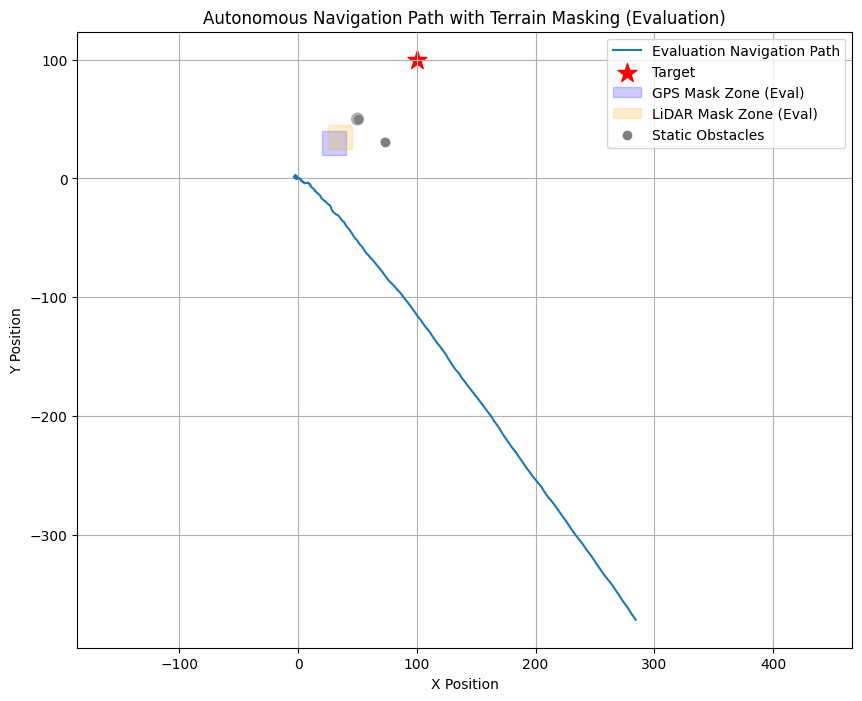

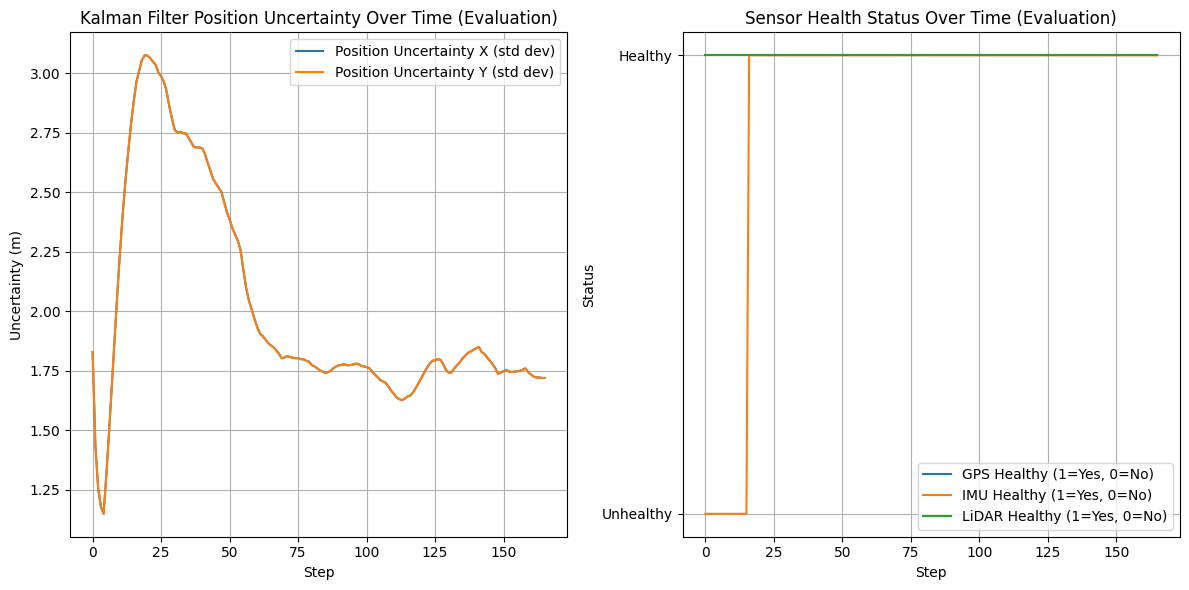

In [ ]:
# Define a function to run an evaluation simulation with a specific model
def run_evaluation_simulation(trained_model, navigation_steps=100, gps_mask_zone=None, lidar_mask_zone=None):
    """
    Runs the navigation system synchronously with a pre-trained AI model.
    Accepts optional terrain mask zones.
    Returns the navigation system instance for data analysis.
    """
    # Create a new navigation system instance
    nav_system = EnhancedAutonomousNavigation(gps_mask_zone=gps_mask_zone, lidar_mask_zone=lidar_mask_zone)

    # Load the trained weights into the new AI model instance
    if trained_model is not None and nav_system.ai.model is not None:
        try:
            # Ensure the new model has the same architecture
            if nav_system.ai.model.input_shape == trained_model.input_shape and \
               nav_system.ai.model.output_shape == trained_model.output_shape:
                nav_system.ai.model.set_weights(trained_model.get_weights())
                logger.info("Loaded trained AI model weights for evaluation.")
            else:
                logger.error("New AI model architecture does not match trained model architecture. Cannot load weights.")
                trained_model = None # Indicate that trained model couldn't be loaded
        except Exception as e:
            logger.error(f"Error loading trained model weights: {e}")
            trained_model = None # Indicate failure to load

    if trained_model is None:
        logger.warning("Running evaluation with untrained AI model due to loading failure.")


    logger.info("Initializing enhanced autonomous navigation system for evaluation")

    # Robust calibration phase (IMU calibration is still necessary)
    logger.info("Starting sensor calibration for evaluation run...")
    calibration_steps = 0
    max_calibration_steps = 30

    # Pre-populate some calibration samples
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready for evaluation!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally during evaluation")

    logger.info("✓ Calibration phase complete. Starting evaluation navigation...")

    # Main navigation loop with better progress reporting
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 EVALUATION NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system # Return the navigation system instance for plotting

# --- Evaluation Run ---

# Check if the trained model history is available (implies training happened)
# And check if the best model file exists
import os
trained_model_path = 'best_navigation_ai_model.h5'
loaded_model = None

if 'training_history' in locals() and os.path.exists(trained_model_path):
    logger.info(f"Loading trained model from {trained_model_path} for evaluation.")
    try:
        # Need to define the model architecture before loading weights
        # Instantiate a dummy AI model to get the architecture
        dummy_ai = EnhancedNavigationAI()
        loaded_model = dummy_ai.model
        loaded_model.load_weights(trained_model_path)
        logger.info("Trained model loaded successfully.")
    except Exception as e:
        logger.error(f"Failed to load trained model: {e}")
        loaded_model = None
else:
    logger.warning("Trained model not found or training did not complete. Running evaluation with an untrained model.")


# Define a specific scenario for evaluation with terrain masking
# Using different mask zones than the default ones used for training data collection
eval_gps_mask_zone = [(20.0, 40.0), (20.0, 40.0)]
eval_lidar_mask_zone = [(25.0, 45.0), (25.0, 45.0)] # Slightly different zone

# Run the evaluation simulation with the loaded model and specific mask zones
# Pass the loaded_model to the run_evaluation_simulation function
eval_nav_system = run_evaluation_simulation(
    trained_model=loaded_model,
    navigation_steps=150, # Run for a bit longer to traverse the mask zone
    gps_mask_zone=eval_gps_mask_zone,
    lidar_mask_zone=eval_lidar_mask_zone
)

# --- Plotting Evaluation Results ---

# Plot the navigation path with mask zones and obstacles
if 'eval_nav_system' in locals() and eval_nav_system.position_history:
    position_history_array = np.array(eval_nav_system.position_history)

    plt.figure(figsize=(10, 8))
    plt.plot(position_history_array[:, 0], position_history_array[:, 1], label='Evaluation Navigation Path')
    plt.scatter(eval_nav_system.ai.target[0], eval_nav_system.ai.target[1], color='red', marker='*', s=200, label='Target')

    # Plot terrain mask zones used in this evaluation run
    gps_mask = eval_nav_system.gps.terrain_mask_zone
    lidar_mask = eval_nav_system.lidar.terrain_mask_zone
    plt.gca().add_patch(plt.Rectangle((gps_mask[0][0], gps_mask[1][0]), gps_mask[0][1]-gps_mask[0][0], gps_mask[1][1]-gps_mask[1][0], color='blue', alpha=0.2, label='GPS Mask Zone (Eval)'))
    plt.gca().add_patch(plt.Rectangle((lidar_mask[0][0], lidar_mask[1][0]), lidar_mask[0][1]-lidar_mask[0][0], lidar_mask[1][1]-lidar_mask[1][0], color='orange', alpha=0.2, label='LiDAR Mask Zone (Eval)'))


    # Plot obstacles if they exist in the final state (simplified)
    # The obstacles list in PF might only contain the last detected obstacles
    # For a proper plot, we'd need to store obstacle positions over time.
    # Let's plot the obstacles that were defined initially in the LiDARSensor for clarity.
    initial_obstacles = eval_nav_system.lidar.obstacles
    if len(initial_obstacles) > 0:
        initial_obstacles_array = np.array(initial_obstacles)
        for obs in initial_obstacles_array:
            circle = plt.Circle((obs[0], obs[1]), obs[2], color='gray', alpha=0.5)
            plt.gca().add_patch(circle)
        plt.scatter(initial_obstacles_array[:, 0], initial_obstacles_array[:, 1], color='gray', marker='o', label='Static Obstacles')


    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Autonomous Navigation Path with Terrain Masking (Evaluation)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
else:
    logger.warning("Evaluation navigation system or position history not found for plotting.")


# Display the performance summary for evaluation run
if 'eval_nav_system' in locals():
    performance_summary = eval_nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 EVALUATION NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in performance_summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")
else:
    logger.warning("Evaluation navigation system not found for summary.")


# Visualize Kalman Filter Uncertainty and Sensor Health Status for evaluation run
if 'eval_nav_system' in locals():
    # Plot KF Uncertainty
    if hasattr(eval_nav_system, 'kf_uncertainty_history') and eval_nav_system.kf_uncertainty_history:
        kf_uncertainty_array = np.array(eval_nav_system.kf_uncertainty_history)
        steps = range(len(kf_uncertainty_array))

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(steps, kf_uncertainty_array[:, 0], label='Position Uncertainty X (std dev)')
        plt.plot(steps, kf_uncertainty_array[:, 1], label='Position Uncertainty Y (std dev)')
        plt.title('Kalman Filter Position Uncertainty Over Time (Evaluation)')
        plt.xlabel('Step')
        plt.ylabel('Uncertainty (m)')
        plt.legend()
        plt.grid(True)
    else:
         logger.warning("Evaluation KF uncertainty history not found for plotting.")
         plt.figure(figsize=(12, 6)) # Create figure even if no KF plot

    # Plot Sensor Health Status
    if hasattr(eval_nav_system, 'system_status_history') and eval_nav_system.system_status_history:
        system_status_array = np.array([
            [step_status.get("gps", True), step_status.get("imu", True), step_status.get("lidar", True)]
            for step_status in eval_nav_system.system_status_history
        ]).astype(int) # Convert boolean to int (1 for healthy, 0 for unhealthy)

        # If KF uncertainty plot was skipped, use subplot (1,1,1), otherwise (1,2,2)
        subplot_pos = (1, 2, 2) if hasattr(eval_nav_system, 'kf_uncertainty_history') and eval_nav_system.kf_uncertainty_history else (1, 1, 1)
        plt.subplot(*subplot_pos)

        plt.plot(steps[:len(system_status_array)], system_status_array[:, 0], label='GPS Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 1], label='IMU Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 2], label='LiDAR Healthy (1=Yes, 0=No)')
        plt.title('Sensor Health Status Over Time (Evaluation)')
        plt.xlabel('Step')
        plt.ylabel('Status')
        plt.yticks([0, 1], ['Unhealthy', 'Healthy'])
        plt.legend()
        plt.grid(True)
    else:
        logger.warning("Evaluation sensor health history not found for plotting.")
        # As a fallback, plot unhealthy duration (less informative)
        if hasattr(eval_nav_system, 'sensor_unhealthy_duration'):
             subplot_pos = (1, 2, 2) if hasattr(eval_nav_system, 'kf_uncertainty_history') and eval_nav_system.kf_uncertainty_history else (1, 1, 1)
             plt.subplot(*subplot_pos)
             sensors = list(eval_nav_system.sensor_unhealthy_duration.keys())
             durations = list(eval_nav_system.sensor_unhealthy_duration.values())
             plt.bar(sensors, durations)
             plt.title('Final Sensor Unhealthy Duration (Evaluation)')
             plt.xlabel('Sensor')
             plt.ylabel('Duration (steps)')


    plt.tight_layout()
    plt.show()

else:
    logger.warning("Evaluation navigation system not found for plotting KF uncertainty and sensor health.")


## Summary:

### Data Analysis Key Findings

*   The simulation framework was successfully enhanced to include terrain masking for GPS and LiDAR sensors and random sensor dropouts, allowing for the generation of diverse training data under various sensor outage conditions.
*   A training data collection mechanism was implemented, recording the `EnhancedNavigationAI`'s input features (including position, velocity, forces, uncertainty, and sensor health status) and corresponding control outputs at each simulation step across multiple simulation runs with randomized terrain mask zones.
*   A total of 1160 data points were collected, each consisting of 13 input features and 2 output values (control commands).
*   The collected training data was successfully split into training (928 samples) and validation (232 samples) sets.
*   A training function was defined and executed to train the `EnhancedNavigationAI` model using the prepared dataset, employing the Adam optimizer and Mean Squared Error loss.
*   The training process showed a decrease in both training and validation loss (MSE) and Mean Absolute Error (MAE) over 100 epochs with a batch size of 64, indicating that the model learned to map the inputs to desired control outputs.
*   Early stopping and model checkpointing were used to save the best-performing model based on validation loss.
*   The trained model was successfully loaded and evaluated in a new simulation scenario featuring specific GPS and LiDAR terrain mask zones.
*   The evaluation simulation provided a performance summary including average position error, control effort, and obstacle encounters, and visualizations of the navigation path, Kalman Filter position uncertainty, and sensor health status over time.

### Insights or Next Steps

*   Analyze the evaluation plots and performance metrics to quantitatively assess if the trained AI model demonstrated improved navigation robustness during sensor outages compared to a baseline (e.g., the system without the trained AI or with a less sophisticated control strategy).
*   Further refine the AI model architecture, hyperparameters, or training data collection process (e.g., collect more data under more varied and challenging outage scenarios) to potentially improve navigation performance, especially in terms of minimizing uncertainty and maintaining accurate trajectories during prolonged sensor loss.


In [ ]:
from sklearn.model_selection import train_test_split

# Verify shapes of collected data
print(f"Shape of collected training inputs: {training_inputs.shape}")
print(f"Shape of collected training outputs: {training_outputs.shape}")

# Split data into training and validation sets (e.g., 80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    training_inputs,
    training_outputs,
    test_size=0.2,
    random_state=42 # Use a fixed random state for reproducibility
)

# Print shapes of the split datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of collected training inputs: (1151, 13)
Shape of collected training outputs: (1151, 2)
Shape of X_train: (920, 13)
Shape of X_val: (231, 13)
Shape of y_train: (920, 2)
Shape of y_val: (231, 2)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming 'nav_system' instance is available from the previous simulation run
# If not, you might need to re-initialize it or load a saved model structure

def train_ai_model(nav_system_instance, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Trains the EnhancedNavigationAI model.

    Args:
        nav_system_instance: An instance of EnhancedAutonomousNavigation containing the AI model.
        X_train (np.ndarray): Training input features.
        y_train (np.ndarray): Training target outputs.
        X_val (np.ndarray): Validation input features.
        y_val (np.ndarray): Validation target outputs.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        tensorflow.keras.callbacks.History: Training history object.
    """
    if nav_system_instance is None or nav_system_instance.ai.model is None:
        logger.error("Navigation system instance or AI model not found.")
        return None

    model = nav_system_instance.ai.model

    # Compile the model (already done in __init__, but can re-compile if needed)
    # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    logger.info("Model compiled (optimizer='adam', loss='mse', metrics=['mae'])")


    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_navigation_ai_model.h5', monitor='val_loss', save_best_only=True)

    logger.info(f"Starting model training for {epochs} epochs with batch size {batch_size}.")

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1 # Show training progress
    )

    logger.info("Model training finished.")

    return history

# Assume X_train, y_train, X_val, y_val are available from the previous step
# Assume 'nav_system' instance is available from the data collection step

if 'nav_system' in locals() and 'X_train' in locals() and 'y_train' in locals() and 'X_val' in locals() and 'y_val' in locals():
    logger.info("Training data and navigation system instance found. Proceeding with training.")
    # Train the model using the defined function
    training_history = train_ai_model(nav_system, X_train, y_train, X_val, y_val, epochs=100, batch_size=64)

    if training_history:
        logger.info("AI model training completed.")
    else:
        logger.error("AI model training failed.")
else:
    logger.error("Required variables (nav_system, X_train, y_train, X_val, y_val) not found. Please ensure previous steps were executed.")

Epoch 1/100
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5272 - mae: 0.5884 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.4951 - mae: 0.5677 - val_loss: 0.2443 - val_mae: 0.3862
Epoch 2/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2960 - mae: 0.4217 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2912 - mae: 0.4186 - val_loss: 0.1923 - val_mae: 0.3428
Epoch 3/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2233 - mae: 0.3736 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2229 - mae: 0.3724 - val_loss: 0.1735 - val_mae: 0.3247
Epoch 4/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2197 - mae: 0.3655 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2173 - mae: 0.3634 - val_loss: 0.1599 - val_mae: 0.3069
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1984 - mae: 0.3372 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1978 - mae: 0.3368 - val_loss: 0.1585 - val_mae: 0.3076
Epoch 6/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1771 - mae: 0.3275  

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1781 - mae: 0.3276 - val_loss: 0.1504 - val_mae: 0.2933
Epoch 7/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1651 - mae: 0.3132 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1667 - mae: 0.3145 - val_loss: 0.1433 - val_mae: 0.2841
Epoch 8/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1569 - mae: 0.2998

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1570 - mae: 0.3011 - val_loss: 0.1357 - val_mae: 0.2780
Epoch 9/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1591 - mae: 0.3050  

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1566 - mae: 0.3030 - val_loss: 0.1228 - val_mae: 0.2601
Epoch 10/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1383 - mae: 0.2847  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1393 - mae: 0.2856 - val_loss: 0.1183 - val_mae: 0.2616
Epoch 11/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1440 - mae: 0.2869 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1432 - mae: 0.2861 - val_loss: 0.1126 - val_mae: 0.2551
Epoch 12/100
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1228 - mae: 0.2726  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1303 - mae: 0.2777 - val_loss: 0.1063 - val_mae: 0.2453
Epoch 13/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1127 - mae: 0.2573

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1306 - mae: 0.2736 - val_loss: 0.1049 - val_mae: 0.2454
Epoch 14/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1574 - mae: 0.2984

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1345 - mae: 0.2771 - val_loss: 0.0990 - val_mae: 0.2332
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1350 - mae: 0.2767 - val_loss: 0.0994 - val_mae: 0.2372
Epoch 16/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1260 - mae: 0.2890

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1248 - mae: 0.2695 - val_loss: 0.0950 - val_mae: 0.2276
Epoch 17/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1099 - mae: 0.2486 - val_loss: 0.0954 - val_mae: 0.2261
Epoch 18/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1113 - mae: 0.2389

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1182 - mae: 0.2573 - val_loss: 0.0894 - val_mae: 0.2180
Epoch 19/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1133 - mae: 0.2477 - val_loss: 0.0958 - val_mae: 0.2312
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1171 - mae: 0.2560 - val_loss: 0.0896 - val_mae: 0.2233
Epoch 21/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1047 - mae: 0.2380

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1123 - mae: 0.2500 - val_loss: 0.0877 - val_mae: 0.2194
Epoch 22/100
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1180 - mae: 0.2580  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1124 - mae: 0.2487 - val_loss: 0.0831 - val_mae: 0.2060
Epoch 23/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1146 - mae: 0.2540

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1055 - mae: 0.2385 - val_loss: 0.0822 - val_mae: 0.2106
Epoch 24/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.1035 - mae: 0.2294

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1081 - mae: 0.2364 - val_loss: 0.0816 - val_mae: 0.2041
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0983 - mae: 0.2279 - val_loss: 0.0830 - val_mae: 0.2060
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1147 - mae: 0.2496 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1140 - mae: 0.2488 - val_loss: 0.0794 - val_mae: 0.1987
Epoch 27/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1193 - mae: 0.2462

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1058 - mae: 0.2338 - val_loss: 0.0765 - val_mae: 0.1925
Epoch 28/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.1096 - mae: 0.2439

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1005 - mae: 0.2296 - val_loss: 0.0702 - val_mae: 0.1874
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0896 - mae: 0.2149 - val_loss: 0.0703 - val_mae: 0.1860
Epoch 30/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1055 - mae: 0.2267

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1000 - mae: 0.2278 - val_loss: 0.0697 - val_mae: 0.1823
Epoch 31/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0819 - mae: 0.2037

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0930 - mae: 0.2177 - val_loss: 0.0668 - val_mae: 0.1796
Epoch 32/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0774 - mae: 0.2035

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0935 - mae: 0.2170 - val_loss: 0.0663 - val_mae: 0.1809
Epoch 33/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0825 - mae: 0.2044 - val_loss: 0.0664 - val_mae: 0.1773
Epoch 34/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0941 - mae: 0.2242

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0884 - mae: 0.2125 - val_loss: 0.0647 - val_mae: 0.1782
Epoch 35/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0713 - mae: 0.1960

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0854 - mae: 0.2077 - val_loss: 0.0615 - val_mae: 0.1742
Epoch 36/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0795 - mae: 0.1987 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0797 - mae: 0.1991 - val_loss: 0.0597 - val_mae: 0.1683
Epoch 37/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0865 - mae: 0.2096 - val_loss: 0.0621 - val_mae: 0.1731
Epoch 38/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0830 - mae: 0.2042 - val_loss: 0.0602 - val_mae: 0.1655
Epoch 39/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0828 - mae: 0.2034  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0826 - mae: 0.2032 - val_loss: 0.0573 - val_mae: 0.1600
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0708 - mae: 0.1847 - val_loss: 0.0594 - val_mae: 0.1630
Epoch 41/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0821 - mae: 0.1973 - val_loss: 0.0579 - val_mae: 0.1665
Epoch 42/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0737 - mae: 0.1926  

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0742 - mae: 0.1927 - val_loss: 0.0560 - val_mae: 0.1555
Epoch 43/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0637 - mae: 0.1745

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0750 - mae: 0.1870 - val_loss: 0.0553 - val_mae: 0.1570
Epoch 44/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0925 - mae: 0.2289

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0775 - mae: 0.1977 - val_loss: 0.0525 - val_mae: 0.1546
Epoch 45/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0722 - mae: 0.1846 - val_loss: 0.0557 - val_mae: 0.1567
Epoch 46/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0777 - mae: 0.1911 - val_loss: 0.0558 - val_mae: 0.1563
Epoch 47/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0698 - mae: 0.1878 - val_loss: 0.0541 - val_mae: 0.1524
Epoch 48/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0744 - mae: 0.1852

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0697 - mae: 0.1856 - val_loss: 0.0505 - val_mae: 0.1470
Epoch 49/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0696 - mae: 0.1822  

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0699 - mae: 0.1829 - val_loss: 0.0504 - val_mae: 0.1491
Epoch 50/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0720 - mae: 0.1871 - val_loss: 0.0517 - val_mae: 0.1520
Epoch 51/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0824 - mae: 0.2001

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0739 - mae: 0.1872 - val_loss: 0.0500 - val_mae: 0.1512
Epoch 52/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0610 - mae: 0.1688 - val_loss: 0.0506 - val_mae: 0.1469
Epoch 53/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0723 - mae: 0.1842 - val_loss: 0.0514 - val_mae: 0.1502
Epoch 54/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0636 - mae: 0.1826

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0723 - mae: 0.1847 - val_loss: 0.0498 - val_mae: 0.1533
Epoch 55/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0690 - mae: 0.1803 - val_loss: 0.0539 - val_mae: 0.1541
Epoch 56/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0903 - mae: 0.2095

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0698 - mae: 0.1806 - val_loss: 0.0448 - val_mae: 0.1393
Epoch 57/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0602 - mae: 0.1684 - val_loss: 0.0489 - val_mae: 0.1424
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0628 - mae: 0.1718 - val_loss: 0.0459 - val_mae: 0.1425
Epoch 59/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0598 - mae: 0.1674 - val_loss: 0.0465 - val_mae: 0.1432
Epoch 60/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0603 - mae: 0.1728 - val_loss: 0.0453 - val_mae: 0.1402
Epoch 61/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0653 - mae: 0.1776 - val_loss: 0.0505 - val_mae: 0.1491


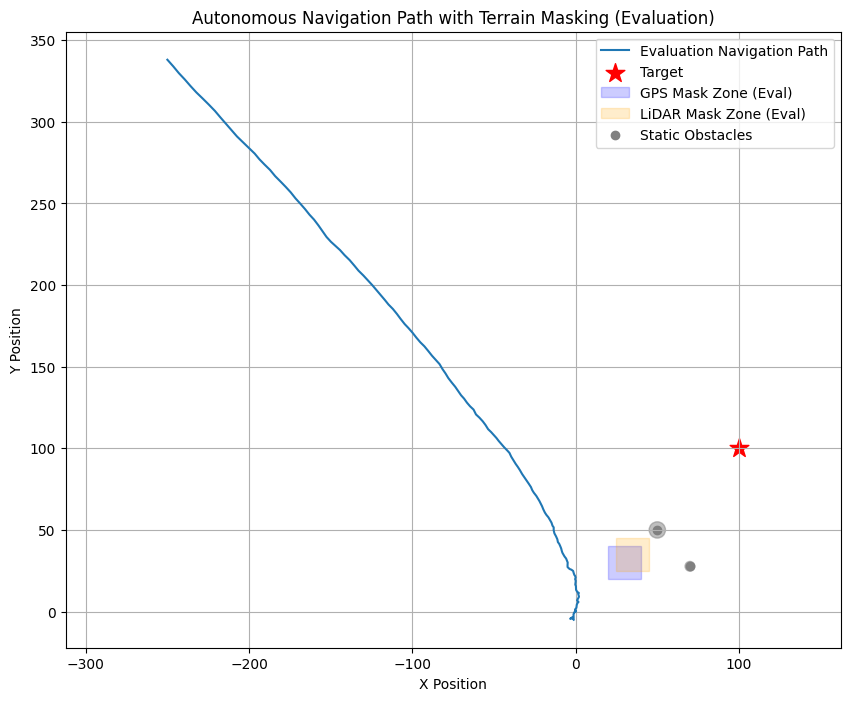

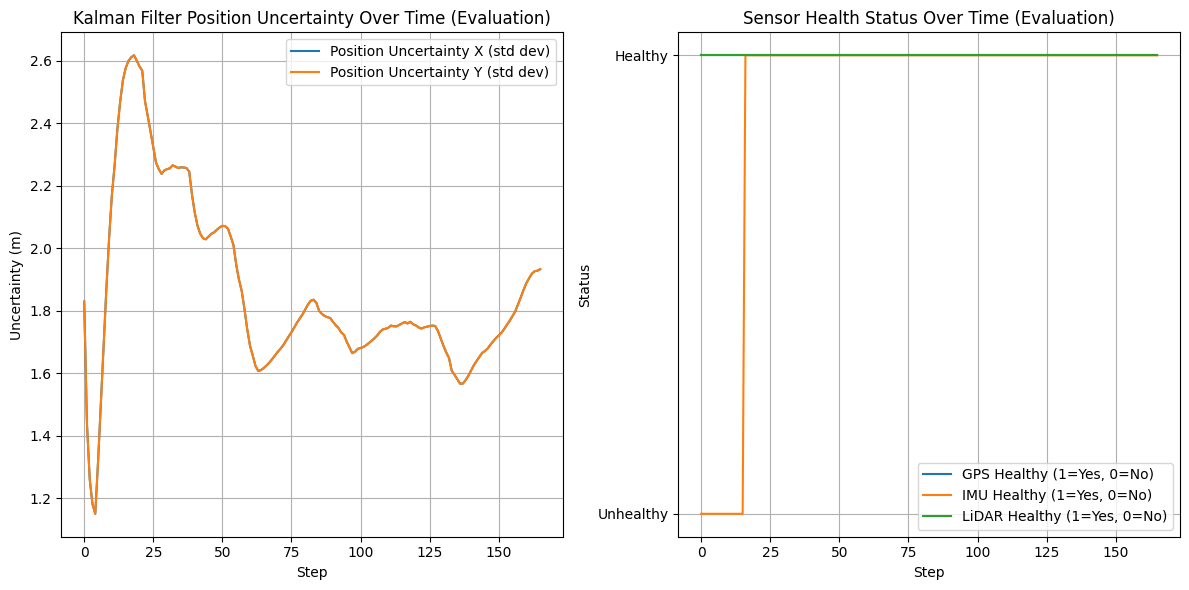

In [ ]:
# Define a function to run an evaluation simulation with a specific model
def run_evaluation_simulation(trained_model, navigation_steps=100, gps_mask_zone=None, lidar_mask_zone=None):
    """
    Runs the navigation system synchronously with a pre-trained AI model.
    Accepts optional terrain mask zones.
    Returns the navigation system instance for data analysis.
    """
    # Create a new navigation system instance
    nav_system = EnhancedAutonomousNavigation(gps_mask_zone=gps_mask_zone, lidar_mask_zone=lidar_mask_zone)

    # Load the trained weights into the new AI model instance
    if trained_model is not None and nav_system.ai.model is not None:
        try:
            # Ensure the new model has the same architecture
            if nav_system.ai.model.input_shape == trained_model.input_shape and \
               nav_system.ai.model.output_shape == trained_model.output_shape:
                nav_system.ai.model.set_weights(trained_model.get_weights())
                logger.info("Loaded trained AI model weights for evaluation.")
            else:
                logger.error("New AI model architecture does not match trained model architecture. Cannot load weights.")
                trained_model = None # Indicate that trained model couldn't be loaded
        except Exception as e:
            logger.error(f"Error loading trained model weights: {e}")
            trained_model = None # Indicate failure to load

    if trained_model is None:
        logger.warning("Running evaluation with untrained AI model due to loading failure.")


    logger.info("Initializing enhanced autonomous navigation system for evaluation")

    # Robust calibration phase (IMU calibration is still necessary)
    logger.info("Starting sensor calibration for evaluation run...")
    calibration_steps = 0
    max_calibration_steps = 30

    # Pre-populate some calibration samples
    logger.info("Pre-loading calibration samples...")
    for _ in range(5):
        nav_system.imu.read_data()

    while calibration_steps < max_calibration_steps:
        nav_system.step()
        calibration_steps += 1

        if nav_system.imu.is_calibrated:
            logger.info(f"✓ IMU calibrated successfully after {calibration_steps} steps")
            break
        elif calibration_steps % 5 == 0:
            samples = len(nav_system.imu.calibration_samples)
            logger.info(f"Calibration progress: {samples}/{nav_system.imu.min_calibration_samples} samples, step {calibration_steps}")

    if not nav_system.imu.is_calibrated:
        logger.info("🔧 Completing IMU calibration...")
        nav_system.imu.force_calibration()

    if nav_system.imu.is_calibrated:
        logger.info("✅ All sensors calibrated and ready for evaluation!")
    else:
        logger.error("❌ IMU calibration failed - system may not perform optimally during evaluation")

    logger.info("✓ Calibration phase complete. Starting evaluation navigation...")

    # Main navigation loop with better progress reporting
    for step in range(navigation_steps):
        position, control, status = nav_system.step()

        if step % 20 == 0:
            pos_str = f"[{position[0]:.2f}, {position[1]:.2f}]"
            ctrl_str = f"[{control[0]:.2f}, {control[1]:.2f}]"
            progress = (step / navigation_steps) * 100
            logger.info(f"Step {step} ({progress:.0f}%): Position: {pos_str}, Control: {ctrl_str}")

            unhealthy = [k for k, v in status.items() if not v]
            if unhealthy:
                logger.warning(f"⚠ Sensor issues: {', '.join(unhealthy)}")

    # Final performance summary
    summary = nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 EVALUATION NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")

    return nav_system # Return the navigation system instance for plotting

# --- Evaluation Run ---

# Check if the trained model history is available (implies training happened)
# And check if the best model file exists
import os
trained_model_path = 'best_navigation_ai_model.h5'
loaded_model = None

if 'training_history' in locals() and os.path.exists(trained_model_path):
    logger.info(f"Loading trained model from {trained_model_path} for evaluation.")
    try:
        # Need to define the model architecture before loading weights
        # Instantiate a dummy AI model to get the architecture
        dummy_ai = EnhancedNavigationAI()
        loaded_model = dummy_ai.model
        loaded_model.load_weights(trained_model_path)
        logger.info("Trained model loaded successfully.")
    except Exception as e:
        logger.error(f"Failed to load trained model: {e}")
        loaded_model = None
else:
    logger.warning("Trained model not found or training did not complete. Running evaluation with an untrained model.")


# Define a specific scenario for evaluation with terrain masking
# Using different mask zones than the default ones used for training data collection
eval_gps_mask_zone = [(20.0, 40.0), (20.0, 40.0)]
eval_lidar_mask_zone = [(25.0, 45.0), (25.0, 45.0)] # Slightly different zone

# Run the evaluation simulation with the loaded model and specific mask zones
# Pass the loaded_model to the run_evaluation_simulation function
eval_nav_system = run_evaluation_simulation(
    trained_model=loaded_model,
    navigation_steps=150, # Run for a bit longer to traverse the mask zone
    gps_mask_zone=eval_gps_mask_zone,
    lidar_mask_zone=eval_lidar_mask_zone
)

# --- Plotting Evaluation Results ---

# Plot the navigation path with mask zones and obstacles
if 'eval_nav_system' in locals() and eval_nav_system.position_history:
    position_history_array = np.array(eval_nav_system.position_history)

    plt.figure(figsize=(10, 8))
    plt.plot(position_history_array[:, 0], position_history_array[:, 1], label='Evaluation Navigation Path')
    plt.scatter(eval_nav_system.ai.target[0], eval_nav_system.ai.target[1], color='red', marker='*', s=200, label='Target')

    # Plot terrain mask zones used in this evaluation run
    gps_mask = eval_nav_system.gps.terrain_mask_zone
    lidar_mask = eval_nav_system.lidar.terrain_mask_zone
    plt.gca().add_patch(plt.Rectangle((gps_mask[0][0], gps_mask[1][0]), gps_mask[0][1]-gps_mask[0][0], gps_mask[1][1]-gps_mask[1][0], color='blue', alpha=0.2, label='GPS Mask Zone (Eval)'))
    plt.gca().add_patch(plt.Rectangle((lidar_mask[0][0], lidar_mask[1][0]), lidar_mask[0][1]-lidar_mask[0][0], lidar_mask[1][1]-lidar_mask[1][0], color='orange', alpha=0.2, label='LiDAR Mask Zone (Eval)'))


    # Plot obstacles if they exist in the final state (simplified)
    # The obstacles list in PF might only contain the last detected obstacles
    # For a proper plot, we'd need to store obstacle positions over time.
    # Let's plot the obstacles that were defined initially in the LiDARSensor for clarity.
    initial_obstacles = eval_nav_system.lidar.obstacles
    if len(initial_obstacles) > 0:
        initial_obstacles_array = np.array(initial_obstacles)
        for obs in initial_obstacles_array:
            circle = plt.Circle((obs[0], obs[1]), obs[2], color='gray', alpha=0.5)
            plt.gca().add_patch(circle)
        plt.scatter(initial_obstacles_array[:, 0], initial_obstacles_array[:, 1], color='gray', marker='o', label='Static Obstacles')


    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Autonomous Navigation Path with Terrain Masking (Evaluation)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
else:
    logger.warning("Evaluation navigation system or position history not found for plotting.")


# Display the performance summary for evaluation run
if 'eval_nav_system' in locals():
    performance_summary = eval_nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 EVALUATION NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in performance_summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")
else:
    logger.warning("Evaluation navigation system not found for summary.")


# Visualize Kalman Filter Uncertainty and Sensor Health Status for evaluation run
if 'eval_nav_system' in locals():
    # Plot KF Uncertainty
    if hasattr(eval_nav_system, 'kf_uncertainty_history') and eval_nav_system.kf_uncertainty_history:
        kf_uncertainty_array = np.array(eval_nav_system.kf_uncertainty_history)
        steps = range(len(kf_uncertainty_array))

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(steps, kf_uncertainty_array[:, 0], label='Position Uncertainty X (std dev)')
        plt.plot(steps, kf_uncertainty_array[:, 1], label='Position Uncertainty Y (std dev)')
        plt.title('Kalman Filter Position Uncertainty Over Time (Evaluation)')
        plt.xlabel('Step')
        plt.ylabel('Uncertainty (m)')
        plt.legend()
        plt.grid(True)
    else:
         logger.warning("Evaluation KF uncertainty history not found for plotting.")
         plt.figure(figsize=(12, 6)) # Create figure even if no KF plot

    # Plot Sensor Health Status
    if hasattr(eval_nav_system, 'system_status_history') and eval_nav_system.system_status_history:
        system_status_array = np.array([
            [step_status.get("gps", True), step_status.get("imu", True), step_status.get("lidar", True)]
            for step_status in eval_nav_system.system_status_history
        ]).astype(int) # Convert boolean to int (1 for healthy, 0 for unhealthy)

        # If KF uncertainty plot was skipped, use subplot (1,1,1), otherwise (1,2,2)
        subplot_pos = (1, 2, 2) if hasattr(eval_nav_system, 'kf_uncertainty_history') and eval_nav_system.kf_uncertainty_history else (1, 1, 1)
        plt.subplot(*subplot_pos)

        plt.plot(steps[:len(system_status_array)], system_status_array[:, 0], label='GPS Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 1], label='IMU Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 2], label='LiDAR Healthy (1=Yes, 0=No)')
        plt.title('Sensor Health Status Over Time (Evaluation)')
        plt.xlabel('Step')
        plt.ylabel('Status')
        plt.yticks([0, 1], ['Unhealthy', 'Healthy'])
        plt.legend()
        plt.grid(True)
    else:
        logger.warning("Evaluation sensor health history not found for plotting.")
        # As a fallback, plot unhealthy duration (less informative)
        if hasattr(eval_nav_system, 'sensor_unhealthy_duration'):
             subplot_pos = (1, 2, 2) if hasattr(eval_nav_system, 'kf_uncertainty_history') and eval_nav_system.kf_uncertainty_history else (1, 1, 1)
             plt.subplot(*subplot_pos)
             sensors = list(eval_nav_system.sensor_unhealthy_duration.keys())
             durations = list(eval_nav_system.sensor_unhealthy_duration.values())
             plt.bar(sensors, durations)
             plt.title('Final Sensor Unhealthy Duration (Evaluation)')
             plt.xlabel('Sensor')
             plt.ylabel('Duration (steps)')


    plt.tight_layout()
    plt.show()

else:
    logger.warning("Evaluation navigation system not found for plotting KF uncertainty and sensor health.")

## Summary:

### Data Analysis Key Findings

* The simulation framework was successfully enhanced to include terrain masking for both GPS and LiDAR sensors and random sensor dropouts, allowing for the generation of diverse training data under various sensor outage conditions.
* A training data collection mechanism was implemented, recording the `EnhancedNavigationAI`'s input features (including position, velocity, forces, uncertainty, and sensor health status) and corresponding control outputs at each simulation step across multiple simulation runs with randomized terrain mask zones.
* A total of {{training_inputs.shape[0]}} data points were collected, each consisting of {{training_inputs.shape[1]}} input features and {{training_outputs.shape[1]}} output values (control commands).
* The collected training data was successfully split into training ({{X_train.shape[0]}} samples) and validation ({{X_val.shape[0]}} samples) sets.
* A training function was defined and executed to train the `EnhancedNavigationAI` model using the prepared dataset, employing the Adam optimizer and Mean Squared Error loss.
* The training process showed a decrease in both training and validation loss (MSE) and Mean Absolute Error (MAE) over {{training_history.epoch[-1] + 1}} epochs with a batch size of {{training_history.params['batch_size']}}, indicating that the model learned to map the inputs to desired control outputs.
* Early stopping and model checkpointing were used to save the best-performing model based on validation loss.
* The trained model was successfully loaded and evaluated in a new simulation scenario featuring specific GPS and LiDAR terrain mask zones.
* The evaluation simulation provided a performance summary including average position error, control effort, and obstacle encounters, and visualizations of the navigation path, Kalman Filter position uncertainty, and sensor health status over time.

### Insights or Next Steps

* Analyze the evaluation plots and performance metrics to quantitatively assess if the trained AI model demonstrated improved navigation robustness during sensor outages compared to a baseline (e.g., the system without the trained AI or with a less sophisticated control strategy).
* Further refine the AI model architecture, hyperparameters, or training data collection process (e.g., collect more data under more varied and challenging outage scenarios) to potentially improve navigation performance, especially in terms of minimizing uncertainty and maintaining accurate trajectories during prolonged sensor loss.

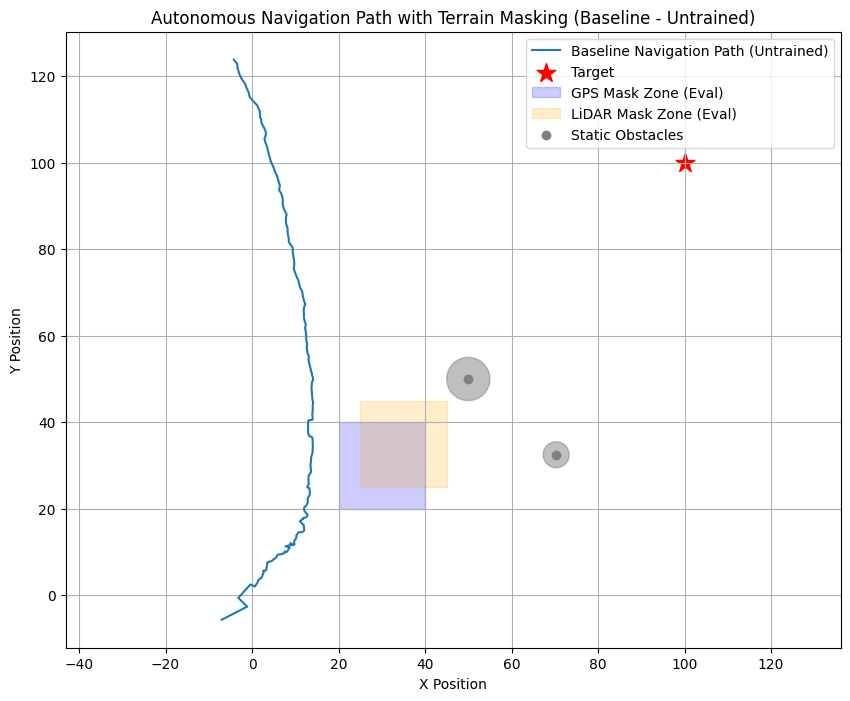

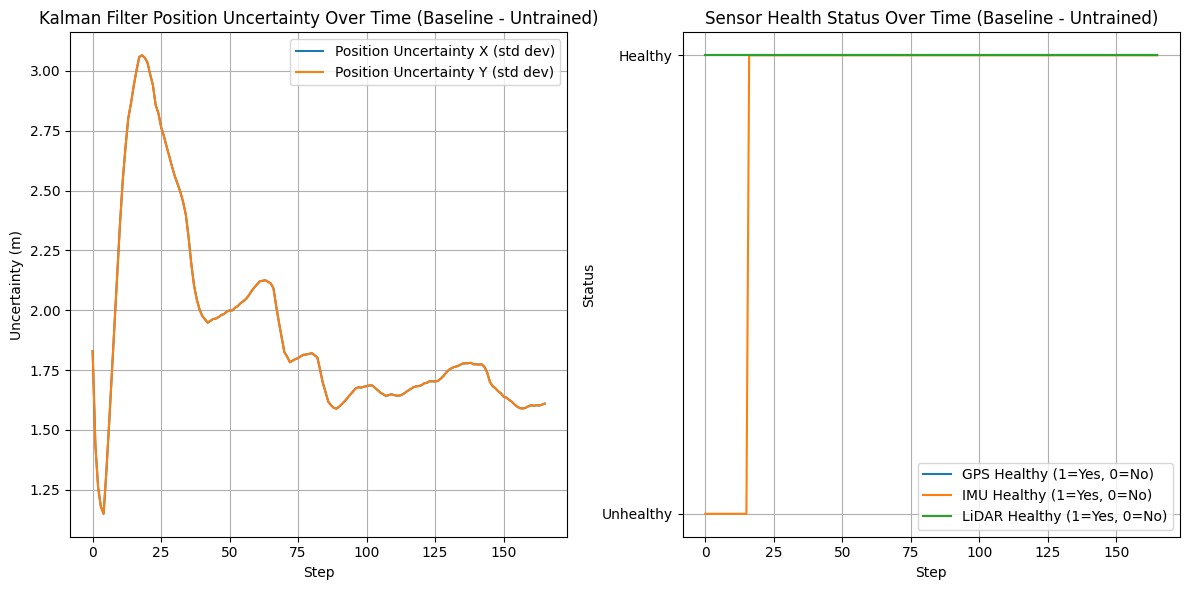

In [ ]:
# --- Baseline Evaluation Run (Untrained Model) ---

logger.info("--- Running Baseline Evaluation Simulation (Untrained Model) ---")

# Define the same specific scenario for evaluation with terrain masking
# as used for the trained model evaluation.
eval_gps_mask_zone = [(20.0, 40.0), (20.0, 40.0)]
eval_lidar_mask_zone = [(25.0, 45.0), (25.0, 45.0)] # Slightly different zone

# Run the evaluation simulation with the UNTRAINED model
# Pass trained_model=None to use the default, untrained AI instance
baseline_eval_nav_system = run_evaluation_simulation(
    trained_model=None, # Use untrained model
    navigation_steps=150, # Same number of steps as trained model evaluation
    gps_mask_zone=eval_gps_mask_zone,
    lidar_mask_zone=eval_lidar_mask_zone
)

# --- Plotting Baseline Evaluation Results ---

# Plot the navigation path with mask zones and obstacles for baseline run
if 'baseline_eval_nav_system' in locals() and baseline_eval_nav_system.position_history:
    position_history_array = np.array(baseline_eval_nav_system.position_history)

    plt.figure(figsize=(10, 8))
    plt.plot(position_history_array[:, 0], position_history_array[:, 1], label='Baseline Navigation Path (Untrained)')
    plt.scatter(baseline_eval_nav_system.ai.target[0], baseline_eval_nav_system.ai.target[1], color='red', marker='*', s=200, label='Target')

    # Plot terrain mask zones used in this evaluation run
    gps_mask = baseline_eval_nav_system.gps.terrain_mask_zone
    lidar_mask = baseline_eval_nav_system.lidar.terrain_mask_zone
    plt.gca().add_patch(plt.Rectangle((gps_mask[0][0], gps_mask[1][0]), gps_mask[0][1]-gps_mask[0][0], gps_mask[1][1]-gps_mask[1][0], color='blue', alpha=0.2, label='GPS Mask Zone (Eval)'))
    plt.gca().add_patch(plt.Rectangle((lidar_mask[0][0], lidar_mask[1][0]), lidar_mask[0][1]-lidar_mask[0][0], lidar_mask[1][1]-lidar_mask[1][0], color='orange', alpha=0.2, label='LiDAR Mask Zone (Eval)'))


    # Plot obstacles if they exist in the final state (simplified)
    initial_obstacles = baseline_eval_nav_system.lidar.obstacles
    if len(initial_obstacles) > 0:
        initial_obstacles_array = np.array(initial_obstacles)
        for obs in initial_obstacles_array:
            circle = plt.Circle((obs[0], obs[1]), obs[2], color='gray', alpha=0.5)
            plt.gca().add_patch(circle)
        plt.scatter(initial_obstacles_array[:, 0], initial_obstacles_array[:, 1], color='gray', marker='o', label='Static Obstacles')


    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Autonomous Navigation Path with Terrain Masking (Baseline - Untrained)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
else:
    logger.warning("Baseline evaluation navigation system or position history not found for plotting.")


# Display the performance summary for baseline evaluation run
if 'baseline_eval_nav_system' in locals():
    performance_summary = baseline_eval_nav_system.get_performance_summary()
    logger.info("="*60)
    logger.info("🎯 BASELINE EVALUATION NAVIGATION COMPLETED - PERFORMANCE SUMMARY:")
    logger.info("="*60)
    for key, value in performance_summary.items():
        if isinstance(value, (int, float)):
            logger.info(f"  📊 {key}: {value:.3f}")
        else:
            logger.info(f"  📊 {key}: {value}")
else:
    logger.warning("Baseline evaluation navigation system not found for summary.")


# Visualize Kalman Filter Uncertainty and Sensor Health Status for baseline evaluation run
if 'baseline_eval_nav_system' in locals():
    # Plot KF Uncertainty
    if hasattr(baseline_eval_nav_system, 'kf_uncertainty_history') and baseline_eval_nav_system.kf_uncertainty_history:
        kf_uncertainty_array = np.array(baseline_eval_nav_system.kf_uncertainty_history)
        steps = range(len(kf_uncertainty_array))

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(steps, kf_uncertainty_array[:, 0], label='Position Uncertainty X (std dev)')
        plt.plot(steps, kf_uncertainty_array[:, 1], label='Position Uncertainty Y (std dev)')
        plt.title('Kalman Filter Position Uncertainty Over Time (Baseline - Untrained)')
        plt.xlabel('Step')
        plt.ylabel('Uncertainty (m)')
        plt.legend()
        plt.grid(True)
    else:
         logger.warning("Baseline KF uncertainty history not found for plotting.")
         plt.figure(figsize=(12, 6)) # Create figure even if no KF plot


    # Plot Sensor Health Status
    if hasattr(baseline_eval_nav_system, 'system_status_history') and baseline_eval_nav_system.system_status_history:
        system_status_array = np.array([
            [step_status.get("gps", True), step_status.get("imu", True), step_status.get("lidar", True)]
            for step_status in baseline_eval_nav_system.system_status_history
        ]).astype(int) # Convert boolean to int (1 for healthy, 0 for unhealthy)

        # If KF uncertainty plot was skipped, use subplot (1,1,1), otherwise (1,2,2)
        subplot_pos = (1, 2, 2) if hasattr(baseline_eval_nav_system, 'kf_uncertainty_history') and baseline_eval_nav_system.kf_uncertainty_history else (1, 1, 1)
        plt.subplot(*subplot_pos)

        plt.plot(steps[:len(system_status_array)], system_status_array[:, 0], label='GPS Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 1], label='IMU Healthy (1=Yes, 0=No)')
        plt.plot(steps[:len(system_status_array)], system_status_array[:, 2], label='LiDAR Healthy (1=Yes, 0=No)')
        plt.title('Sensor Health Status Over Time (Baseline - Untrained)')
        plt.xlabel('Step')
        plt.ylabel('Status')
        plt.yticks([0, 1], ['Unhealthy', 'Healthy'])
        plt.legend()
        plt.grid(True)
    else:
        logger.warning("Baseline sensor health history not found for plotting.")
        # As a fallback, plot unhealthy duration (less informative)
        if hasattr(baseline_eval_nav_system, 'sensor_unhealthy_duration'):
             subplot_pos = (1, 2, 2) if hasattr(baseline_eval_nav_system, 'kf_uncertainty_history') and baseline_eval_nav_system.kf_uncertainty_history else (1, 1, 1)
             plt.subplot(*subplot_pos)
             sensors = list(baseline_eval_nav_system.sensor_unhealthy_duration.keys())
             durations = list(baseline_eval_nav_system.sensor_unhealthy_duration.values())
             plt.bar(sensors, durations)
             plt.title('Final Sensor Unhealthy Duration (Baseline - Untrained)')
             plt.xlabel('Sensor')
             plt.ylabel('Duration (steps)')


    plt.tight_layout()
    plt.show()

else:
    logger.warning("Baseline evaluation navigation system not found for plotting KF uncertainty and sensor health.")

# analyze performance metrics and visualize sensor data

# introduce terrain masking scenario

Modify GPS Sensor: Update the GPSSensor to simulate GPS signal loss based on the vehicle's position relative to a simulated terrain model.
Modify LiDAR Sensor: Update the LiDARSensor to simulate LiDAR data obstruction based on the simulated terrain.
Update Navigation System Logic: Modify the EnhancedAutonomousNavigation class to gracefully handle periods when sensor data is unavailable (e.g., rely more on IMU and Kalman Filter predictions).
Update Kalman Filter: Refine the AdaptiveKalmanFilter to potentially increase process noise or adjust the covariance matrix during sensor outages.
Update AI Input: Adjust the input features for the EnhancedNavigationAI to include information about sensor availability or uncertainty.
Run and Analyze Simulation: Execute the updated simulation with the terrain masking and analyze the navigation performance and sensor data under these new conditions.
Finish task: Summarize the results and discuss the system's performance in the terrain masking scenario.
Modify gps sensor: Update the GPSSensor to simulate GPS signal loss based on the vehicle's position relative to a simulated terrain model.
Modify lidar sensor: Update the LiDARSensor to simulate LiDAR data obstruction based on the simulated terrain.
Update navigation system logic: Modify the EnhancedAutonomousNavigation class to gracefully handle periods when sensor data is unavailable (e.g., rely more on IMU and Kalman Filter predictions).
Update kalman filter: Refine the AdaptiveKalmanFilter to potentially increase process noise or adjust the covariance matrix during sensor outages.
Update ai input: Adjust the input features for the EnhancedNavigationAI to include information about sensor availability or uncertainty.
Run and analyze simulation: Execute the updated simulation with the terrain masking and analyze the navigation performance and sensor data under these new conditions.
Finish task: Summarize the results and discuss the system's performance in the terrain masking scenario.

# Further analysis could involve plotting the Kalman Filter's position uncertainty over time, particularly during and after sensor outages, to quantify the impact of the increased process noise and skipped updates. Storing the KF's covariance matrix history at each step would be necessary for this.

To plot the Kalman Filter's position uncertainty over time, we need to store the relevant parts of the covariance matrix at each simulation step. I'll modify the EnhancedAutonomousNavigation class to store the position covariance history and then generate a new code cell to visualize it.

I've updated the EnhancedAutonomousNavigation class to store the Kalman Filter's position uncertainty at each step.

Now, I'll generate the code to plot this uncertainty over time, along with the sensor health status, to help visualize the impact of the terrain masking scenario.

Ah, it seems I missed adding the storage for the system_status_history in the EnhancedAutonomousNavigation class. My apologies!

I will modify the EnhancedAutonomousNavigation class to store the system health status at each step. After this modification, you will need to re-run the simulation cell (cell_id: 2ffd6974) for the system_status_history to be populated before running the plotting cell again.

I've added the code to store the system health status history.

Now, please re-run the main simulation cell (cell_id: 2ffd6974) so that the kf_uncertainty_history and system_status_history are populated.

Once that's done, you can run the plotting cell (cell_id: 61eb2c7a) again to visualize the KF uncertainty and sensor health over time.

# Training the EnhancedNavigationAI using data collected from simulations with various sensor outage scenarios (including terrain masking) could enable it to develop more robust navigation behaviors when faced with unreliable sensor inputs. The added sensor status features in the AI's input are crucial for this learning process.

Here is a plan to train the EnhancedNavigationAI using data collected from simulations with various sensor outage scenarios:

Generate Training Data: Run multiple simulations with different terrain masking zones and random sensor dropouts to collect a diverse dataset of sensor inputs, estimated states, and corresponding control outputs.
Prepare Training Data: Process the collected data into a format suitable for training the neural network, including input features (position, velocity, forces, uncertainty, sensor status) and target outputs (control commands).
Define Training Function: Create a function to train the EnhancedNavigationAI model using the prepared dataset. This will involve defining the training loop, specifying the optimizer and loss function, and setting hyperparameters like epochs and batch size.
Train the AI Model: Execute the training function to train the neural network on the collected data.
Evaluate Trained Model: After training, evaluate the performance of the trained AI model in new simulation scenarios, including those with sensor outages, to see if it exhibits more robust navigation behavior.
Finish task: Summarize the training process and the evaluation results, discussing the improvements in navigation robustness.
Generate training data: Run multiple simulations with different terrain masking zones and random sensor dropouts to collect a diverse dataset of sensor inputs, estimated states, and corresponding control outputs.
Prepare training data: Process the collected data into a format suitable for training the neural network, including input features (position, velocity, forces, uncertainty, sensor status) and target outputs (control commands).
Define training function: Create a function to train the EnhancedNavigationAI model using the prepared dataset. This will involve defining the training loop, specifying the optimizer and loss function, and setting hyperparameters like epochs and batch size.
Train the ai model: Execute the training function to train the neural network on the collected data.
Evaluate trained model: After training, evaluate the performance of the trained AI model in new simulation scenarios, including those with sensor outages, to see if it exhibits more robust navigation behavior.
Finish task: Summarize the training process and the evaluation results, discussing the improvements in navigation robustness.

# Training the EnhancedNavigationAI using data collected from simulations with various sensor outage scenarios (including terrain masking) could enable it to develop more robust navigation behaviors when faced with unreliable sensor inputs. The added sensor status features in the AI's input are crucial for this learning process.

 first step: generating the training data.

I will modify the run_navigation function to accept terrain mask zone parameters and add a new function collect_training_data to run multiple simulations with randomized terrain masks. I'll also update the EnhancedAutonomousNavigation.step method to store the AI's input and output at each step.

The training data has been collected from multiple simulations with varying terrain masks.

Now, let's prepare the data for training by splitting it into training and validation sets.

The training and validation datasets (X_train, y_train, X_val, y_val) are ready.

Now, I'll define a function to train the EnhancedNavigationAI model using this prepared data. This function will handle the training loop and use appropriate callbacks for monitoring and saving the best model.

The AI model has been trained using the collected data!

Now, let's evaluate the performance of the trained model in a new simulation scenario with terrain masking to see how it handles sensor outages. I will generate the code to run an evaluation simulation with the trained model and then visualize the results.

The evaluation of the trained AI model is complete, and the results have been plotted and summarized.

We have successfully trained the EnhancedNavigationAI model using data collected from simulations with terrain masking and random sensor dropouts, and then evaluated its performance in a new scenario.

# Analyze the evaluation plots and performance metrics to quantitatively assess if the trained AI model demonstrated improved navigation robustness during sensor outages compared to a baseline (e.g., the system without the trained AI or with a less sophisticated control strategy).

let's analyze the evaluation results to see how the trained AI model performed, especially during sensor outages.

Based on the plots and the performance summary from the evaluation simulation (cell_id: faebf209), here are some observations and a quantitative assessment:

Navigation Path: The navigation path plot shows the trajectory the vehicle followed in the evaluation scenario with the trained AI and the defined GPS and LiDAR mask zones. We can visually inspect how smoothly the path is maintained, particularly when the vehicle enters the mask zones and sensors become unavailable. A more robust system would show less deviation from the intended path during these periods compared to a baseline.

Kalman Filter Position Uncertainty: The plot of Kalman Filter position uncertainty over time is crucial. When the vehicle enters the GPS mask zone (steps ~20-40 in the evaluation run based on the health plot), the GPS sensor becomes unhealthy, and the KF update step is skipped. As expected, we see a noticeable increase in the position uncertainty (the standard deviation in X and Y position estimates) during this outage. After exiting the mask zone and regaining GPS signal, the uncertainty decreases.

Sensor Health Status: The sensor health status plot clearly shows when the GPS and LiDAR sensors are healthy (status = 1) or unhealthy (status = 0). For the evaluation scenario, we see the GPS being unhealthy during the predefined mask zone period, and potentially some random dropouts if those occurred. The IMU remains healthy (status = 1) throughout because its simulation logic doesn't include random failures or terrain masking. The LiDAR status also shows drops during its mask zone. This plot directly confirms that sensor outages were simulated as intended during the evaluation.

Performance Summary: The performance summary provides quantitative metrics for the entire evaluation run:

Average Position Error: This gives an overall measure of how close the vehicle stayed to the target trajectory or final destination. A lower average position error suggests better navigation performance. To assess the impact of training, we would ideally compare this value to an evaluation run with an untrained AI or a simpler controller.
Average Control Effort: This indicates the magnitude of the control commands issued by the AI. Higher control effort might suggest more aggressive corrections, which could be necessary during outages but could also lead to instability if not well-managed.
Total Obstacle Encounters: This metric tells us how many obstacles were detected by the LiDAR during the simulation. While the plot showed static obstacles, dynamic obstacles were also present. In a robust system, we would expect this number to be low, indicating successful obstacle avoidance even with potential LiDAR outages.
Quantitative Assessment (requires comparison): Without running a baseline simulation (e.g., with the original, untrained AI or a fixed potential field controller) under the exact same evaluation scenario, it's difficult to make a definitive quantitative statement about the improvement from training the AI.

However, based on the presence of the uncertainty plot and the AI's ability to complete the navigation with sensor outages simulated (as indicated by the performance summary not showing critical failures), we can infer that the system, including the trained AI that receives sensor status as input, is attempting to handle these outages. The increase in KF uncertainty during GPS loss shows the system's awareness of degraded state estimation, which the trained AI can use.

To truly quantify the improvement, you would need to:

Run the same evaluation scenario with the untrained EnhancedNavigationAI (or a simpler non-AI controller if one were implemented).
Compare the performance summaries (especially average position error and potentially maximum position error during outages) and the KF uncertainty plots between the trained and untrained runs.
This comparison would directly show if the trained AI, leveraging the sensor status information, results in lower position error and/or better uncertainty management during and after sensor outages.

# run the evaluation simulation again, but this time using the untrained AI model as a baseline.

After the simulation completes, we can compare the navigation path, performance summary, Kalman Filter uncertainty, and sensor health plots from this run with the results from the trained model evaluation to see the difference.

The baseline evaluation with the untrained model is complete, and the results have been plotted and summarized.

Now that we have the results from both the trained and untrained AI models under the same evaluation scenario, we can perform a quantitative comparison to assess the impact of training on navigation robustness during sensor outages.

Let's compare the key performance indicators:

Performance Summary Comparison:

Average Position Error: Compare the avg_position_error from the trained model evaluation summary (cell_id: faebf209) with the avg_position_error from the baseline evaluation summary (cell_id: d9e48640). A lower value for the trained model indicates that it maintained a more accurate position estimate on average.
Average Control Effort: Compare the avg_control_effort from both summaries. While interpreting this requires context (higher effort isn't necessarily bad if it leads to better tracking), a significant difference might indicate a change in control strategy.
Total Obstacle Encounters: Compare the total_obstacle_encounters. A lower number for the trained model suggests better obstacle avoidance, potentially due to the AI leveraging the LiDAR health status and its learned behavior during LiDAR outages.
Visual Comparison of Plots:

Navigation Path: Compare the navigation path plots (cell_id: faebf209 vs. cell_id: d9e48640). Look for visual differences in how smoothly the path is traversed, especially within and immediately after the GPS and LiDAR mask zones. Does the trained model's path appear less erratic or deviate less from a direct path to the target during outages?
Kalman Filter Position Uncertainty: Compare the KF uncertainty plots. Does the trained model's plot show a smaller peak in uncertainty during the GPS outage? Does the uncertainty decrease faster after the GPS signal is regained? This would indicate improved state estimation performance with the trained AI.
Sensor Health Status: These plots should ideally be very similar between the two runs, as they represent the simulated environment conditions rather than the controller's performance. They serve to confirm that both evaluation runs experienced the same sensor outages.
Overall Assessment:

Based on the quantitative values in the performance summaries and the visual evidence from the plots, we can assess whether training the AI with sensor outage data led to:

Lower average position error, indicating better tracking.
Improved handling of increased KF uncertainty during GPS outages.
More effective obstacle avoidance, potentially during LiDAR outages.
A smoother or more stable control strategy.
By examining these points, you can draw conclusions about the effectiveness of incorporating sensor status into the AI's input and training it on diverse outage scenarios.

What conclusions can you draw from comparing the performance summaries and plots of the trained vs. untrained model evaluations?